In [47]:
!pip install python-docx
!pip install gensim
!pip install requests
import gensim.downloader as api

# Download the Google News word vectors
word2vec_model = api.load("word2vec-google-news-300")
import gensim.downloader as api

# Load the GloVe model
glove_model = api.load("glove-wiki-gigaword-300")

# Load pre-trained GloVe and Word2Vec models
import nltk
from docx import Document
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import string
import matplotlib.pyplot as plt
nltk.download('stopwords')
# Function to extract data from a Word document
def extract_data_from_docx(file_path):
    doc = Document(file_path)
    data = {}
    current_year = None
    for para in doc.paragraphs:
        line = para.text.strip()
        if line.endswith(':'): # Detect year lines
            current_year = int(line[:-1])
            data[current_year] = []
        elif current_year is not None and line.startswith('"') and line.endswith('"'):
            data[current_year].append([word.strip() for word in line.split(",")])
    return data



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Processed PM Data:
Year 1952: [['thing', 'plan', 'people', 'great', 'house', 'war', 'think', 'planning', 'done', 'industry'], ['kashmir', 'state', 'people', 'matter', 'pakistan', 'jammu', 'constitution', 'thing', 'time', 'president'], ['sterling', 'conference', 'area', 'trade', 'reserve', 'policy', 'commonwealth', 'finance', 'finance', 'dollar'], ['province', 'andhra', 'matter', 'think', 'demand', 'linguistic', 'bengal', 'madras', 'thing', 'thing'], ['science', 'fascism', 'house', 'saha', 'particular', 'dignity', 'scientist', 'group', 'member', 'eminent'], ['bill', 'corporation', 'industrial', 'liven', 'matter', 'day', 'finance', 'abould', 'policy', 'baa'], ['food', 'control', 'situation', 'basic', 'state', 'policy', 'procurement', 'free', 'deficit', 'millet']]
Year 1953: [['world', 'fact', 'people', 'member', 'state', 'matter', 'think', 'democracy', 'house', 'nation'], ['state', 'andhra', 'madras', 'capital', 'decision', 'assembly', 'considered', 'people', 'service', 'financial'], ['h

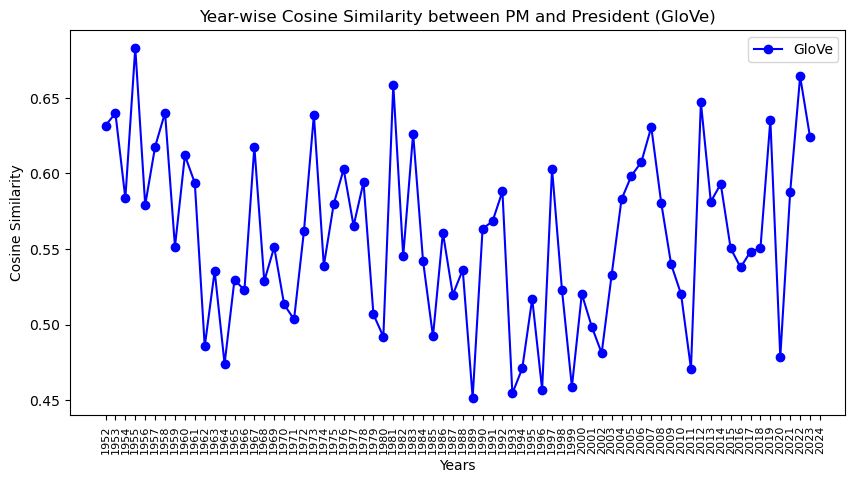

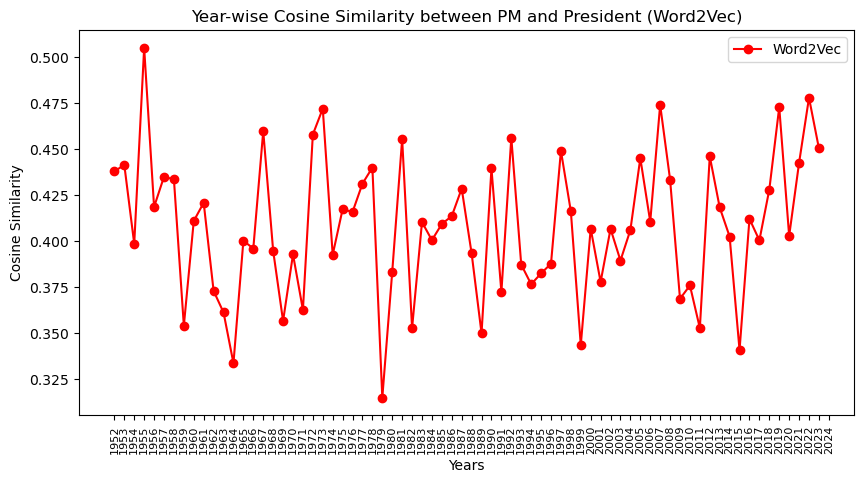

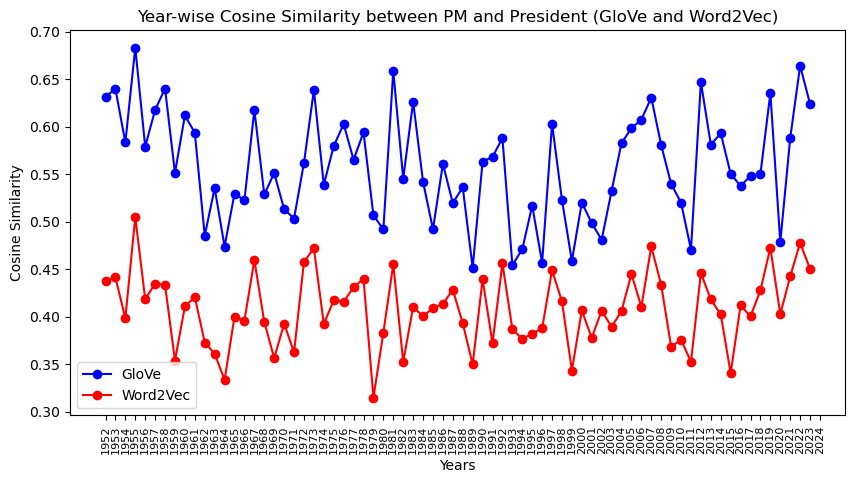

In [48]:
# Function to remove subheadings
def remove_subheadings(topics):
    filtered_topics = []
    for topic in topics:
        filtered_topic = [word for word in topic if not word.startswith('"20') and not word.startswith(' "20')]
        filtered_topics.append(filtered_topic)
    return filtered_topics
# Function to preprocess the data
stop_words = set(stopwords.words('english'))
def preprocess(words):
    return [word.strip('"').lower() for word in words if word.strip('"').lower() not in stop_words and word not in string.punctuation and not word.strip('"').isdigit() and '_' not in word]
# Function to load pre-trained GloVe model
#def load_glove_model(glove_file,show_vectors=True):
 #   model = {}
  #  with open(glove_file, 'r', encoding='utf-8') as f:
   #     for line in f:
    #        parts = line.strip().split()
     #       word = parts[0]
      #      vector = np.array(parts[1:], dtype=np.float32)
       #     model[word] = vector
   # return model
# Function to compute average word vectors
def average_word_vector(words, model, num_features):
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model:
            num_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec
# Function to compute cosine similarity
def compute_similarity(year1_data, year2_data):
    similarities = []
    for vec1 in year1_data:
        for vec2 in year2_data:
            if np.linalg.norm(vec1) != 0 and np.linalg.norm(vec2) != 0: # Avoid zero vectors
                similarity = cosine_similarity([vec1], [vec2])
                similarities.append(similarity[0][0])
    return np.mean(similarities) if similarities else 0
# Paths to the documents
pm_file_path = r'C:\Users\HP\Documents\PM_LOK.docx'
president_file_path = r'C:\Users\HP\Documents\PRESLOK.docx'

# Extract and preprocess data
pm_data = extract_data_from_docx(pm_file_path)
president_data = extract_data_from_docx(president_file_path)
pm_data = {year: remove_subheadings(topics) for year, topics in pm_data.items()}
president_data = {year: remove_subheadings(topics) for year, topics in president_data.items()}
pm_processed_data = {year: [preprocess(topic) for topic in topics] for year, topics in pm_data.items()}
president_processed_data = {year: [preprocess(topic) for topic in topics] for year, topics in president_data.items()}
# Print the processed data for verification
print("Processed PM Data:")
for year, topics in pm_processed_data.items():
    print(f"Year {year}: {topics}")
print("\nProcessed President Data:")
for year, topics in president_processed_data.items():
    print(f"Year {year}: {topics}")


# Compute average word vectors
pm_avg_word_vectors_glove = {year: [average_word_vector(topic, glove_model, 300) for topic in topics] for year, topics in pm_processed_data.items()}
president_avg_word_vectors_glove = {year: [average_word_vector(topic, glove_model, 300) for topic in topics] for year, topics in president_processed_data.items()}
pm_avg_word_vectors_word2vec = {year: [average_word_vector(topic, word2vec_model, 300) for topic in topics] for year, topics in pm_processed_data.items()}
president_avg_word_vectors_word2vec = {year: [average_word_vector(topic, word2vec_model, 300) for topic in topics] for year, topics in president_processed_data.items()}
# Compute cosine similarity between PM and President for each year
results_glove = {}
results_word2vec = {}
years = set(pm_avg_word_vectors_glove.keys()).intersection(president_avg_word_vectors_glove.keys())
for year in years:
    results_glove[year] = compute_similarity(pm_avg_word_vectors_glove[year], president_avg_word_vectors_glove[year])
    results_word2vec[year] = compute_similarity(pm_avg_word_vectors_word2vec[year], president_avg_word_vectors_word2vec[year])
print("Cosine similarity results with GloVe:", results_glove)
print("Cosine similarity results with Word2Vec:", results_word2vec)
years_range = list(range(1952, 2025))
cosine_similarities_glove = [results_glove.get(year, None) for year in years_range]
cosine_similarities_word2vec = [results_word2vec.get(year, None) for year in years_range]

# Plot GloVe cosine similarities
plt.figure(figsize=(10, 5))
plt.plot(years_range, cosine_similarities_glove, 'bo-', label='GloVe')
plt.title('Year-wise Cosine Similarity between PM and President (GloVe)')
plt.xlabel('Years')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.xticks(years_range, rotation=90, fontsize=8)
plt.grid(False)
plt.show()

# Plot Word2Vec cosine similarities
plt.figure(figsize=(10, 5))
plt.plot(years_range, cosine_similarities_word2vec, 'ro-', label='Word2Vec')
plt.title('Year-wise Cosine Similarity between PM and President (Word2Vec)')
plt.xlabel('Years')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.xticks(years_range, rotation=90, fontsize=8)
plt.grid(False)
plt.show()

# Plot both GloVe and Word2Vec cosine similarities
plt.figure(figsize=(10, 5))
plt.plot(years_range, cosine_similarities_glove, 'bo-', label='GloVe')
plt.plot(years_range, cosine_similarities_word2vec, 'ro-', label='Word2Vec')
plt.title('Year-wise Cosine Similarity between PM and President (GloVe and Word2Vec)')
plt.xlabel('Years')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.xticks(years_range, rotation=90, fontsize=8)
plt.grid(False)
plt.show()


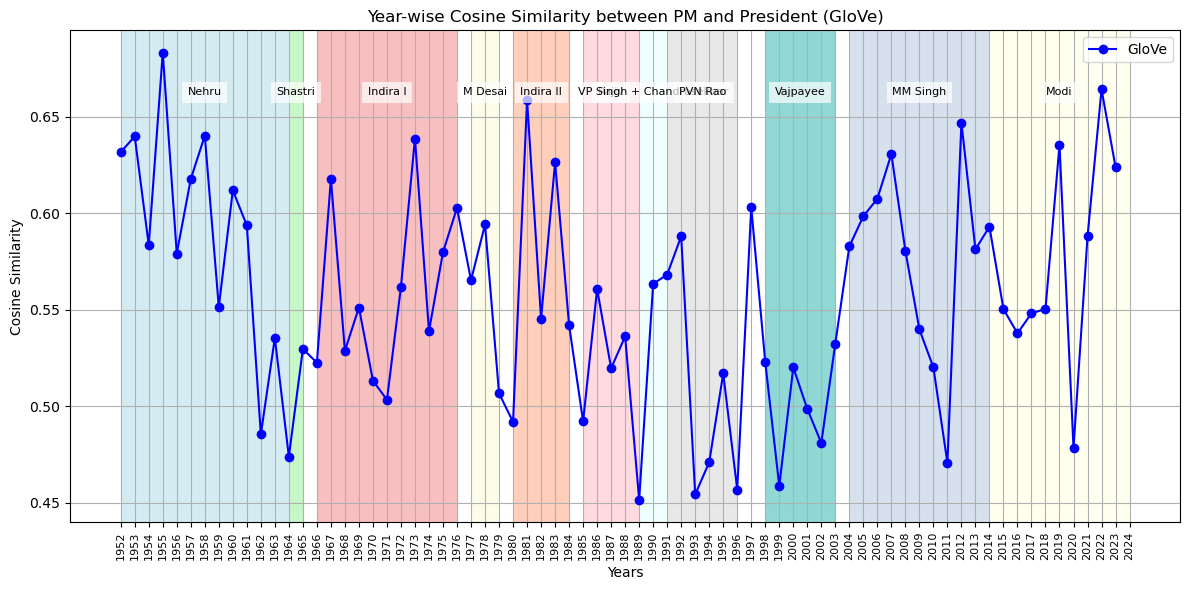

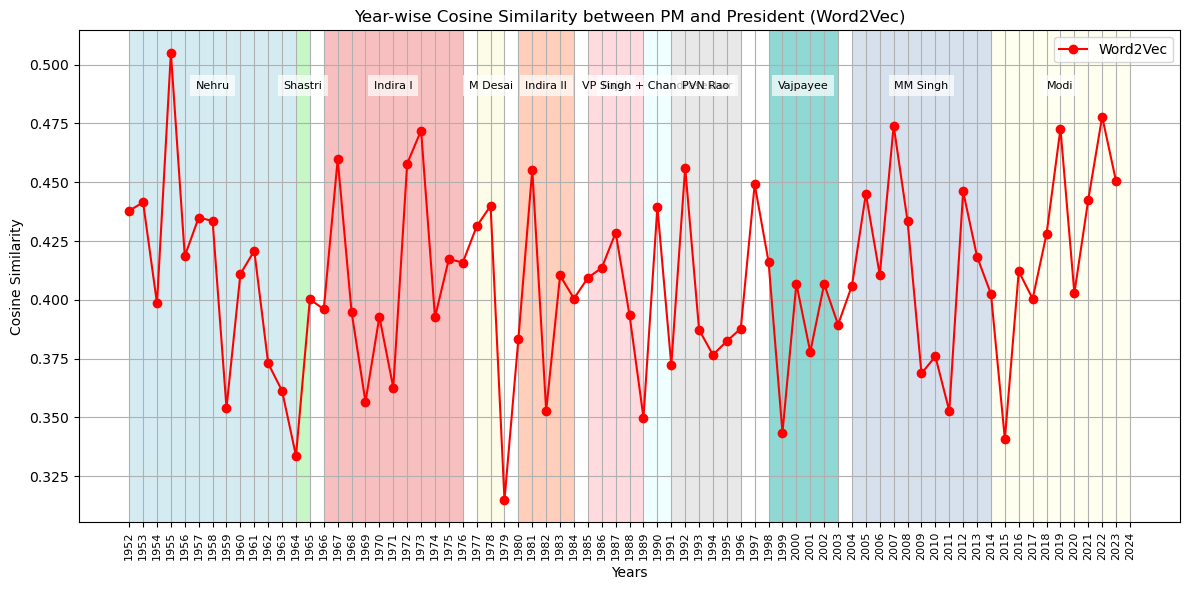

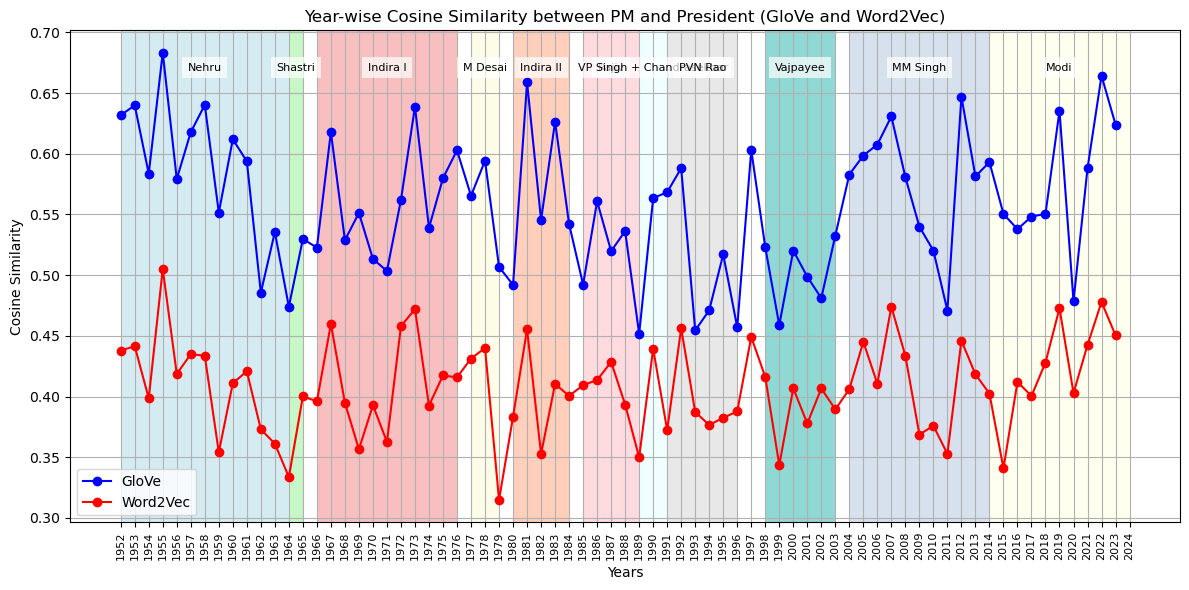

In [49]:
import matplotlib.pyplot as plt

# Define the PM terms with colors
pm_terms = {
    'Nehru': (1952, 1964, 'lightblue'),
    'Shastri': (1964, 1965, 'lightgreen'),
    'Indira I': (1966, 1976, 'lightcoral'),
    'M Desai': (1977, 1979, 'lightgoldenrodyellow'),
    'Indira II': (1980, 1984, 'lightsalmon'),
    'Rajiv': (1985, 1989, 'lightpink'),
    'VP Singh + Chandrasekhar': (1989, 1991, 'lightcyan'),
    'PVN Rao': (1991, 1996, 'lightgray'),
    'Vajpayee': (1998, 2003, 'lightseagreen'),
    'MM Singh': (2004, 2014, 'lightsteelblue'),
    'Modi': (2014, 2024, 'lightyellow')
}

# Function to add PM gridlines and labels
def add_pm_gridlines(ax, pm_terms):
    for pm, (start, end, color) in pm_terms.items():
        ax.axvspan(start, end, color=color, alpha=0.5, lw=0)  # Use different colors for PM terms
        ax.text((start + end) / 2, ax.get_ylim()[1] * 0.95, pm, ha='center', va='bottom', fontsize=8, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Plot GloVe cosine similarities
plt.figure(figsize=(12, 6))
plt.plot(years_range, cosine_similarities_glove, 'bo-', label='GloVe')
plt.title('Year-wise Cosine Similarity between PM and President (GloVe)')
plt.xlabel('Years')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.xticks(years_range, rotation=90, fontsize=8)
plt.grid(True)

# Add PM gridlines and labels
ax = plt.gca()
add_pm_gridlines(ax, pm_terms)

plt.tight_layout()
plt.show()

# Plot Word2Vec cosine similarities
plt.figure(figsize=(12, 6))
plt.plot(years_range, cosine_similarities_word2vec, 'ro-', label='Word2Vec')
plt.title('Year-wise Cosine Similarity between PM and President (Word2Vec)')
plt.xlabel('Years')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.xticks(years_range, rotation=90, fontsize=8)
plt.grid(True)

# Add PM gridlines and labels
ax = plt.gca()
add_pm_gridlines(ax, pm_terms)

plt.tight_layout()
plt.show()

# Plot both GloVe and Word2Vec cosine similarities
plt.figure(figsize=(12, 6))
plt.plot(years_range, cosine_similarities_glove, 'bo-', label='GloVe')
plt.plot(years_range, cosine_similarities_word2vec, 'ro-', label='Word2Vec')
plt.title('Year-wise Cosine Similarity between PM and President (GloVe and Word2Vec)')
plt.xlabel('Years')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.xticks(years_range, rotation=90, fontsize=8)
plt.grid(True)

# Add PM gridlines and labels
ax = plt.gca()
add_pm_gridlines(ax, pm_terms)

plt.tight_layout()
plt.show()


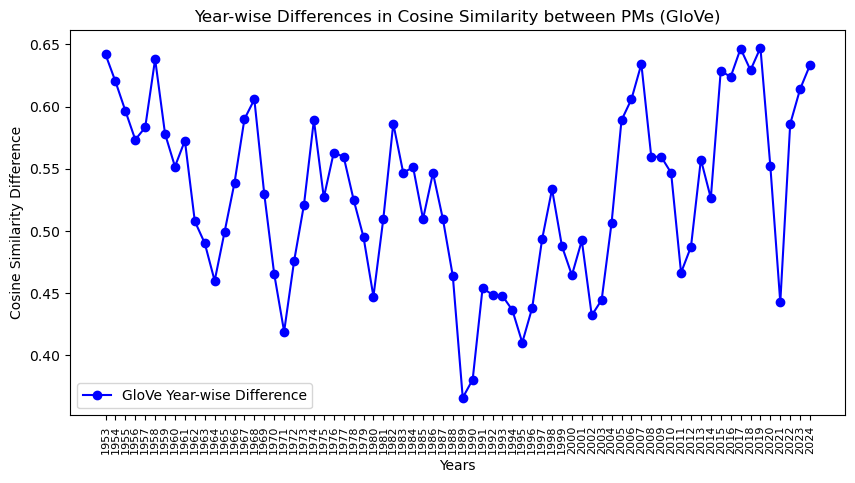

In [50]:
# Compute year-wise differences in cosine similarity for GloVe model
year_wise_diff_glove = {}
years = sorted(pm_avg_word_vectors_glove.keys())
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    sim_prev = compute_similarity(pm_avg_word_vectors_glove[prev_year], pm_avg_word_vectors_glove[curr_year])
    year_wise_diff_glove[curr_year] = sim_prev

# Convert the results to lists for plotting
years_range = list(range(1953, 2025)) # As 1952 is the first year, we start from 1953
similarity_diffs_glove = [year_wise_diff_glove.get(year, None) for year in years_range]

# Plot year-wise differences in cosine similarity for GloVe model
plt.figure(figsize=(10, 5))
plt.plot(years_range, similarity_diffs_glove, 'bo-', label='GloVe Year-wise Difference')
plt.title('Year-wise Differences in Cosine Similarity between PMs (GloVe)')
plt.xlabel('Years')
plt.ylabel('Cosine Similarity Difference')
plt.legend()
plt.xticks(years_range, rotation=90, fontsize=8)
plt.grid(False)
plt.show()


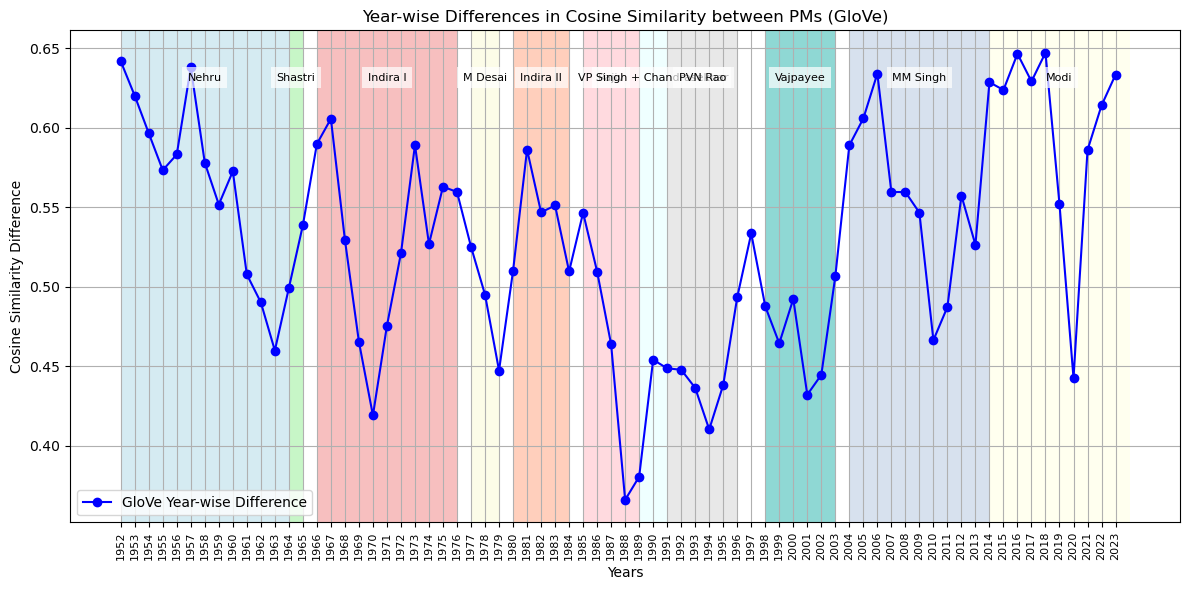

In [51]:
import matplotlib.pyplot as plt

# Compute year-wise differences in cosine similarity for GloVe model
year_wise_diff_glove = {}
years = sorted(pm_avg_word_vectors_glove.keys())
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    sim_diff = compute_similarity(pm_avg_word_vectors_glove[prev_year], pm_avg_word_vectors_glove[curr_year])
    year_wise_diff_glove[(prev_year, curr_year)] = sim_diff

# Convert the results to lists for plotting
years_range = list(range(1952, 2024))  # Now includes 1952-2023 pairs
similarity_diffs_glove = [year_wise_diff_glove.get((year, year+1), None) for year in years_range]

# Define the PM terms with colors
pm_terms = {
    'Nehru': (1952, 1964, 'lightblue'),
    'Shastri': (1964, 1965, 'lightgreen'),
    'Indira I': (1966, 1976, 'lightcoral'),
    'M Desai': (1977, 1979, 'lightgoldenrodyellow'),
    'Indira II': (1980, 1984, 'lightsalmon'),
    'Rajiv': (1985, 1989, 'lightpink'),
    'VP Singh + Chandrasekhar': (1989, 1991, 'lightcyan'),
    'PVN Rao': (1991, 1996, 'lightgray'),
    'Vajpayee': (1998, 2003, 'lightseagreen'),
    'MM Singh': (2004, 2014, 'lightsteelblue'),
    'Modi': (2014, 2024, 'lightyellow')
}

# Function to add PM gridlines and labels
def add_pm_gridlines(ax, pm_terms):
    for pm, (start, end, color) in pm_terms.items():
        ax.axvspan(start, end, color=color, alpha=0.5, lw=0)  # Use different colors for PM terms
        ax.text((start + end) / 2, ax.get_ylim()[1] * 0.95, pm, ha='center', va='bottom', fontsize=8, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Plot year-wise differences in cosine similarity for GloVe model
plt.figure(figsize=(12, 6))
plt.plot(years_range, similarity_diffs_glove, 'bo-', label='GloVe Year-wise Difference')
plt.title('Year-wise Differences in Cosine Similarity between PMs (GloVe)')
plt.xlabel('Years')
plt.ylabel('Cosine Similarity Difference')
plt.legend()
plt.xticks(years_range, rotation=90, fontsize=8)
plt.grid(True)

# Add PM gridlines and labels
ax = plt.gca()
add_pm_gridlines(ax, pm_terms)

plt.tight_layout()
plt.show()


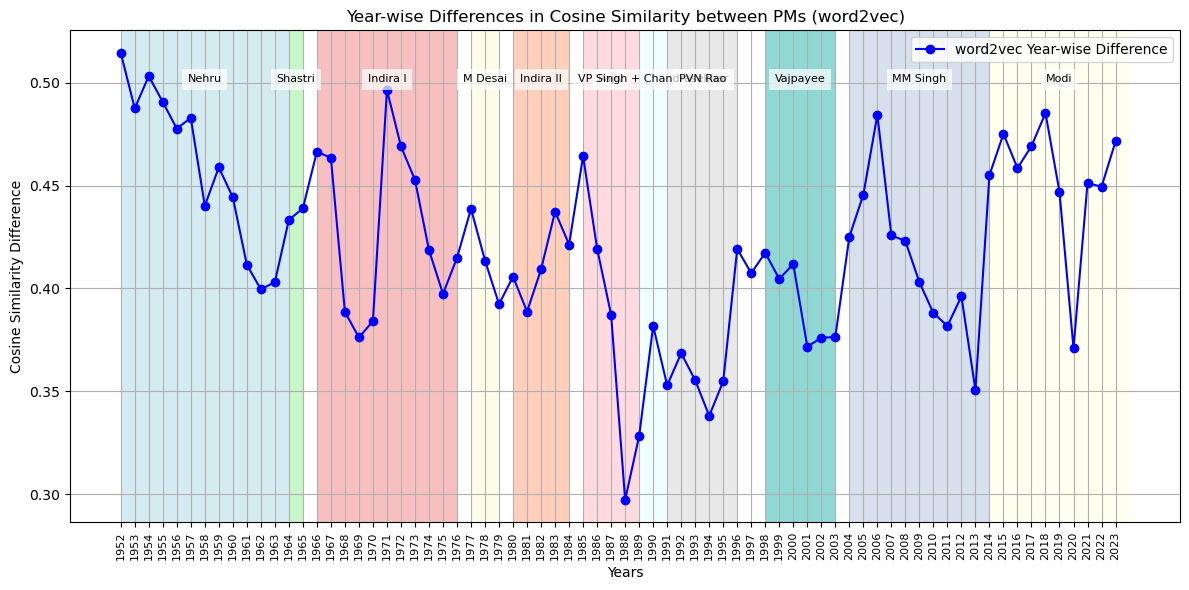

In [52]:
import matplotlib.pyplot as plt

# Compute year-wise differences in cosine similarity for GloVe model
year_wise_diff_word2vec= {}
years = sorted(pm_avg_word_vectors_word2vec.keys())
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    sim_diff = compute_similarity(pm_avg_word_vectors_word2vec[prev_year], pm_avg_word_vectors_word2vec[curr_year])
    year_wise_diff_word2vec[(prev_year, curr_year)] = sim_diff

# Convert the results to lists for plotting
years_range = list(range(1952, 2024))  # Now includes 1952-2023 pairs
similarity_diffs_word2vec = [year_wise_diff_word2vec.get((year, year+1), None) for year in years_range]

# Define the PM terms with colors
pm_terms = {
    'Nehru': (1952, 1964, 'lightblue'),
    'Shastri': (1964, 1965, 'lightgreen'),
    'Indira I': (1966, 1976, 'lightcoral'),
    'M Desai': (1977, 1979, 'lightgoldenrodyellow'),
    'Indira II': (1980, 1984, 'lightsalmon'),
    'Rajiv': (1985, 1989, 'lightpink'),
    'VP Singh + Chandrasekhar': (1989, 1991, 'lightcyan'),
    'PVN Rao': (1991, 1996, 'lightgray'),
    'Vajpayee': (1998, 2003, 'lightseagreen'),
    'MM Singh': (2004, 2014, 'lightsteelblue'),
    'Modi': (2014, 2024, 'lightyellow')
}

# Function to add PM gridlines and labels
def add_pm_gridlines(ax, pm_terms):
    for pm, (start, end, color) in pm_terms.items():
        ax.axvspan(start, end, color=color, alpha=0.5, lw=0)  # Use different colors for PM terms
        ax.text((start + end) / 2, ax.get_ylim()[1] * 0.95, pm, ha='center', va='bottom', fontsize=8, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Plot year-wise differences in cosine similarity for GloVe model
plt.figure(figsize=(12, 6))
plt.plot(years_range, similarity_diffs_word2vec, 'bo-', label='word2vec Year-wise Difference')
plt.title('Year-wise Differences in Cosine Similarity between PMs (word2vec)')
plt.xlabel('Years')
plt.ylabel('Cosine Similarity Difference')
plt.legend()
plt.xticks(years_range, rotation=90, fontsize=8)
plt.grid(True)

# Add PM gridlines and labels
ax = plt.gca()
add_pm_gridlines(ax, pm_terms)

plt.tight_layout()
plt.show()


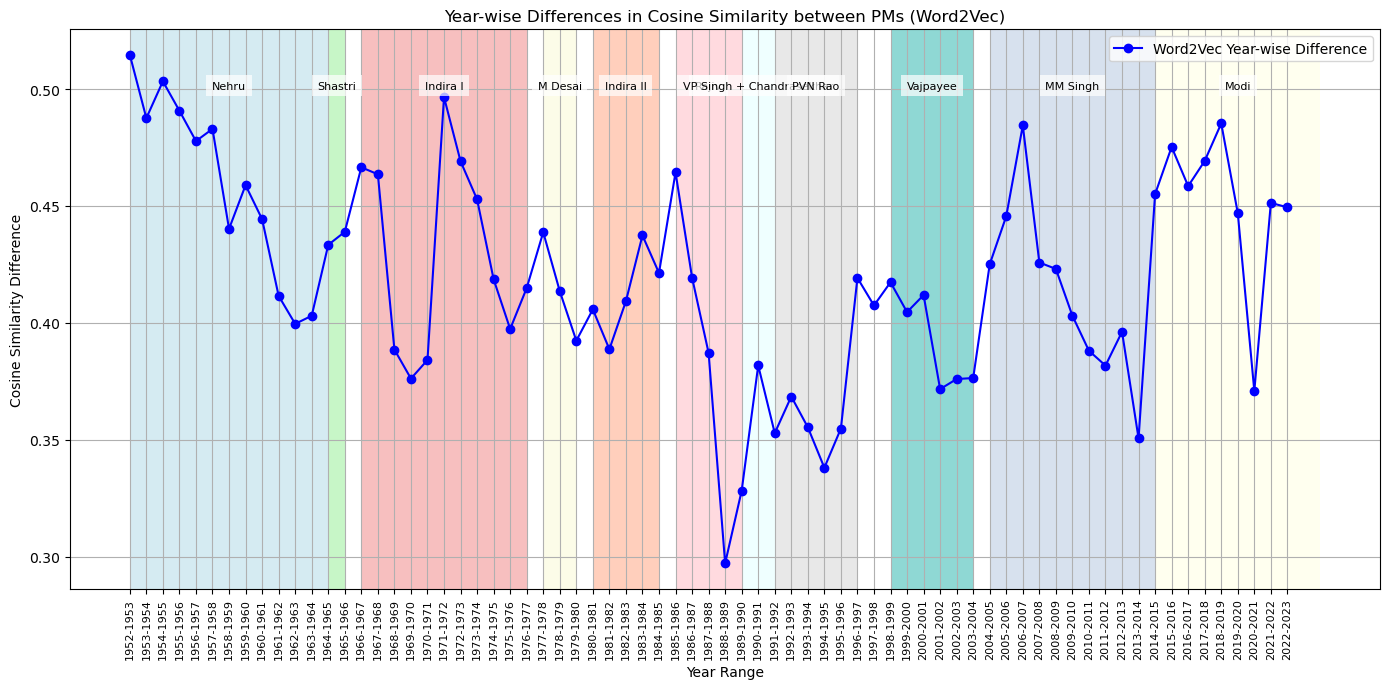

In [53]:
import matplotlib.pyplot as plt

# Compute year-wise differences in cosine similarity for Word2Vec model
year_wise_diff_word2vec = {}
years = sorted(pm_avg_word_vectors_word2vec.keys())
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    sim_diff = compute_similarity(pm_avg_word_vectors_word2vec[prev_year], pm_avg_word_vectors_word2vec[curr_year])
    year_wise_diff_word2vec[(prev_year, curr_year)] = sim_diff

# Convert the results to lists for plotting
years_range = list(range(1952, 2023))  # Now includes 1952-2022 pairs for year range labels
similarity_diffs_word2vec = [year_wise_diff_word2vec.get((year, year+1), None) for year in years_range]

# Create year range labels
year_range_labels = [f"{year}-{year+1}" for year in years_range]

# Define the PM terms with colors
pm_terms = {
    'Nehru': (1952, 1964, 'lightblue'),
    'Shastri': (1964, 1965, 'lightgreen'),
    'Indira I': (1966, 1976, 'lightcoral'),
    'M Desai': (1977, 1979, 'lightgoldenrodyellow'),
    'Indira II': (1980, 1984, 'lightsalmon'),
    'Rajiv': (1985, 1989, 'lightpink'),
    'VP Singh + Chandrasekhar': (1989, 1991, 'lightcyan'),
    'PVN Rao': (1991, 1996, 'lightgray'),
    'Vajpayee': (1998, 2003, 'lightseagreen'),
    'MM Singh': (2004, 2014, 'lightsteelblue'),
    'Modi': (2014, 2024, 'lightyellow')
}

# Function to add PM gridlines and labels
def add_pm_gridlines(ax, pm_terms):
    for pm, (start, end, color) in pm_terms.items():
        ax.axvspan(start, end, color=color, alpha=0.5, lw=0)  # Use different colors for PM terms
        ax.text((start + end) / 2, ax.get_ylim()[1] * 0.95, pm, ha='center', va='bottom', fontsize=8, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Plot year-wise differences in cosine similarity for Word2Vec model
plt.figure(figsize=(14, 7))
plt.plot(years_range, similarity_diffs_word2vec, 'bo-', label='Word2Vec Year-wise Difference')
plt.title('Year-wise Differences in Cosine Similarity between PMs (Word2Vec)')
plt.xlabel('Year Range')
plt.ylabel('Cosine Similarity Difference')
plt.legend()
plt.xticks(years_range, year_range_labels, rotation=90, fontsize=8)
plt.grid(True)

# Add PM gridlines and labels
ax = plt.gca()
add_pm_gridlines(ax, pm_terms)

plt.tight_layout()
plt.show()


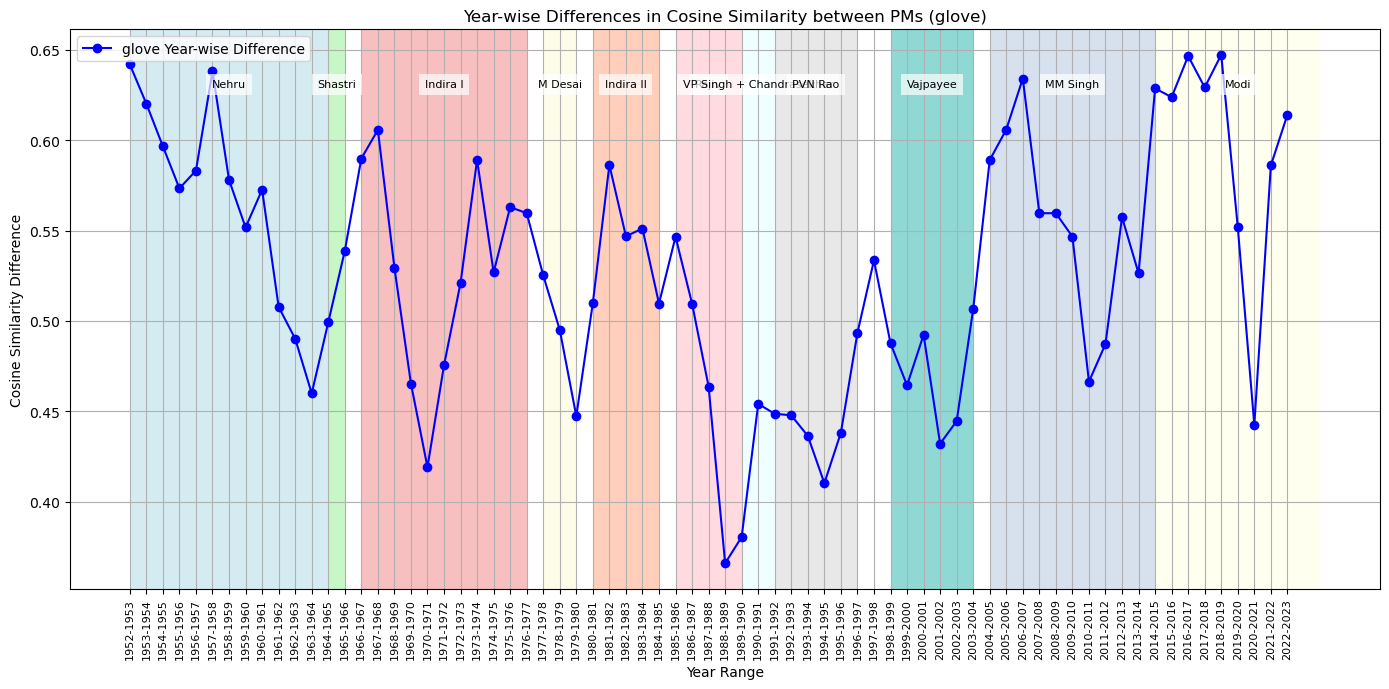

In [54]:
import matplotlib.pyplot as plt

# Compute year-wise differences in cosine similarity for Word2Vec model
year_wise_diff_glove = {}
years = sorted(pm_avg_word_vectors_glove.keys())
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    sim_diff = compute_similarity(pm_avg_word_vectors_glove[prev_year], pm_avg_word_vectors_glove[curr_year])
    year_wise_diff_glove[(prev_year, curr_year)] = sim_diff

# Convert the results to lists for plotting
years_range = list(range(1952, 2023))  # Now includes 1952-2022 pairs for year range labels
similarity_diffs_glove = [year_wise_diff_glove.get((year, year+1), None) for year in years_range]

# Create year range labels
year_range_labels = [f"{year}-{year+1}" for year in years_range]

# Define the PM terms with colors
pm_terms = {
    'Nehru': (1952, 1964, 'lightblue'),
    'Shastri': (1964, 1965, 'lightgreen'),
    'Indira I': (1966, 1976, 'lightcoral'),
    'M Desai': (1977, 1979, 'lightgoldenrodyellow'),
    'Indira II': (1980, 1984, 'lightsalmon'),
    'Rajiv': (1985, 1989, 'lightpink'),
    'VP Singh + Chandrasekhar': (1989, 1991, 'lightcyan'),
    'PVN Rao': (1991, 1996, 'lightgray'),
    'Vajpayee': (1998, 2003, 'lightseagreen'),
    'MM Singh': (2004, 2014, 'lightsteelblue'),
    'Modi': (2014, 2024, 'lightyellow')
}

# Function to add PM gridlines and labels
def add_pm_gridlines(ax, pm_terms):
    for pm, (start, end, color) in pm_terms.items():
        ax.axvspan(start, end, color=color, alpha=0.5, lw=0)  # Use different colors for PM terms
        ax.text((start + end) / 2, ax.get_ylim()[1] * 0.95, pm, ha='center', va='bottom', fontsize=8, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Plot year-wise differences in cosine similarity for Word2Vec model
plt.figure(figsize=(14, 7))
plt.plot(years_range, similarity_diffs_glove, 'bo-', label='glove Year-wise Difference')
plt.title('Year-wise Differences in Cosine Similarity between PMs (glove)')
plt.xlabel('Year Range')
plt.ylabel('Cosine Similarity Difference')
plt.legend()
plt.xticks(years_range, year_range_labels, rotation=90, fontsize=8)
plt.grid(True)

# Add PM gridlines and labels
ax = plt.gca()
add_pm_gridlines(ax, pm_terms)

plt.tight_layout()
plt.show()


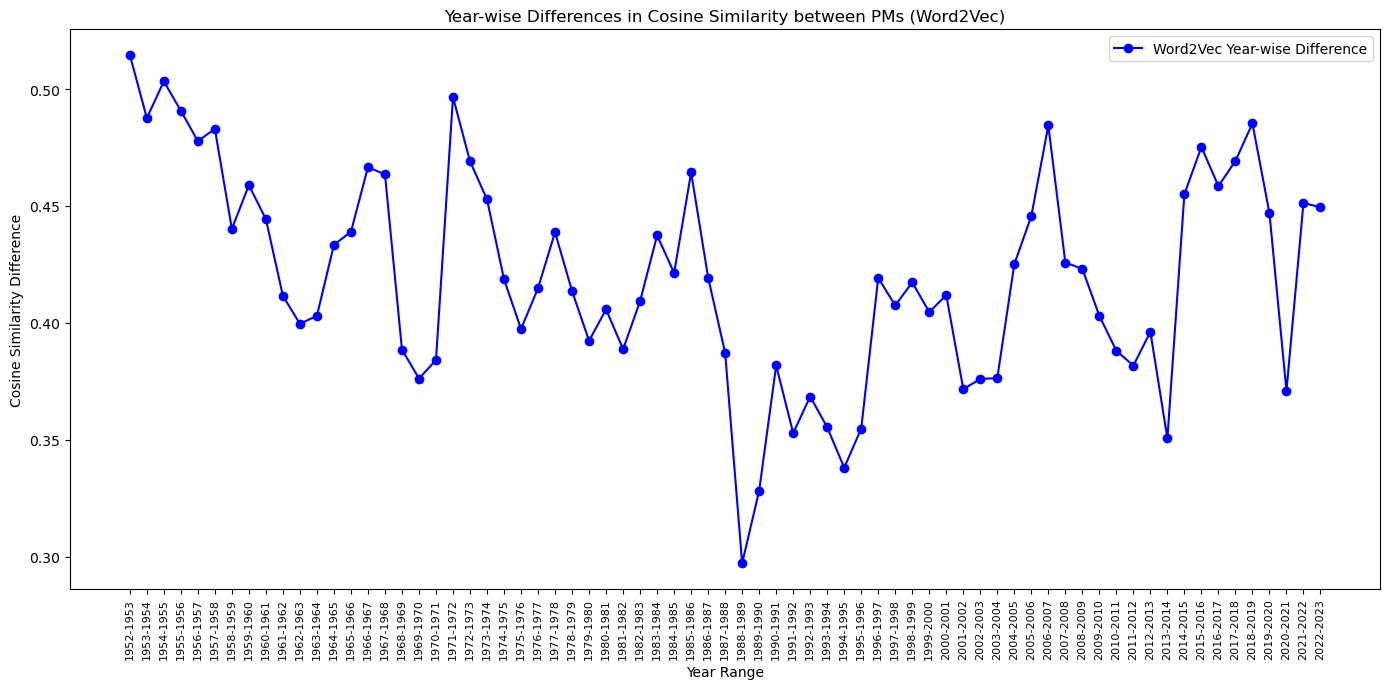

In [55]:
import matplotlib.pyplot as plt

# Compute year-wise differences in cosine similarity for Word2Vec model
year_wise_diff_word2vec = {}
years = sorted(pm_avg_word_vectors_word2vec.keys())
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    sim_diff = compute_similarity(pm_avg_word_vectors_word2vec[prev_year], pm_avg_word_vectors_word2vec[curr_year])
    year_wise_diff_word2vec[(prev_year, curr_year)] = sim_diff

# Convert the results to lists for plotting
years_range = list(range(1952, 2023))  # Now includes 1952-2022 pairs for year range labels
similarity_diffs_word2vec = [year_wise_diff_word2vec.get((year, year+1), None) for year in years_range]

# Create year range labels
year_range_labels = [f"{year}-{year+1}" for year in years_range]

# Plot year-wise differences in cosine similarity for Word2Vec model
plt.figure(figsize=(14, 7))
plt.plot(years_range, similarity_diffs_word2vec, 'bo-', label='Word2Vec Year-wise Difference')
plt.title('Year-wise Differences in Cosine Similarity between PMs (Word2Vec)')
plt.xlabel('Year Range')
plt.ylabel('Cosine Similarity Difference')
plt.legend()
plt.xticks(years_range, year_range_labels, rotation=90, fontsize=8)

# Remove gridlines for a plain graph
plt.grid(False)

plt.tight_layout()
plt.show()


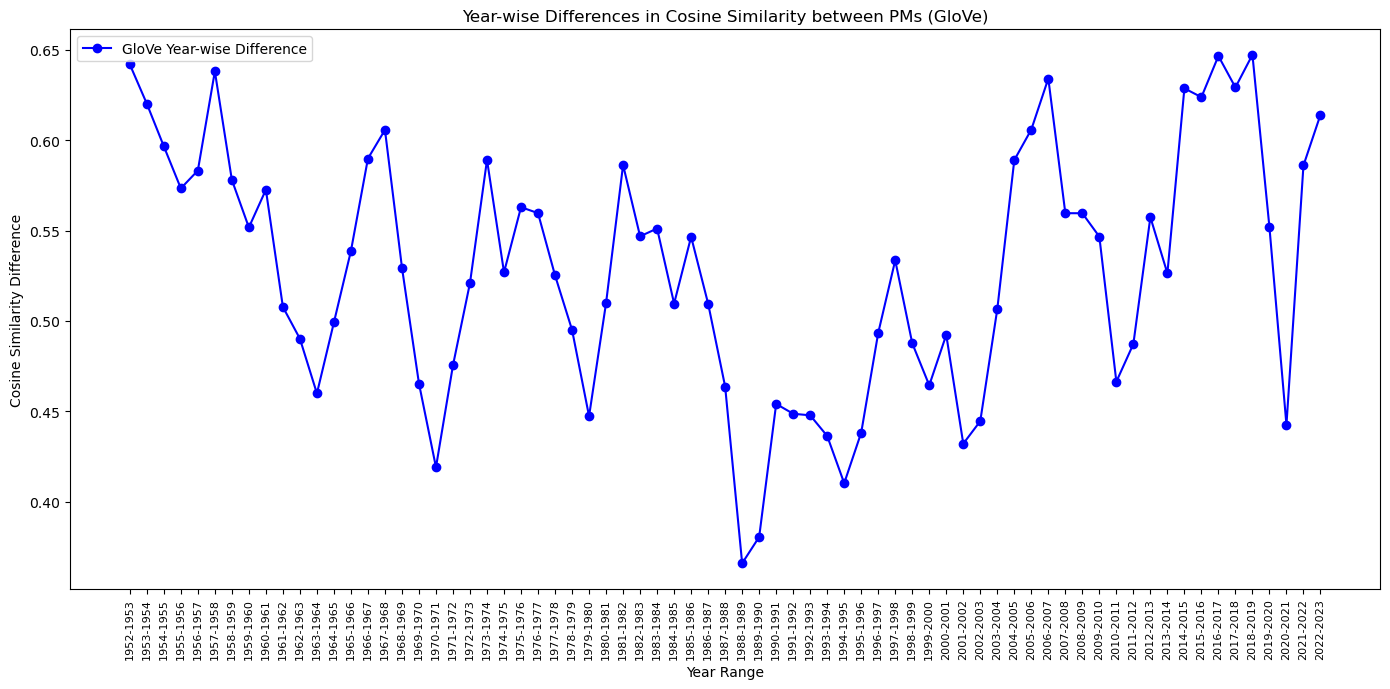

In [56]:
import matplotlib.pyplot as plt

# Compute year-wise differences in cosine similarity for GloVe model
year_wise_diff_glove = {}
years = sorted(pm_avg_word_vectors_glove.keys())
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    sim_diff = compute_similarity(pm_avg_word_vectors_glove[prev_year], pm_avg_word_vectors_glove[curr_year])
    year_wise_diff_glove[(prev_year, curr_year)] = sim_diff

# Convert the results to lists for plotting
years_range = list(range(1952, 2023))  # Now includes 1952-2022 pairs for year range labels
similarity_diffs_glove = [year_wise_diff_glove.get((year, year+1), None) for year in years_range]

# Create year range labels
year_range_labels = [f"{year}-{year+1}" for year in years_range]

# Plot year-wise differences in cosine similarity for GloVe model
plt.figure(figsize=(14, 7))
plt.plot(years_range, similarity_diffs_glove, 'bo-', label='GloVe Year-wise Difference')
plt.title('Year-wise Differences in Cosine Similarity between PMs (GloVe)')
plt.xlabel('Year Range')
plt.ylabel('Cosine Similarity Difference')
plt.legend()
plt.xticks(years_range, year_range_labels, rotation=90, fontsize=8)

# Remove gridlines for a plain graph
plt.grid(False)

plt.tight_layout()
plt.show()


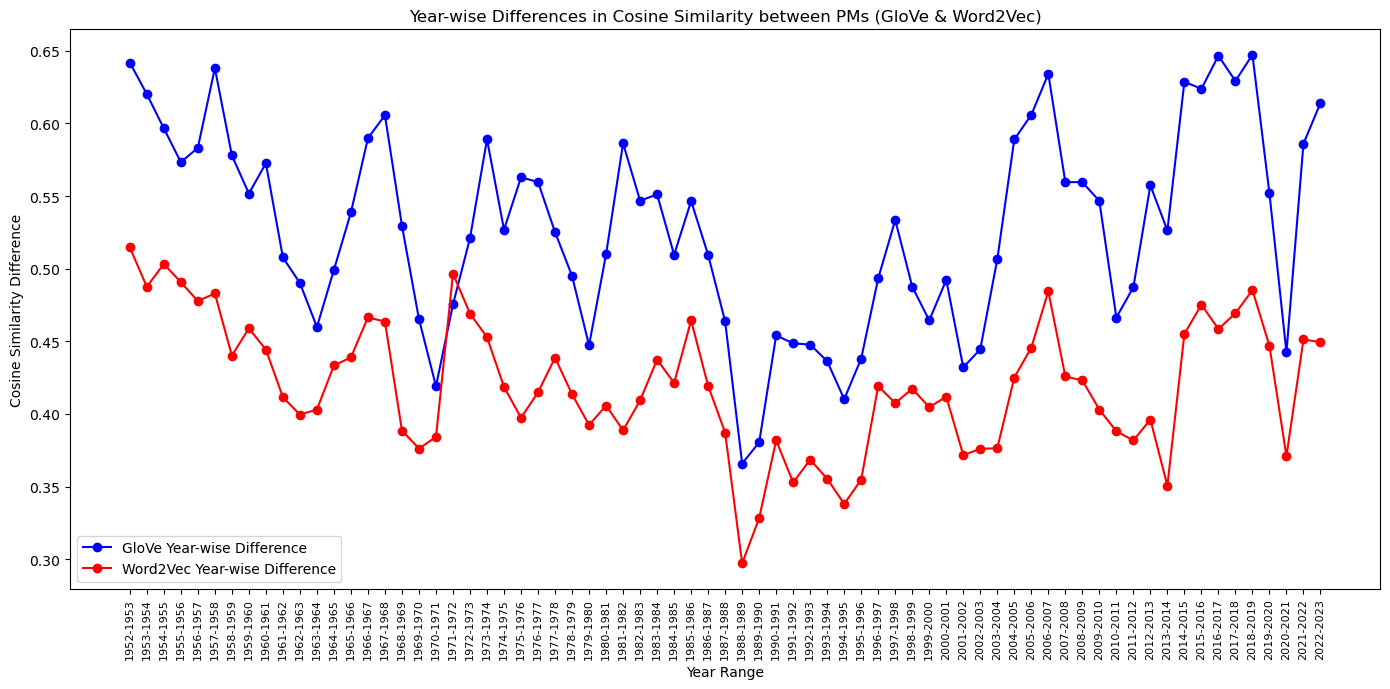

In [57]:
import matplotlib.pyplot as plt

# Compute year-wise differences in cosine similarity for GloVe model
year_wise_diff_glove = {}
years = sorted(pm_avg_word_vectors_glove.keys())
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    sim_diff = compute_similarity(pm_avg_word_vectors_glove[prev_year], pm_avg_word_vectors_glove[curr_year])
    year_wise_diff_glove[(prev_year, curr_year)] = sim_diff

# Compute year-wise differences in cosine similarity for Word2Vec model
year_wise_diff_word2vec = {}
years = sorted(pm_avg_word_vectors_word2vec.keys())
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    sim_diff = compute_similarity(pm_avg_word_vectors_word2vec[prev_year], pm_avg_word_vectors_word2vec[curr_year])
    year_wise_diff_word2vec[(prev_year, curr_year)] = sim_diff

# Convert the results to lists for plotting
years_range = list(range(1952, 2023))  # Now includes 1952-2022 pairs for year range labels
similarity_diffs_glove = [year_wise_diff_glove.get((year, year+1), None) for year in years_range]
similarity_diffs_word2vec = [year_wise_diff_word2vec.get((year, year+1), None) for year in years_range]

# Create year range labels
year_range_labels = [f"{year}-{year+1}" for year in years_range]

# Plot year-wise differences in cosine similarity for both models
plt.figure(figsize=(14, 7))
plt.plot(years_range, similarity_diffs_glove, 'bo-', label='GloVe Year-wise Difference')
plt.plot(years_range, similarity_diffs_word2vec, 'ro-', label='Word2Vec Year-wise Difference')
plt.title('Year-wise Differences in Cosine Similarity between PMs (GloVe & Word2Vec)')
plt.xlabel('Year Range')
plt.ylabel('Cosine Similarity Difference')
plt.legend()
plt.xticks(years_range, year_range_labels, rotation=90, fontsize=8)

# Remove gridlines for a plain graph
plt.grid(False)

plt.tight_layout()
plt.show()


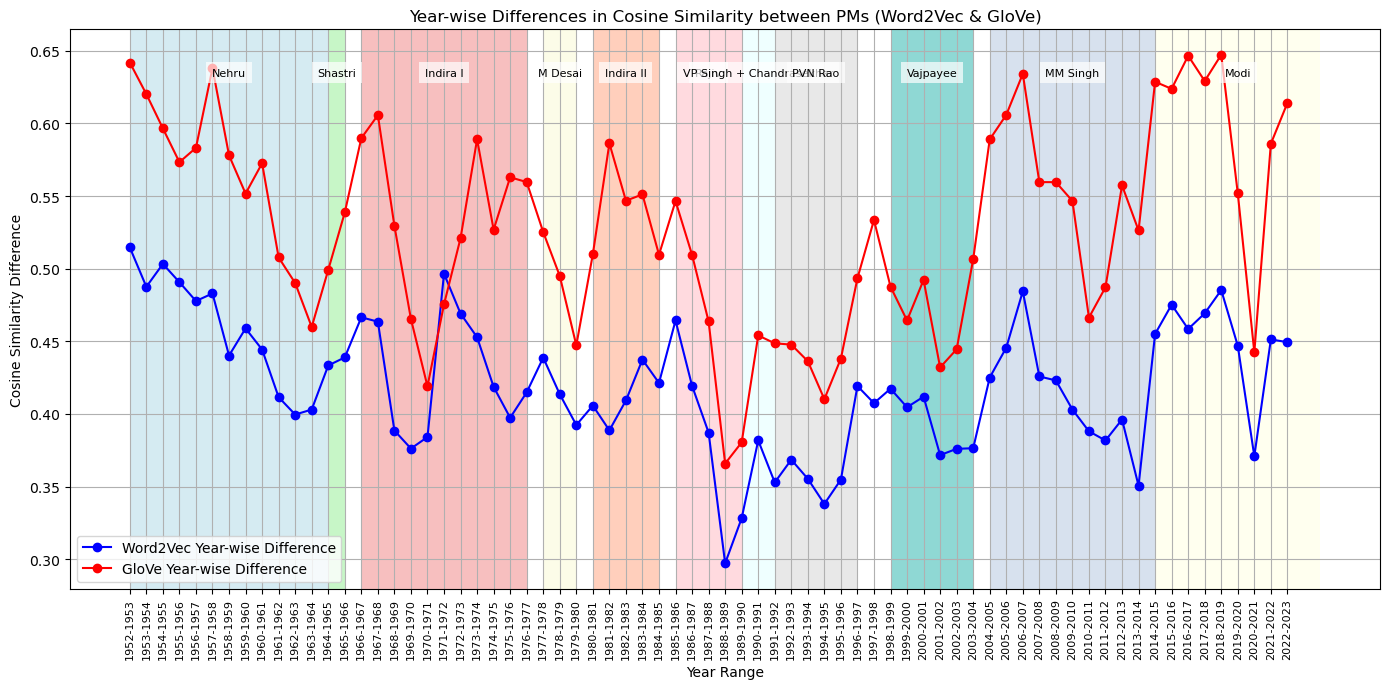

In [58]:
import matplotlib.pyplot as plt

# Compute year-wise differences in cosine similarity for Word2Vec model
year_wise_diff_word2vec = {}
years = sorted(pm_avg_word_vectors_word2vec.keys())
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    sim_diff = compute_similarity(pm_avg_word_vectors_word2vec[prev_year], pm_avg_word_vectors_word2vec[curr_year])
    year_wise_diff_word2vec[(prev_year, curr_year)] = sim_diff

# Compute year-wise differences in cosine similarity for GloVe model
year_wise_diff_glove = {}
years = sorted(pm_avg_word_vectors_glove.keys())
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    sim_diff = compute_similarity(pm_avg_word_vectors_glove[prev_year], pm_avg_word_vectors_glove[curr_year])
    year_wise_diff_glove[(prev_year, curr_year)] = sim_diff

# Convert the results to lists for plotting
years_range = list(range(1952, 2023))  # Now includes 1952-2022 pairs for year range labels
similarity_diffs_word2vec = [year_wise_diff_word2vec.get((year, year+1), None) for year in years_range]
similarity_diffs_glove = [year_wise_diff_glove.get((year, year+1), None) for year in years_range]

# Create year range labels
year_range_labels = [f"{year}-{year+1}" for year in years_range]

# Define the PM terms with colors
pm_terms = {
    'Nehru': (1952, 1964, 'lightblue'),
    'Shastri': (1964, 1965, 'lightgreen'),
    'Indira I': (1966, 1976, 'lightcoral'),
    'M Desai': (1977, 1979, 'lightgoldenrodyellow'),
    'Indira II': (1980, 1984, 'lightsalmon'),
    'Rajiv': (1985, 1989, 'lightpink'),
    'VP Singh + Chandrasekhar': (1989, 1991, 'lightcyan'),
    'PVN Rao': (1991, 1996, 'lightgray'),
    'Vajpayee': (1998, 2003, 'lightseagreen'),
    'MM Singh': (2004, 2014, 'lightsteelblue'),
    'Modi': (2014, 2024, 'lightyellow')
}

# Function to add PM gridlines and labels
def add_pm_gridlines(ax, pm_terms):
    for pm, (start, end, color) in pm_terms.items():
        ax.axvspan(start, end, color=color, alpha=0.5, lw=0)  # Use different colors for PM terms
        ax.text((start + end) / 2, ax.get_ylim()[1] * 0.95, pm, ha='center', va='bottom', fontsize=8, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Plot year-wise differences in cosine similarity for both models
plt.figure(figsize=(14, 7))
plt.plot(years_range, similarity_diffs_word2vec, 'bo-', label='Word2Vec Year-wise Difference')
plt.plot(years_range, similarity_diffs_glove, 'ro-', label='GloVe Year-wise Difference')
plt.title('Year-wise Differences in Cosine Similarity between PMs (Word2Vec & GloVe)')
plt.xlabel('Year Range')
plt.ylabel('Cosine Similarity Difference')
plt.legend()
plt.xticks(years_range, year_range_labels, rotation=90, fontsize=8)
plt.grid(True)

# Add PM gridlines and labels
ax = plt.gca()
add_pm_gridlines(ax, pm_terms)

plt.tight_layout()
plt.show()


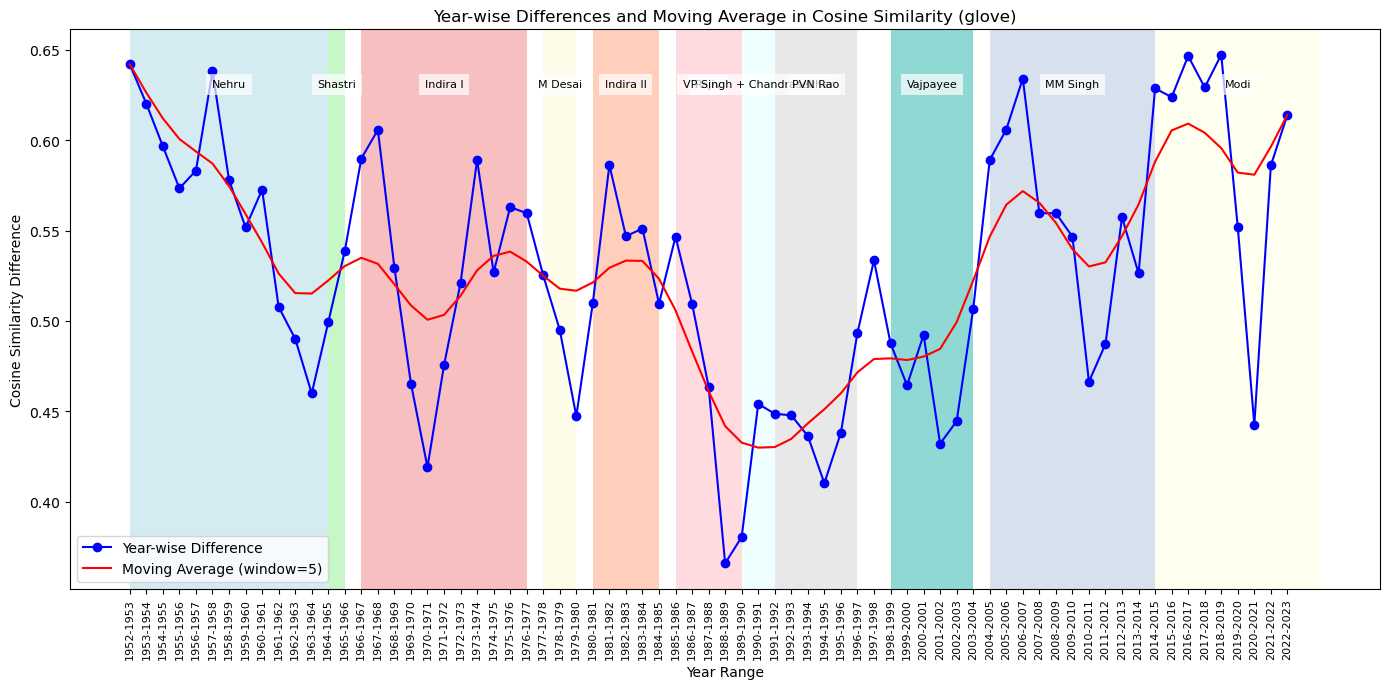

In [59]:
import matplotlib.pyplot as plt
from scipy.signal import filtfilt  # for moving average calculation

# Assuming `pm_avg_word_vectors_glove` and `compute_similarity` are already defined and available

# Compute year-wise differences in cosine similarity for Word2Vec model
year_wise_diff_glove = {}
years = sorted(pm_avg_word_vectors_glove.keys())
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    sim_diff = compute_similarity(pm_avg_word_vectors_glove[prev_year], pm_avg_word_vectors_glove[curr_year])
    year_wise_diff_glove[(prev_year, curr_year)] = sim_diff

# Convert the results to lists for plotting
years_range = list(range(1952, 2023))  # Adjust for your data range
similarity_diffs_glove = [year_wise_diff_glove.get((year, year+1), None) for year in years_range]

# Define the PM terms with colors
pm_terms = {
    'Nehru': (1952, 1964, 'lightblue'),
    'Shastri': (1964, 1965, 'lightgreen'),
    'Indira I': (1966, 1976, 'lightcoral'),
    'M Desai': (1977, 1979, 'lightgoldenrodyellow'),
    'Indira II': (1980, 1984, 'lightsalmon'),
    'Rajiv': (1985, 1989, 'lightpink'),
    'VP Singh + Chandrasekhar': (1989, 1991, 'lightcyan'),
    'PVN Rao': (1991, 1996, 'lightgray'),
    'Vajpayee': (1998, 2003, 'lightseagreen'),
    'MM Singh': (2004, 2014, 'lightsteelblue'),
    'Modi': (2014, 2024, 'lightyellow')
}

# Function to add PM gridlines and labels
def add_pm_gridlines(ax, pm_terms):
    for pm, (start, end, color) in pm_terms.items():
        ax.axvspan(start, end, color=color, alpha=0.5, lw=0)  # Use different colors for PM terms
        ax.text((start + end) / 2, ax.get_ylim()[1] * 0.95, pm, ha='center', va='bottom', fontsize=8, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Define window size for moving average
window_size = 5  # Adjust this value as needed for smoothing

# Calculate moving average using filtfilt (more robust for filtering)
similarity_diffs_glove_ma = filtfilt([1 / window_size] * window_size, [1], similarity_diffs_glove)

# Use the original years_range for x-axis labels
year_range_labels_ma = [f"{year}-{year+1}" for year in years_range]

# Plot year-wise differences and moving average
plt.figure(figsize=(14, 7))
plt.plot(years_range, similarity_diffs_glove, 'bo-', label='Year-wise Difference')
plt.plot(years_range, similarity_diffs_glove_ma, 'r-', label='Moving Average (window='+str(window_size)+')')
plt.title('Year-wise Differences and Moving Average in Cosine Similarity (glove)')
plt.xlabel('Year Range')
plt.ylabel('Cosine Similarity Difference')
plt.legend()
plt.xticks(years_range, year_range_labels_ma, rotation=90, fontsize=8)

# Remove gridlines as requested
plt.grid(False)

# Add PM gridlines and labels (assuming you still want them)
ax = plt.gca()
add_pm_gridlines(ax, pm_terms)

plt.tight_layout()
plt.show()


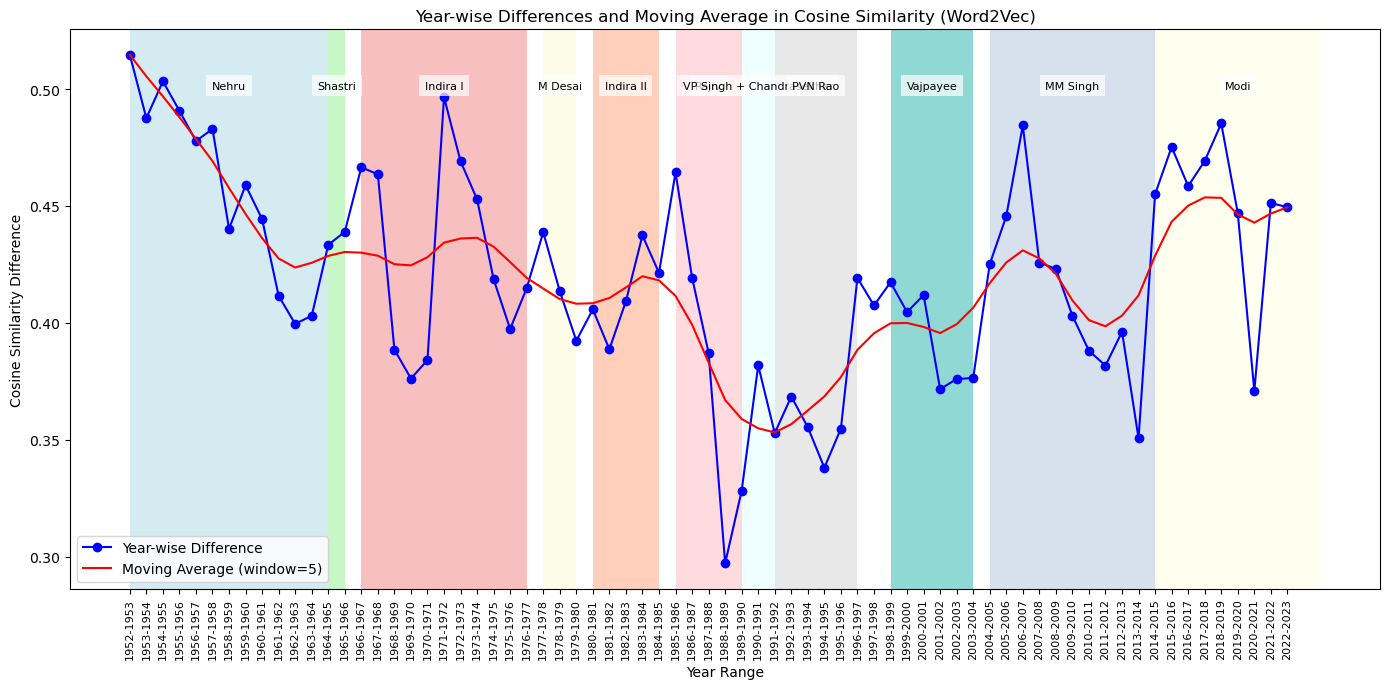

In [60]:
import matplotlib.pyplot as plt
from scipy.signal import filtfilt  # for moving average calculation

# Assuming `pm_avg_word_vectors_word2vec` and `compute_similarity` are already defined and available

# Compute year-wise differences in cosine similarity for Word2Vec model
year_wise_diff_word2vec = {}
years = sorted(pm_avg_word_vectors_word2vec.keys())
for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    sim_diff = compute_similarity(pm_avg_word_vectors_word2vec[prev_year], pm_avg_word_vectors_word2vec[curr_year])
    year_wise_diff_word2vec[(prev_year, curr_year)] = sim_diff

# Convert the results to lists for plotting
years_range = list(range(1952, 2023))  # Adjust for your data range
similarity_diffs_word2vec = [year_wise_diff_word2vec.get((year, year+1), None) for year in years_range]

# Define the PM terms with colors
pm_terms = {
    'Nehru': (1952, 1964, 'lightblue'),
    'Shastri': (1964, 1965, 'lightgreen'),
    'Indira I': (1966, 1976, 'lightcoral'),
    'M Desai': (1977, 1979, 'lightgoldenrodyellow'),
    'Indira II': (1980, 1984, 'lightsalmon'),
    'Rajiv': (1985, 1989, 'lightpink'),
    'VP Singh + Chandrasekhar': (1989, 1991, 'lightcyan'),
    'PVN Rao': (1991, 1996, 'lightgray'),
    'Vajpayee': (1998, 2003, 'lightseagreen'),
    'MM Singh': (2004, 2014, 'lightsteelblue'),
    'Modi': (2014, 2024, 'lightyellow')
}

# Function to add PM gridlines and labels
def add_pm_gridlines(ax, pm_terms):
    for pm, (start, end, color) in pm_terms.items():
        ax.axvspan(start, end, color=color, alpha=0.5, lw=0)  # Use different colors for PM terms
        ax.text((start + end) / 2, ax.get_ylim()[1] * 0.95, pm, ha='center', va='bottom', fontsize=8, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Define window size for moving average
window_size = 5  # Adjust this value as needed for smoothing

# Calculate moving average using filtfilt (more robust for filtering)
similarity_diffs_word2vec_ma = filtfilt([1 / window_size] * window_size, [1], similarity_diffs_word2vec)

# Use the original years_range for x-axis labels
year_range_labels_ma = [f"{year}-{year+1}" for year in years_range]

# Plot year-wise differences and moving average for Word2Vec
plt.figure(figsize=(14, 7))
plt.plot(years_range, similarity_diffs_word2vec, 'bo-', label='Year-wise Difference')
plt.plot(years_range, similarity_diffs_word2vec_ma, 'r-', label='Moving Average (window='+str(window_size)+')')
plt.title('Year-wise Differences and Moving Average in Cosine Similarity (Word2Vec)')
plt.xlabel('Year Range')
plt.ylabel('Cosine Similarity Difference')
plt.legend()
plt.xticks(years_range, year_range_labels_ma, rotation=90, fontsize=8)

# Remove gridlines as requested
plt.grid(False)

# Add PM gridlines and labels (assuming you still want them)
ax = plt.gca()
add_pm_gridlines(ax, pm_terms)

plt.tight_layout()
plt.show()


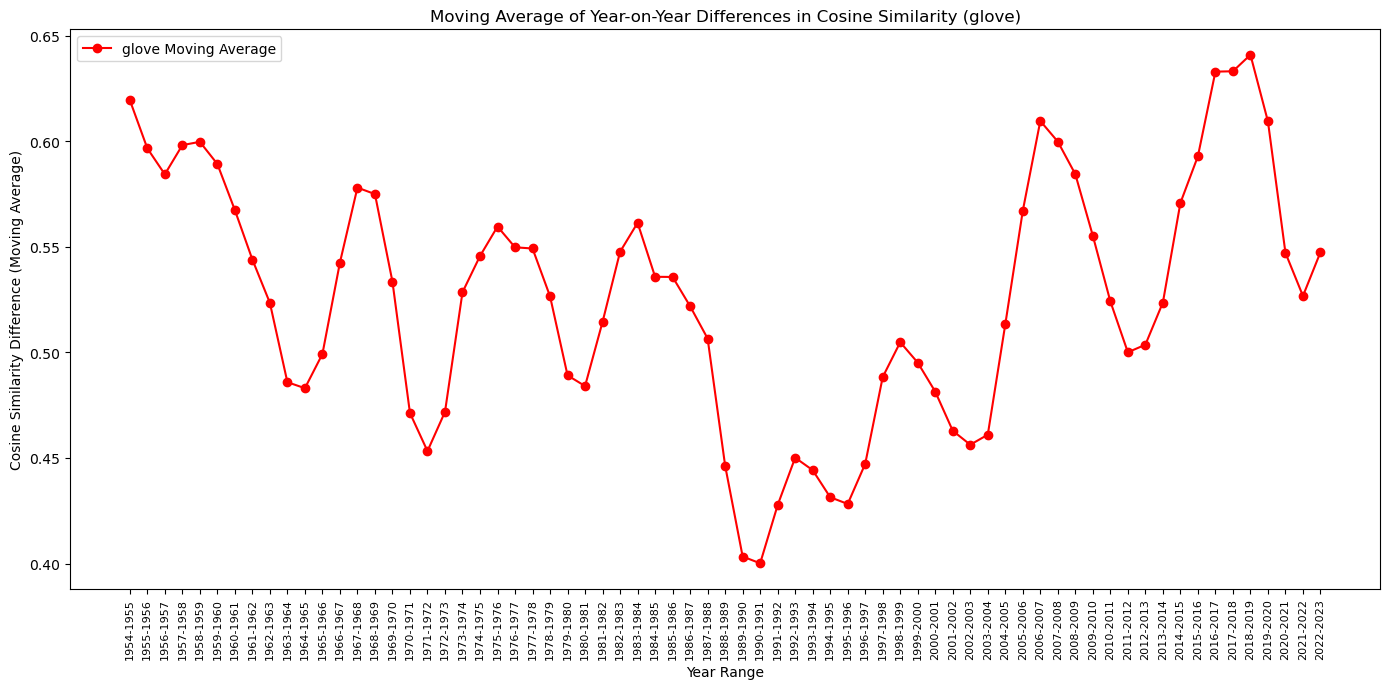

In [61]:
import numpy as np

# Compute the moving average for the similarity differences
window_size = 3  # You can adjust the window size for the moving average
moving_avg_glove = np.convolve(similarity_diffs_glove, np.ones(window_size)/window_size, mode='valid')

# Create year range labels for the moving average (since it's shorter by window_size-1)
moving_avg_year_range_labels = year_range_labels[window_size-1:]

# Plot the moving average graph
plt.figure(figsize=(14, 7))
plt.plot(moving_avg_year_range_labels, moving_avg_glove, 'ro-', label='glove Moving Average')
plt.title('Moving Average of Year-on-Year Differences in Cosine Similarity (glove)')
plt.xlabel('Year Range')
plt.ylabel('Cosine Similarity Difference (Moving Average)')
plt.legend()
plt.xticks(rotation=90, fontsize=8)
plt.grid(False)  # No grid lines
plt.tight_layout()
plt.show()


In [62]:
# Function to compute year-on-year similarities

def compute_year_on_year_similarity(similarities):
    years = sorted(similarities.keys())
    year_on_year_similarities = {}
    for i in range(1, len(years)):
        year1 = years[i - 1]
        year2 = years[i]
        similarity = similarities.get(year2, 0) - similarities.get(year1, 0)
        year_on_year_similarities[f"{year2}-{year1}"] = similarity
    return year_on_year_similarities

# Compute year-on-year similarities for PM data using GloVe and Word2Vec
year_on_year_similarities_glove = compute_year_on_year_similarity(results_glove)
year_on_year_similarities_word2vec = compute_year_on_year_similarity(results_word2vec)


In [63]:
# Function to compute moving average
def compute_moving_average(data, window_size):
    moving_averages = {}
    data_values = list(data.values())
    for i in range(len(data_values)):
        if i + 1 >= window_size:
            window = data_values[i + 1 - window_size:i + 1]
            moving_averages[list(data.keys())[i]] = np.mean(window)
    return moving_averages

# Compute moving averages with a window size of 3 (you can adjust this)
moving_avg_glove = compute_moving_average(year_on_year_similarities_glove, 3)
moving_avg_word2vec = compute_moving_average(year_on_year_similarities_word2vec, 3)


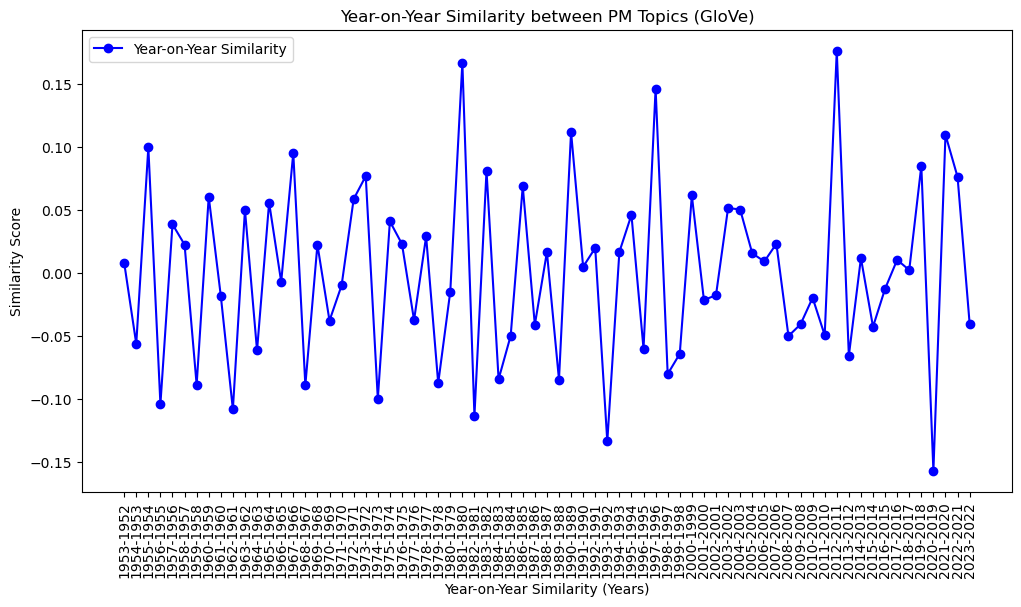

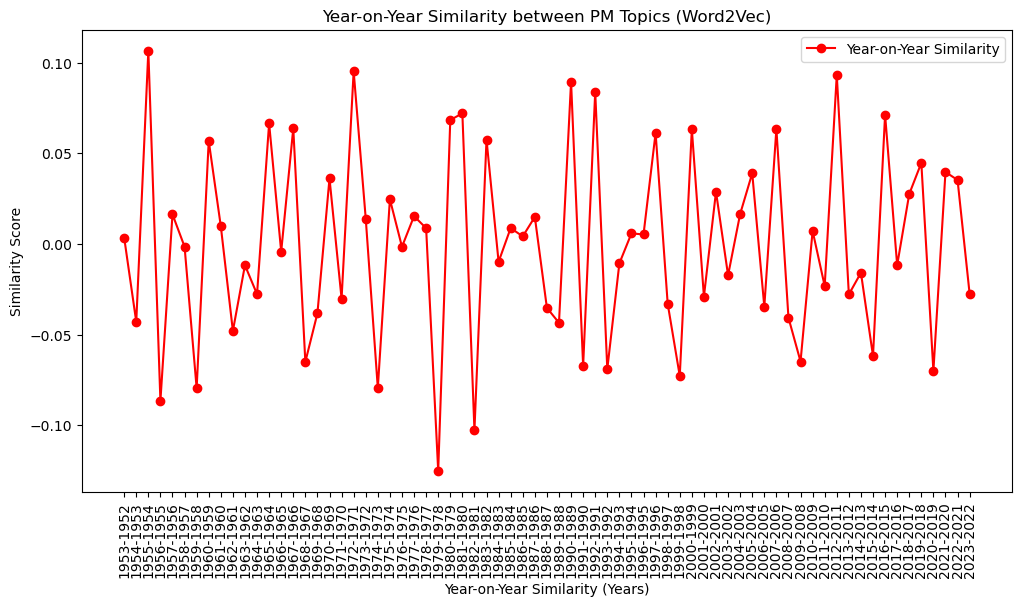

In [64]:
# Plot Year-on-Year Similarity
import matplotlib.pyplot as plt

def plot_year_on_year_similarity(similarities, title, color):
    plt.figure(figsize=(12, 6))
    years = list(similarities.keys())
    scores = list(similarities.values())
    plt.plot(years, scores, f'{color}o-', label='Year-on-Year Similarity')
    plt.title(title)
    plt.xlabel('Year-on-Year Similarity (Years)')
    plt.ylabel('Similarity Score')
    plt.xticks(rotation=90)
    plt.grid(False)
    plt.legend()
    plt.show()

# Plotting for GloVe and Word2Vec
plot_year_on_year_similarity(year_on_year_similarities_glove, 'Year-on-Year Similarity between PM Topics (GloVe)', 'b')
plot_year_on_year_similarity(year_on_year_similarities_word2vec, 'Year-on-Year Similarity between PM Topics (Word2Vec)', 'r')


In [65]:
# Inspecting extracted topics for a specific year
sample_year = 2023
print(f"Extracted topics for PM in {sample_year}: {pm_data[sample_year]}")
print(f"Extracted topics for President in {sample_year}: {president_data[sample_year]}")

# Inspecting preprocessed topics for a specific year
print(f"Preprocessed topics for PM in {sample_year}: {pm_processed_data[sample_year]}")
print(f"Preprocessed topics for President in {sample_year}: {president_processed_data[sample_year]}")

# Checking a sample word vector from each model
sample_word = "democracy"
print(f"GloVe vector for '{sample_word}': {glove_model[sample_word]}")
print(f"Word2Vec vector for '{sample_word}': {word2vec_model[sample_word]}")

# Compute similarity for a specific year and inspect individual similarities
year_to_check = 2023
pm_vectors = pm_avg_word_vectors_glove[year_to_check]
president_vectors = president_avg_word_vectors_glove[year_to_check]
similarities = []
for vec1 in pm_vectors:
    for vec2 in president_vectors:
        if np.linalg.norm(vec1) != 0 and np.linalg.norm(vec2) != 0:
            similarity = cosine_similarity([vec1], [vec2])
            similarities.append(similarity[0][0])
print(f"Individual similarities for {year_to_check} with GloVe: {similarities}")
print(f"Average similarity for {year_to_check} with GloVe: {np.mean(similarities)}")


Extracted topics for PM in 2023: [['"people"', '"today"', '"time"', '"world"', '"countryman"', '"family"', '"got"', '"trust"', '"due"', '"opportunity"'], ['"woman"', '"building"', '"bill"', '"worker"', '"today"', '"respected"', '"ganesh"', '"nation"', '"sengol"', '"chaturthi"'], ['"house"', '"respected"', '"bharat"', '"democracy"', '"building"', '"today"', '"nation"', '"strength"', '"world"', '"people"'], ['"golden"', '"today"', '"unparalleled"', '"born"', '"deserving"', '"unimaginable"', '"namaskar"', '"infuse"', '"house"', '"yesterday"'], ['"congress"', '"manipur"', '"respected"', '"people"', '"opposition"', '"politics"', '"want"', '"confidence"', '"bill"', '"motion"'], ['"respected"', '"house"', '"nation"', '"moment"', '"power"', '"sabha"', '"yesterday"', '"party"', '"nari"', '"vandan"'], ['"president"', '"world"', '"today"', '"class"', '"abuse"', '"middle"', '"got"', '"despair"', '"decade"', '"jammukashmir"']]
Extracted topics for President in 2023: [['"today"', '"world"', '"honora

In [66]:
# Function to remove subheadings
def remove_subheadings(topics):
    filtered_topics = []
    for topic in topics:
        filtered_topic = [word for word in topic if not word.startswith('"20') and not word.startswith(' "20')]
        filtered_topics.append(filtered_topic)
    return filtered_topics

In [67]:
# Function to preprocess the data
stop_words = set(stopwords.words('english'))
def preprocess(words):
    return [word.strip('"').lower() for word in words if word.strip('"').lower() not in stop_words and word not in string.punctuation and not word.strip('"').isdigit() and '_' not in word]

In [68]:
# Function to compute average word vectors
def average_word_vector(words, model, num_features):
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model:
            num_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

In [69]:
# Function to compute cosine similarity
def compute_similarity(year1_data, year2_data):
    similarities = []
    for vec1 in year1_data:
        for vec2 in year2_data:
            if np.linalg.norm(vec1) != 0 and np.linalg.norm(vec2) != 0: # Avoid zero vectors
                similarity = cosine_similarity([vec1], [vec2])
                similarities.append(similarity[0][0])
    return np.mean(similarities) if similarities else 0

In [70]:
# Paths to the documents
pm_file_path = r'C:\Users\HP\Documents\PM_LOK.docx'
president_file_path = r'C:\Users\HP\Documents\PRESLOK.docx'

In [71]:
# Extract and preprocess data
pm_data = extract_data_from_docx(pm_file_path)
president_data = extract_data_from_docx(president_file_path)

pm_data = {year: remove_subheadings(topics) for year, topics in pm_data.items()}
president_data = {year: remove_subheadings(topics) for year, topics in president_data.items()}

pm_processed_data = {year: [preprocess(topic) for topic in topics] for year, topics in pm_data.items()}
president_processed_data = {year: [preprocess(topic) for topic in topics] for year, topics in president_data.items()}

In [72]:
# Print the processed data for verification
print("Processed PM Data:")
for year, topics in pm_processed_data.items():
    print(f"Year {year}: {topics}")
print("\nProcessed President Data:")
for year, topics in president_processed_data.items():
    print(f"Year {year}: {topics}")


Processed PM Data:
Year 1952: [['thing', 'plan', 'people', 'great', 'house', 'war', 'think', 'planning', 'done', 'industry'], ['kashmir', 'state', 'people', 'matter', 'pakistan', 'jammu', 'constitution', 'thing', 'time', 'president'], ['sterling', 'conference', 'area', 'trade', 'reserve', 'policy', 'commonwealth', 'finance', 'finance', 'dollar'], ['province', 'andhra', 'matter', 'think', 'demand', 'linguistic', 'bengal', 'madras', 'thing', 'thing'], ['science', 'fascism', 'house', 'saha', 'particular', 'dignity', 'scientist', 'group', 'member', 'eminent'], ['bill', 'corporation', 'industrial', 'liven', 'matter', 'day', 'finance', 'abould', 'policy', 'baa'], ['food', 'control', 'situation', 'basic', 'state', 'policy', 'procurement', 'free', 'deficit', 'millet']]
Year 1953: [['world', 'fact', 'people', 'member', 'state', 'matter', 'think', 'democracy', 'house', 'nation'], ['state', 'andhra', 'madras', 'capital', 'decision', 'assembly', 'considered', 'people', 'service', 'financial'], ['h

Processed PM Data:
LS1: [['people', 'thing', 'think', 'matter', 'house', 'time', 'world', 'fact', 'problem', 'want'], ['pakistan', 'chinese', 'house', 'united', 'war', 'peace', 'world', 'kashmir', 'nation', 'force'], ['plan', 'planning', 'industry', 'price', 'sector', 'public', 'production', 'work', 'democracy', 'development'], ['state', 'language', 'andhra', 'bill', 'matter', 'constitution', 'court', 'territory', 'naga', 'hindi'], ['steel', 'people', 'true', 'madhok', 'constitution', 'bokaro', 'cost', 'capacity', 'political', 'sondhi']]
LS2: [['people', 'thing', 'matter', 'think', 'house', 'fact', 'world', 'time', 'question', 'course'], ['goa', 'bill', 'language', 'territory', 'action', 'case', 'goan', 'force', 'portuguese', 'special'], ['plan', 'cooperative', 'steel', 'world', 'industry', 'planning', 'problem', 'agriculture', 'farming', 'power'], ['iraq', 'aircraft', 'airport', 'president', 'escaped', 'child', 'indonesia', 'soekarno', 'traaedy', 'habbaniya'], ['maulana', 'azad', 'gre

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cosine similarity results with GloVe: {1: 0.6462301, 2: 0.5592404, 3: 0.5823999, 4: 0.5170389, 5: 0.5810754, 6: 0.54403037, 7: 0.5412742, 8: 0.50327283, 9: 0.59269744, 10: 0.51304895, 11: 0.4818322, 12: 0.5524387, 13: 0.6127822, 14: 0.627059, 15: 0.52694666, 16: 0.6247947, 17: 0.6053366}
Cosine similarity results with Word2Vec: {1: 0.46280962, 2: 0.3723325, 3: 0.3983227, 4: 0.39805233, 5: 0.41268253, 6: 0.37263784, 7: 0.3691084, 8: 0.38135946, 9: 0.42154953, 10: 0.3803664, 11: 0.3886883, 12: 0.4241605, 13: 0.42517, 14: 0.4463818, 15: 0.38010415, 16: 0.4328321, 17: 0.44845504}


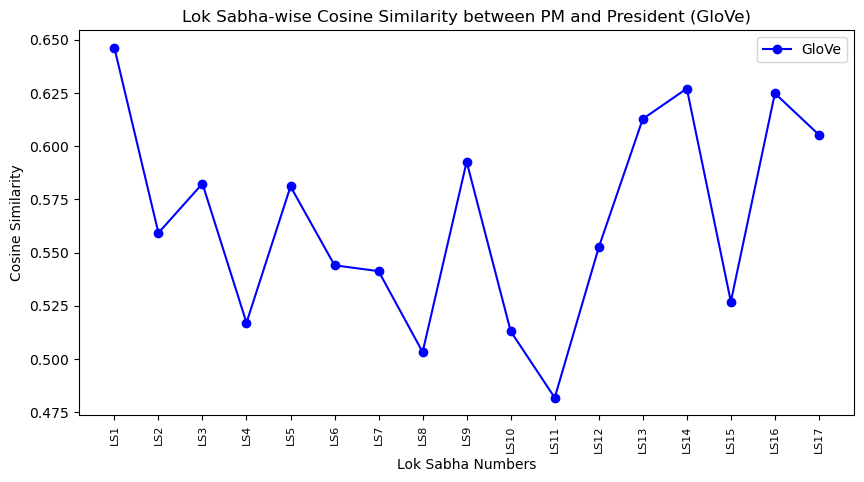

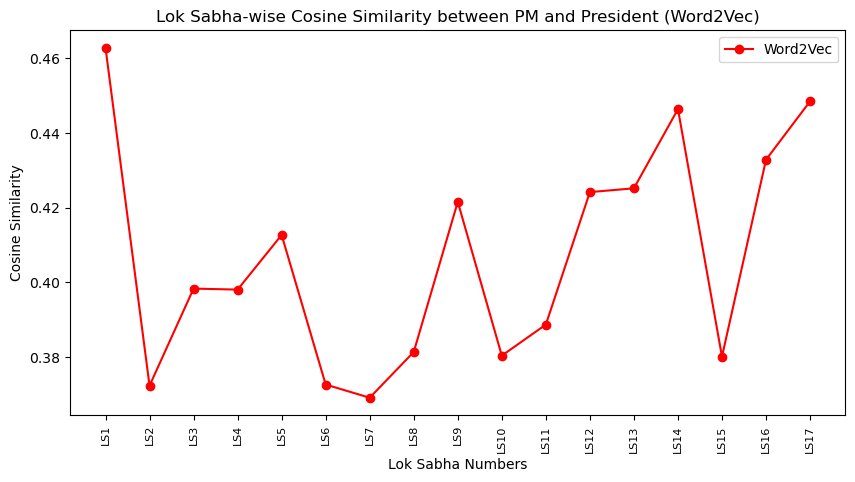

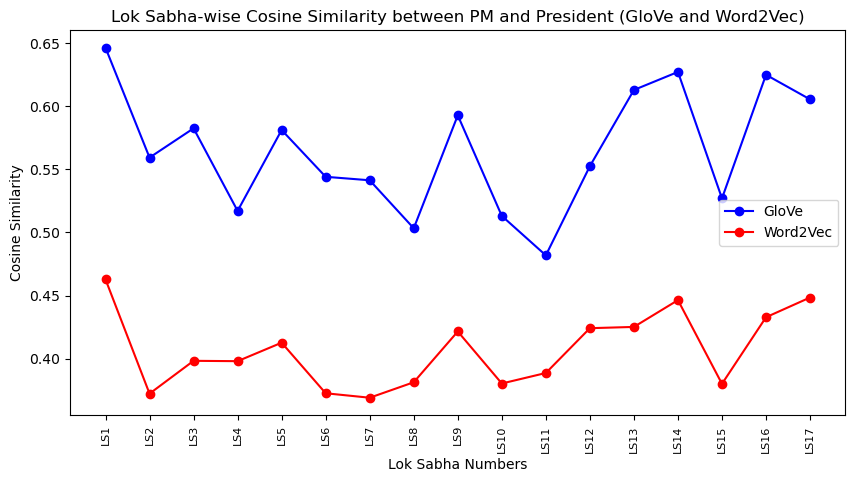

In [73]:
import nltk
from docx import Document
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import string
import matplotlib.pyplot as plt

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Function to extract data from a Word document
def extract_data_from_docx(file_path):
    doc = Document(file_path)
    data = {}
    current_ls = None
    for para in doc.paragraphs:
        line = para.text.strip()
        if line.startswith('LS'):  # Detect Lok Sabha lines
            try:
                current_ls = int(line.split()[1].replace(':', '').replace('th', '').replace('nd', '').replace('st', '').replace('rd', ''))
                data[current_ls] = []
            except (ValueError, IndexError):
                continue  # Skip this line if it doesn't match the expected format
        elif current_ls is not None and line.startswith('"') and line.endswith('"'):
            topic = [word.strip() for word in line.split(",")]
            data[current_ls].append(topic)
    return data

# Function to remove subheadings
def remove_subheadings(topics):
    filtered_topics = []
    for topic in topics:
        filtered_topic = [word for word in topic if not word.startswith('"D')]
        filtered_topics.append(filtered_topic)
    return filtered_topics

# Function to preprocess the data
stop_words = set(stopwords.words('english'))

def preprocess(words):
    return [word.strip('"').lower() for word in words 
            if word.strip('"').lower() not in stop_words 
            and word not in string.punctuation 
            and not word.strip('"').isdigit()]

# Function to compute average word vectors
def average_word_vector(words, model, num_features):
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model:
            num_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

# Function to compute cosine similarity
def compute_similarity(ls1_data, ls2_data):
    similarities = []
    for vec1 in ls1_data:
        for vec2 in ls2_data:
            if np.linalg.norm(vec1) != 0 and np.linalg.norm(vec2) != 0:  # Avoid zero vectors
                similarity = cosine_similarity([vec1], [vec2])
                similarities.append(similarity[0][0])
    return np.mean(similarities) if similarities else 0

# Paths to the documents
pm_file_path = 'C:/Users/HP/Documents/DYNAMIC TOPICS pm.docx'
president_file_path = 'C:/Users/HP/Documents/DYNAMIC TOPICS pres.docx'

# Extract and preprocess data
pm_data = extract_data_from_docx(pm_file_path)
president_data = extract_data_from_docx(president_file_path)
pm_data = {ls: remove_subheadings(topics) for ls, topics in pm_data.items()}
president_data = {ls: remove_subheadings(topics) for ls, topics in president_data.items()}
pm_processed_data = {ls: [preprocess(topic) for topic in topics] for ls, topics in pm_data.items()}
president_processed_data = {ls: [preprocess(topic) for topic in topics] for ls, topics in president_data.items()}

# Print the processed data for verification
print("Processed PM Data:")
for ls, topics in pm_processed_data.items():
    print(f"LS{ls}: {topics}")

print("\nProcessed President Data:")
for ls, topics in president_processed_data.items():
    print(f"LS{ls}: {topics}")

# Compute average word vectors (Assuming glove_model and word2vec_model are already loaded)
pm_avg_word_vectors_glove_Ls = {ls: [average_word_vector(topic, glove_model, 300) for topic in topics] for ls, topics in pm_processed_data.items()}
president_avg_word_vectors_glove_Ls = {ls: [average_word_vector(topic, glove_model, 300) for topic in topics] for ls, topics in president_processed_data.items()}
pm_avg_word_vectors_word2vec_Ls = {ls: [average_word_vector(topic, word2vec_model, 300) for topic in topics] for ls, topics in pm_processed_data.items()}
president_avg_word_vectors_word2vec_Ls = {ls: [average_word_vector(topic, word2vec_model, 300) for topic in topics] for ls, topics in president_processed_data.items()}

# Compute cosine similarity between PM and President for each Lok Sabha
results_glove = {}
results_word2vec = {}
loksabhas = set(pm_avg_word_vectors_glove_Ls.keys()).intersection(president_avg_word_vectors_glove_Ls.keys())
for ls in loksabhas:
    results_glove[ls] = compute_similarity(pm_avg_word_vectors_glove_Ls[ls], president_avg_word_vectors_glove_Ls[ls])
    results_word2vec[ls] = compute_similarity(pm_avg_word_vectors_word2vec_Ls[ls], president_avg_word_vectors_word2vec_Ls[ls])

print("Cosine similarity results with GloVe:", results_glove)
print("Cosine similarity results with Word2Vec:", results_word2vec)

loksabhas_range = list(range(1, 18))  # Lok Sabha numbers from 1 to 17
cosine_similarities_glove = [results_glove.get(ls, 0) for ls in loksabhas_range]
cosine_similarities_word2vec = [results_word2vec.get(ls, 0) for ls in loksabhas_range]

# Custom x-axis tick labels
loksabhas_labels = [f'LS{ls}' for ls in loksabhas_range]

# Plot GloVe cosine similarities
plt.figure(figsize=(10, 5))
plt.plot(loksabhas_range, cosine_similarities_glove, 'bo-', label='GloVe')
plt.title('Lok Sabha-wise Cosine Similarity between PM and President (GloVe)')
plt.xlabel('Lok Sabha Numbers')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.xticks(loksabhas_range, loksabhas_labels, rotation=90, fontsize=8)
plt.grid(False)
plt.show()

# Plot Word2Vec cosine similarities
plt.figure(figsize=(10, 5))
plt.plot(loksabhas_range, cosine_similarities_word2vec, 'ro-', label='Word2Vec')
plt.title('Lok Sabha-wise Cosine Similarity between PM and President (Word2Vec)')
plt.xlabel('Lok Sabha Numbers')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.xticks(loksabhas_range, loksabhas_labels, rotation=90, fontsize=8)
plt.grid(False)
plt.show()

# Plot both GloVe and Word2Vec cosine similarities
plt.figure(figsize=(10, 5))
plt.plot(loksabhas_range, cosine_similarities_glove, 'bo-', label='GloVe')
plt.plot(loksabhas_range, cosine_similarities_word2vec, 'ro-', label='Word2Vec')
plt.title('Lok Sabha-wise Cosine Similarity between PM and President (GloVe and Word2Vec)')
plt.xlabel('Lok Sabha Numbers')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.xticks(loksabhas_range, loksabhas_labels, rotation=90, fontsize=8)
plt.grid(False)
plt.show()


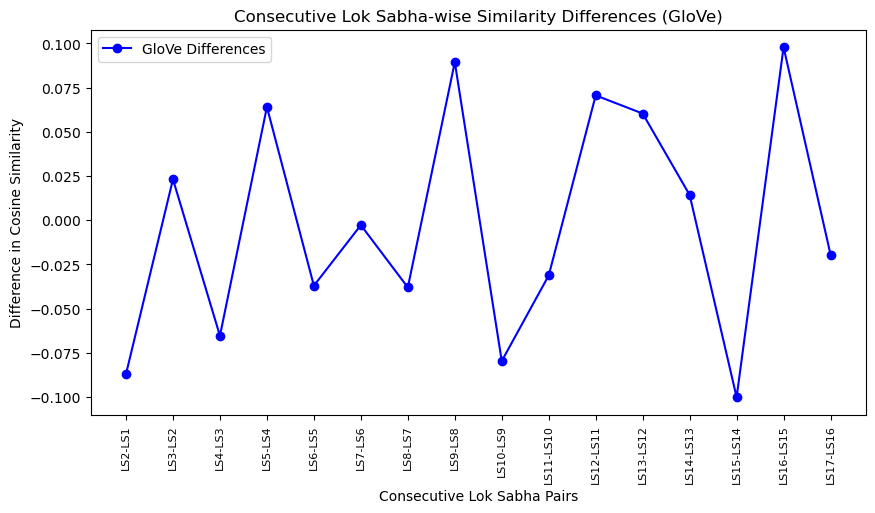

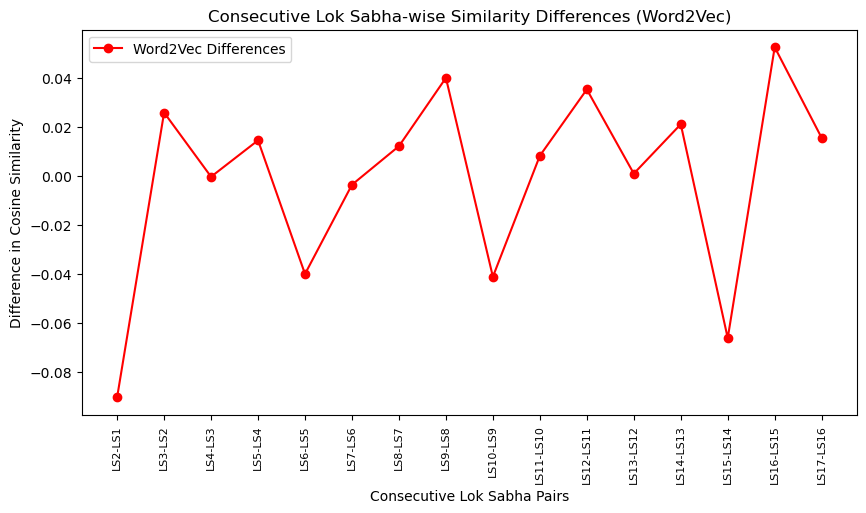

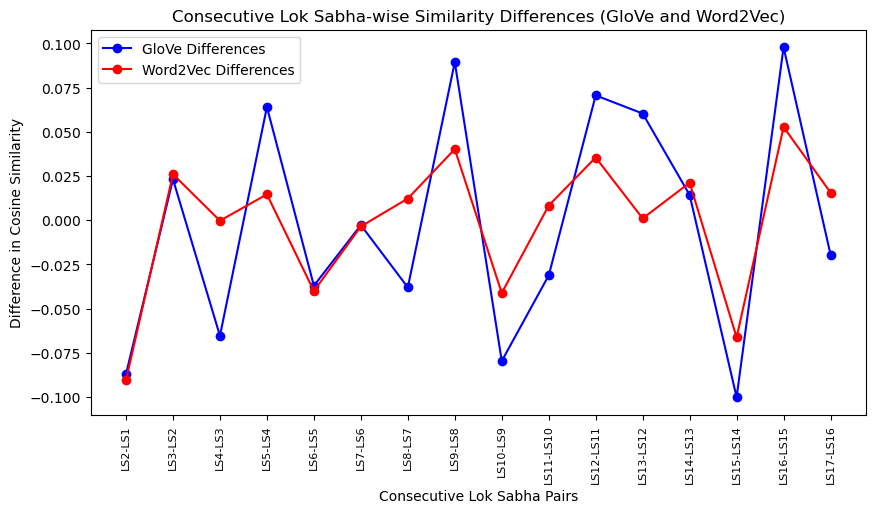

In [74]:
# Calculate consecutive differences for GloVe model
glove_diff = {}
word2vec_diff = {}

for i in range(2, 18):  # From LS2 to LS17
    diff_glove = results_glove.get(i, 0) - results_glove.get(i-1, 0)
    diff_word2vec = results_word2vec.get(i, 0) - results_word2vec.get(i-1, 0)
    
    glove_diff[f'LS{i}-LS{i-1}'] = diff_glove
    word2vec_diff[f'LS{i}-LS{i-1}'] = diff_word2vec

# Extract X and Y values for plotting
x_glove = list(glove_diff.keys())
y_glove = list(glove_diff.values())

x_word2vec = list(word2vec_diff.keys())
y_word2vec = list(word2vec_diff.values())

# Plot for GloVe consecutive differences
plt.figure(figsize=(10, 5))
plt.plot(x_glove, y_glove, 'bo-', label='GloVe Differences')
plt.title('Consecutive Lok Sabha-wise Similarity Differences (GloVe)')
plt.xlabel('Consecutive Lok Sabha Pairs')
plt.ylabel('Difference in Cosine Similarity')
plt.xticks(rotation=90, fontsize=8)
plt.grid(False)
plt.legend()
plt.show()

# Plot for Word2Vec consecutive differences
plt.figure(figsize=(10, 5))
plt.plot(x_word2vec, y_word2vec, 'ro-', label='Word2Vec Differences')
plt.title('Consecutive Lok Sabha-wise Similarity Differences (Word2Vec)')
plt.xlabel('Consecutive Lok Sabha Pairs')
plt.ylabel('Difference in Cosine Similarity')
plt.xticks(rotation=90, fontsize=8)
plt.grid(False)
plt.legend()
plt.show()

# Combined plot for GloVe and Word2Vec differences
plt.figure(figsize=(10, 5))
plt.plot(x_glove, y_glove, 'bo-', label='GloVe Differences')
plt.plot(x_word2vec, y_word2vec, 'ro-', label='Word2Vec Differences')
plt.title('Consecutive Lok Sabha-wise Similarity Differences (GloVe and Word2Vec)')
plt.xlabel('Consecutive Lok Sabha Pairs')
plt.ylabel('Difference in Cosine Similarity')
plt.xticks(rotation=90, fontsize=8)
plt.grid(False)
plt.legend()
plt.show()


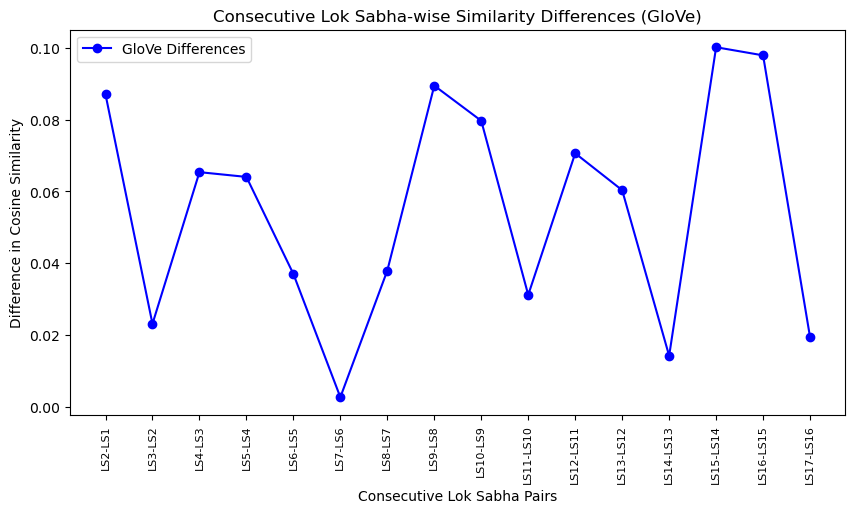

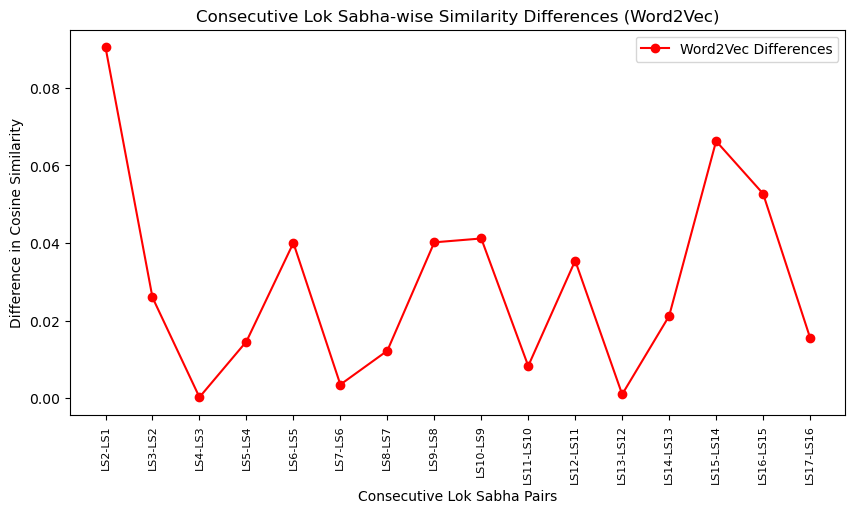

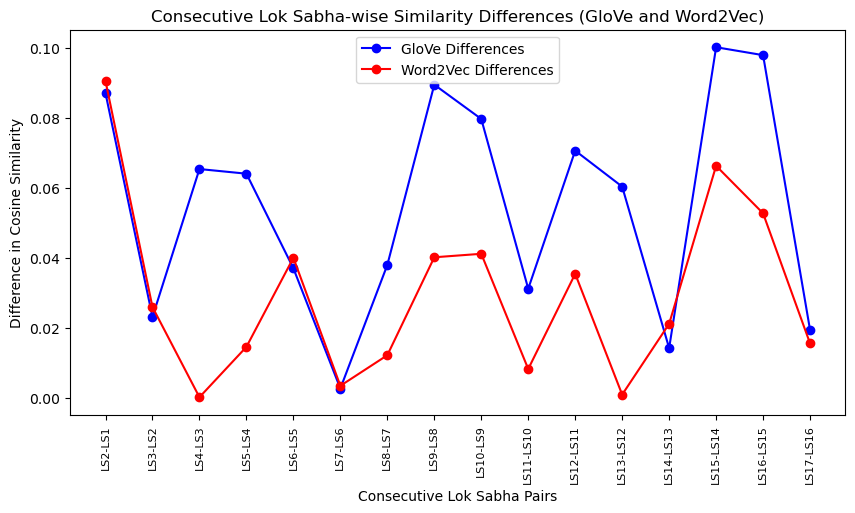

In [75]:
# Calculate consecutive differences for GloVe and Word2Vec models with modulus
glove_diff = {}
word2vec_diff = {}

for i in range(2, 18):  # From LS2 to LS17
    diff_glove = abs(results_glove.get(i, 0) - results_glove.get(i-1, 0))
    diff_word2vec = abs(results_word2vec.get(i, 0) - results_word2vec.get(i-1, 0))
    
    glove_diff[f'LS{i}-LS{i-1}'] = diff_glove
    word2vec_diff[f'LS{i}-LS{i-1}'] = diff_word2vec

# Extract X and Y values for plotting
x_glove = list(glove_diff.keys())
y_glove = list(glove_diff.values())

x_word2vec = list(word2vec_diff.keys())
y_word2vec = list(word2vec_diff.values())

# Plot for GloVe consecutive differences
plt.figure(figsize=(10, 5))
plt.plot(x_glove, y_glove, 'bo-', label='GloVe Differences')
plt.title('Consecutive Lok Sabha-wise Similarity Differences (GloVe)')
plt.xlabel('Consecutive Lok Sabha Pairs')
plt.ylabel('Difference in Cosine Similarity')
plt.xticks(rotation=90, fontsize=8)
plt.grid(False)
plt.legend()
plt.show()

# Plot for Word2Vec consecutive differences
plt.figure(figsize=(10, 5))
plt.plot(x_word2vec, y_word2vec, 'ro-', label='Word2Vec Differences')
plt.title('Consecutive Lok Sabha-wise Similarity Differences (Word2Vec)')
plt.xlabel('Consecutive Lok Sabha Pairs')
plt.ylabel('Difference in Cosine Similarity')
plt.xticks(rotation=90, fontsize=8)
plt.grid(False)
plt.legend()
plt.show()

# Combined plot for GloVe and Word2Vec differences
plt.figure(figsize=(10, 5))
plt.plot(x_glove, y_glove, 'bo-', label='GloVe Differences')
plt.plot(x_word2vec, y_word2vec, 'ro-', label='Word2Vec Differences')
plt.title('Consecutive Lok Sabha-wise Similarity Differences (GloVe and Word2Vec)')
plt.xlabel('Consecutive Lok Sabha Pairs')
plt.ylabel('Difference in Cosine Similarity')
plt.xticks(rotation=90, fontsize=8)
plt.grid(False)
plt.legend()
plt.show()


In [76]:
# Replace 'desired_year' with the specific year you want to print
desired_year = 2018

print("pm_avg_word_vectors_word2vec for year", desired_year, ":", pm_avg_word_vectors_word2vec[desired_year])
print("pm_avg_word_vectors_glove for year", desired_year, ":", pm_avg_word_vectors_glove[desired_year])

pm_avg_word_vectors_word2vec for year 2018 : [array([ 0.01599121,  0.0401001 , -0.05369263,  0.13510743,  0.00194092,
       -0.06440429,  0.01150055,  0.02575073,  0.0655487 , -0.0112915 ,
        0.06672058, -0.05411987, -0.04139709,  0.04112549, -0.13403015,
        0.11840668,  0.02674112,  0.08865204, -0.03166504, -0.0582901 ,
       -0.01428223, -0.00848389,  0.03477783, -0.05815277,  0.08308411,
       -0.08569336, -0.08000489,  0.0119873 ,  0.07385254, -0.04031982,
       -0.04612427, -0.00543213,  0.02094727,  0.07045899,  0.02108765,
        0.01213379,  0.08945923, -0.07518311,  0.08723144,  0.0703247 ,
        0.12302246, -0.0695282 ,  0.18532714,  0.01781006, -0.03712158,
       -0.09595947, -0.0336174 ,  0.03113403, -0.13647461,  0.00548096,
        0.06413575, -0.02190399,  0.10695801, -0.02199707, -0.07315063,
       -0.05695839, -0.124823  ,  0.04639282,  0.03880615, -0.11833496,
       -0.04533691,  0.01817551, -0.12424316, -0.02166748,  0.05413818,
        0.00768738

Glove model similarity graphs


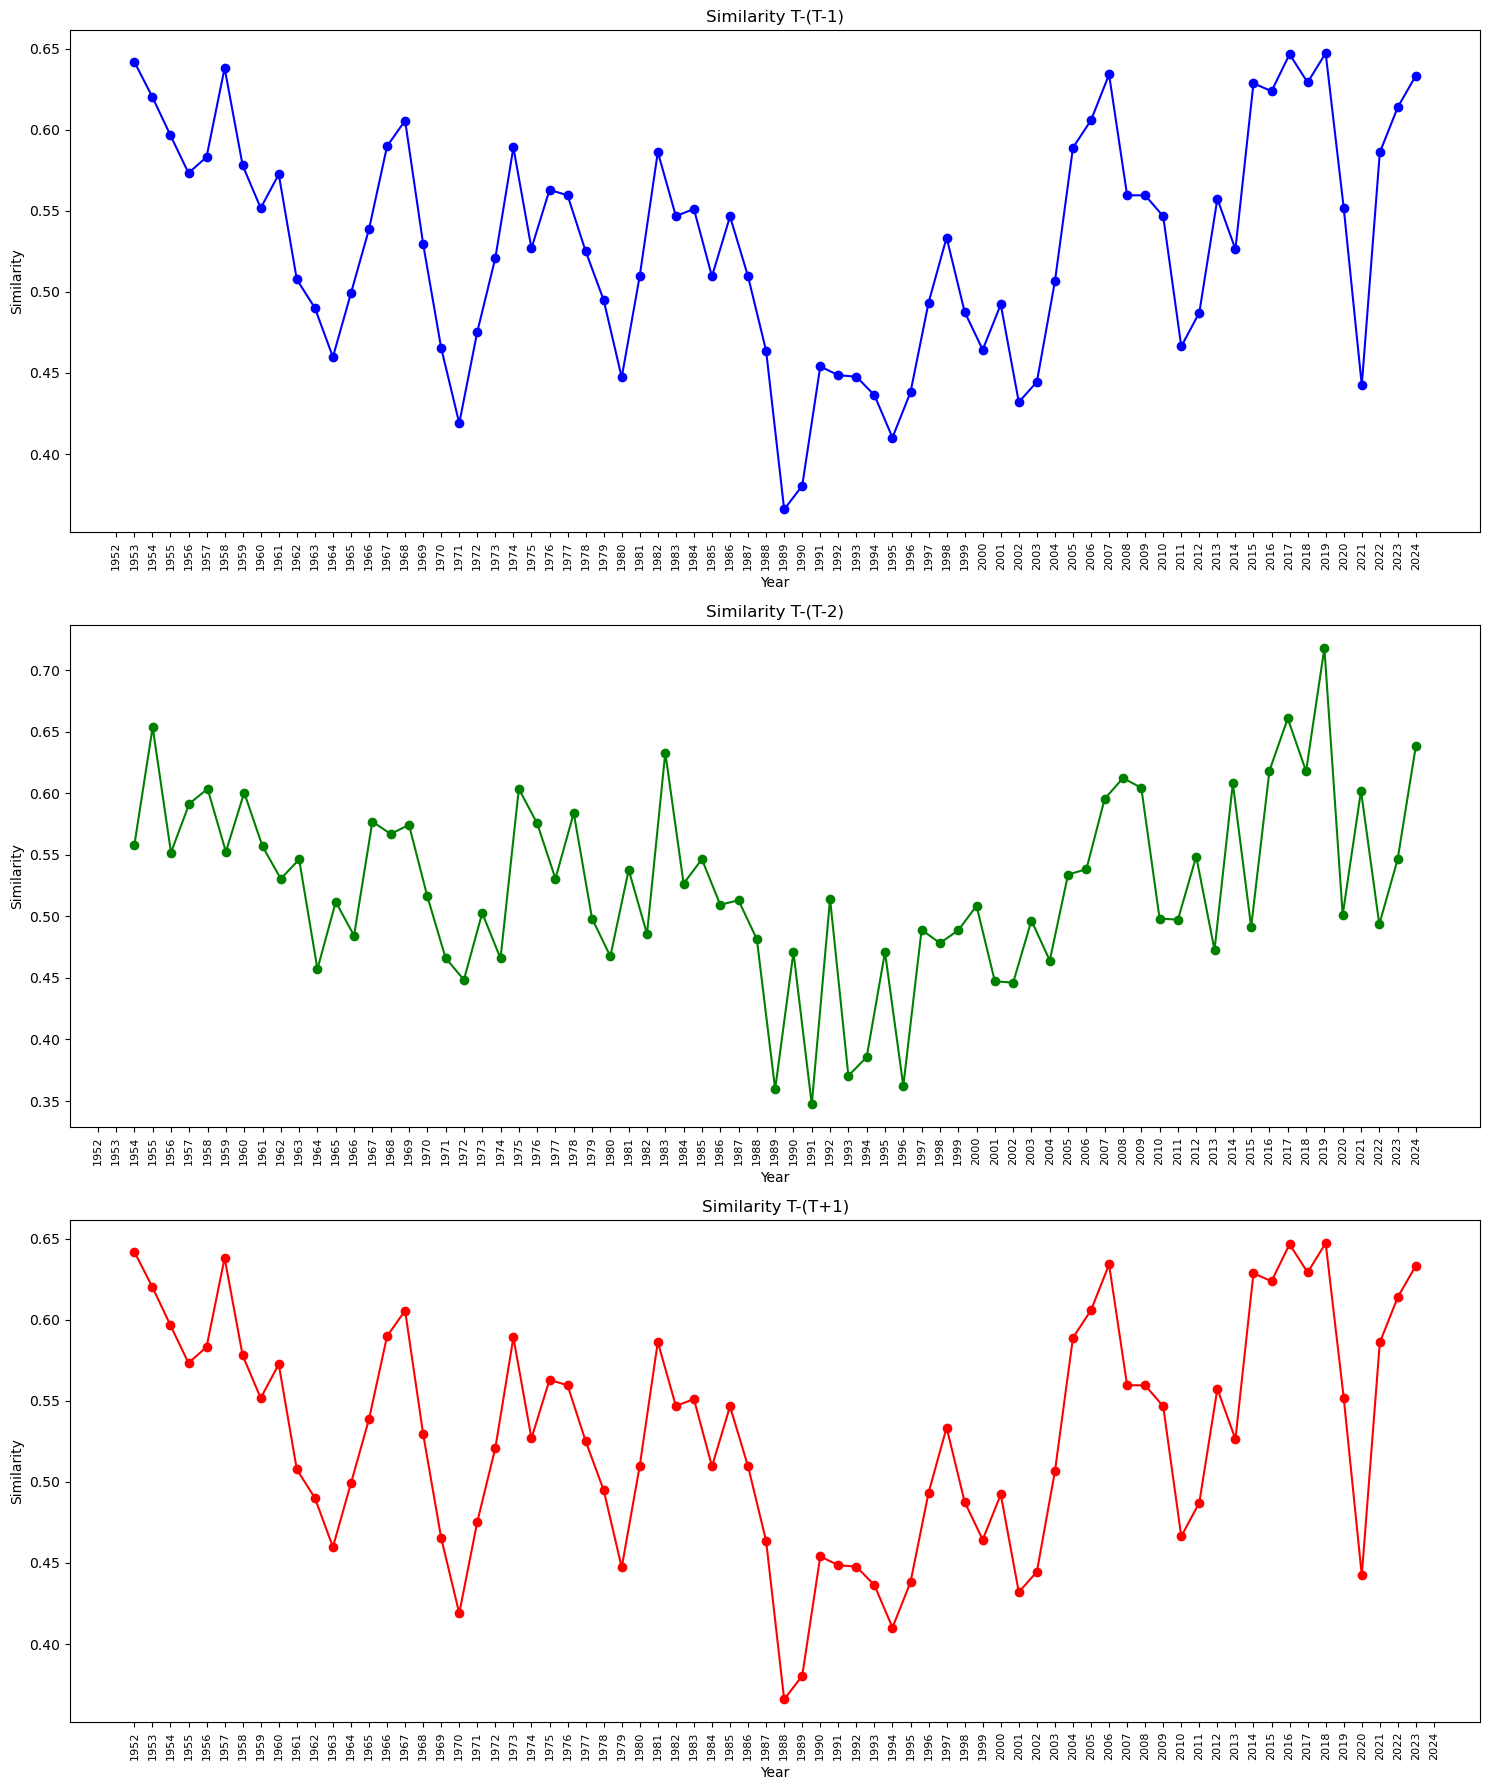

In [77]:
#glove
print("Glove model similarity graphs")
import numpy as np
import matplotlib.pyplot as plt

def analyze_election_years_pm(pm_avg_word_vectors):
    all_years = range(1952, 2025)  # Include all years from 1952 to 2024

    similarity_t_t1 = []
    similarity_t_t2 = []
    similarity_t_t1_plus = []

    for year in all_years:
        if year - 1 in pm_avg_word_vectors:
            similarity_t_t1.append(compute_similarity(pm_avg_word_vectors[year], pm_avg_word_vectors[year-1]))
        else:
            similarity_t_t1.append(None)

        if year - 2 in pm_avg_word_vectors:
            similarity_t_t2.append(compute_similarity(pm_avg_word_vectors[year], pm_avg_word_vectors[year-2]))
        else:
            similarity_t_t2.append(None)

        if year + 1 in pm_avg_word_vectors:
            similarity_t_t1_plus.append(compute_similarity(pm_avg_word_vectors[year], pm_avg_word_vectors[year+1]))
        else:
            similarity_t_t1_plus.append(None)

    return all_years, similarity_t_t1, similarity_t_t2, similarity_t_t1_plus

# Example usage
all_years, similarity_t_t1, similarity_t_t2, similarity_t_t1_plus = analyze_election_years_pm(pm_avg_word_vectors_glove)

# Plotting the graphs
fig, axs = plt.subplots(3, 1, figsize=(15, 18))  # Three subplots, one below the other

# Plot Similarity T-(T-1)
axs[0].plot(all_years, similarity_t_t1, 'b-o')
axs[0].set_title("Similarity T-(T-1)")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Similarity")
axs[0].set_xticks(all_years)
axs[0].tick_params(axis='x', rotation=90, labelsize=8)

# Plot Similarity T-(T-2)
axs[1].plot(all_years, similarity_t_t2, 'g-o')
axs[1].set_title("Similarity T-(T-2)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Similarity")
axs[1].set_xticks(all_years)
axs[1].tick_params(axis='x', rotation=90, labelsize=8)

# Plot Similarity T-(T+1)
axs[2].plot(all_years, similarity_t_t1_plus, 'r-o')
axs[2].set_title("Similarity T-(T+1)")
axs[2].set_xlabel("Year")
axs[2].set_ylabel("Similarity")
axs[2].set_xticks(all_years)
axs[2].tick_params(axis='x', rotation=90, labelsize=8)

plt.tight_layout()
plt.show()


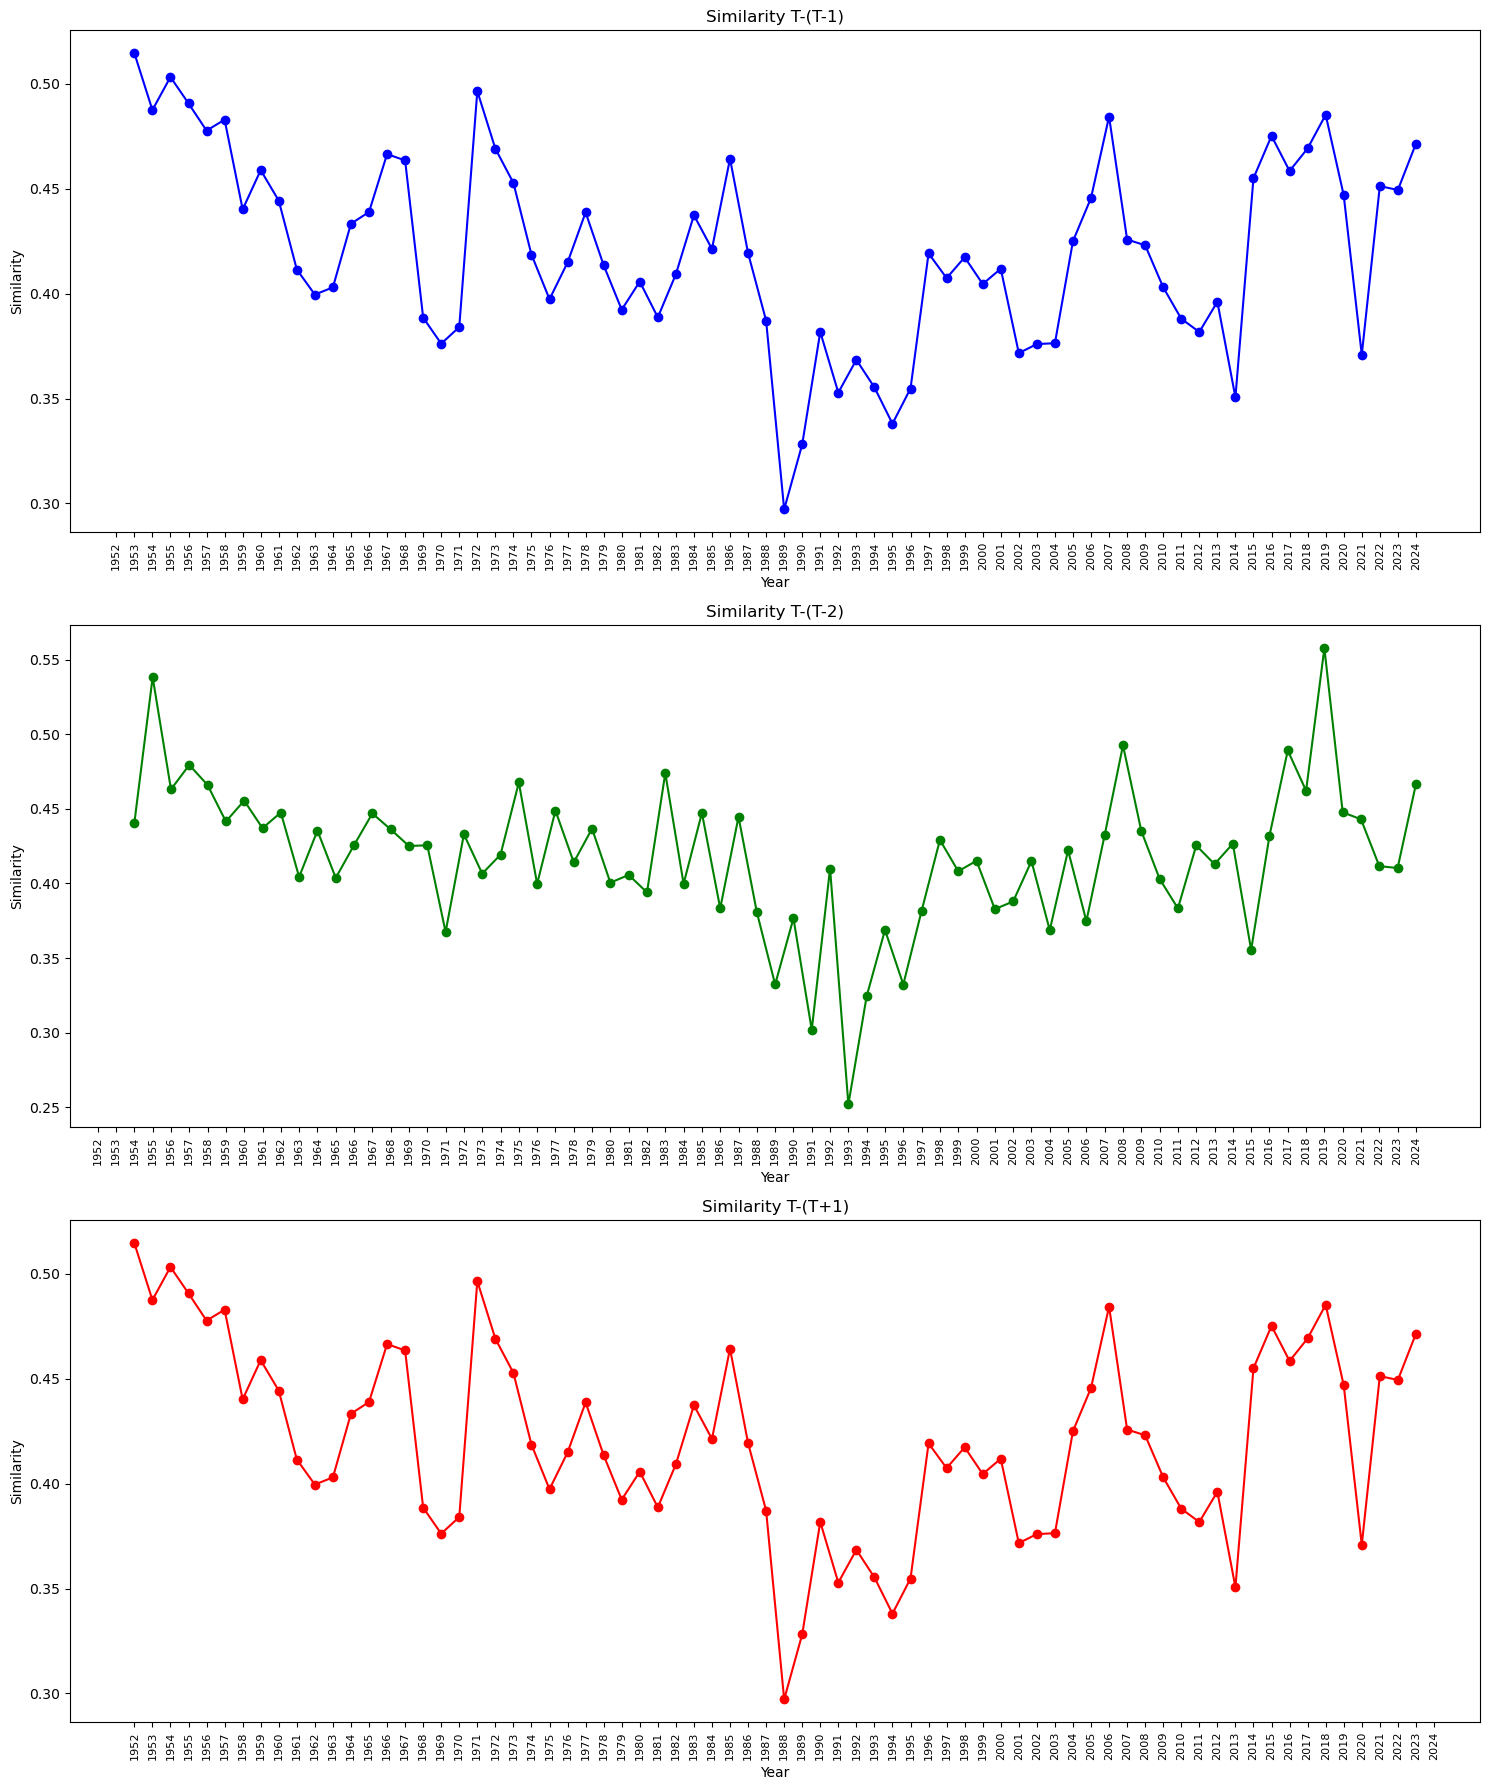

In [78]:
#word2vec
all_years, similarity_t_t1, similarity_t_t2, similarity_t_t1_plus = analyze_election_years_pm(pm_avg_word_vectors_word2vec)
# Plotting the graphs
fig, axs = plt.subplots(3, 1, figsize=(15, 18))  # Three subplots, one below the other

# Plot Similarity T-(T-1)
axs[0].plot(all_years, similarity_t_t1, 'b-o')
axs[0].set_title("Similarity T-(T-1)")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Similarity")
axs[0].set_xticks(all_years)
axs[0].tick_params(axis='x', rotation=90, labelsize=8)

# Plot Similarity T-(T-2)
axs[1].plot(all_years, similarity_t_t2, 'g-o')
axs[1].set_title("Similarity T-(T-2)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Similarity")
axs[1].set_xticks(all_years)
axs[1].tick_params(axis='x', rotation=90, labelsize=8)

# Plot Similarity T-(T+1)
axs[2].plot(all_years, similarity_t_t1_plus, 'r-o')
axs[2].set_title("Similarity T-(T+1)")
axs[2].set_xlabel("Year")
axs[2].set_ylabel("Similarity")
axs[2].set_xticks(all_years)
axs[2].tick_params(axis='x', rotation=90, labelsize=8)

plt.tight_layout()
plt.show()

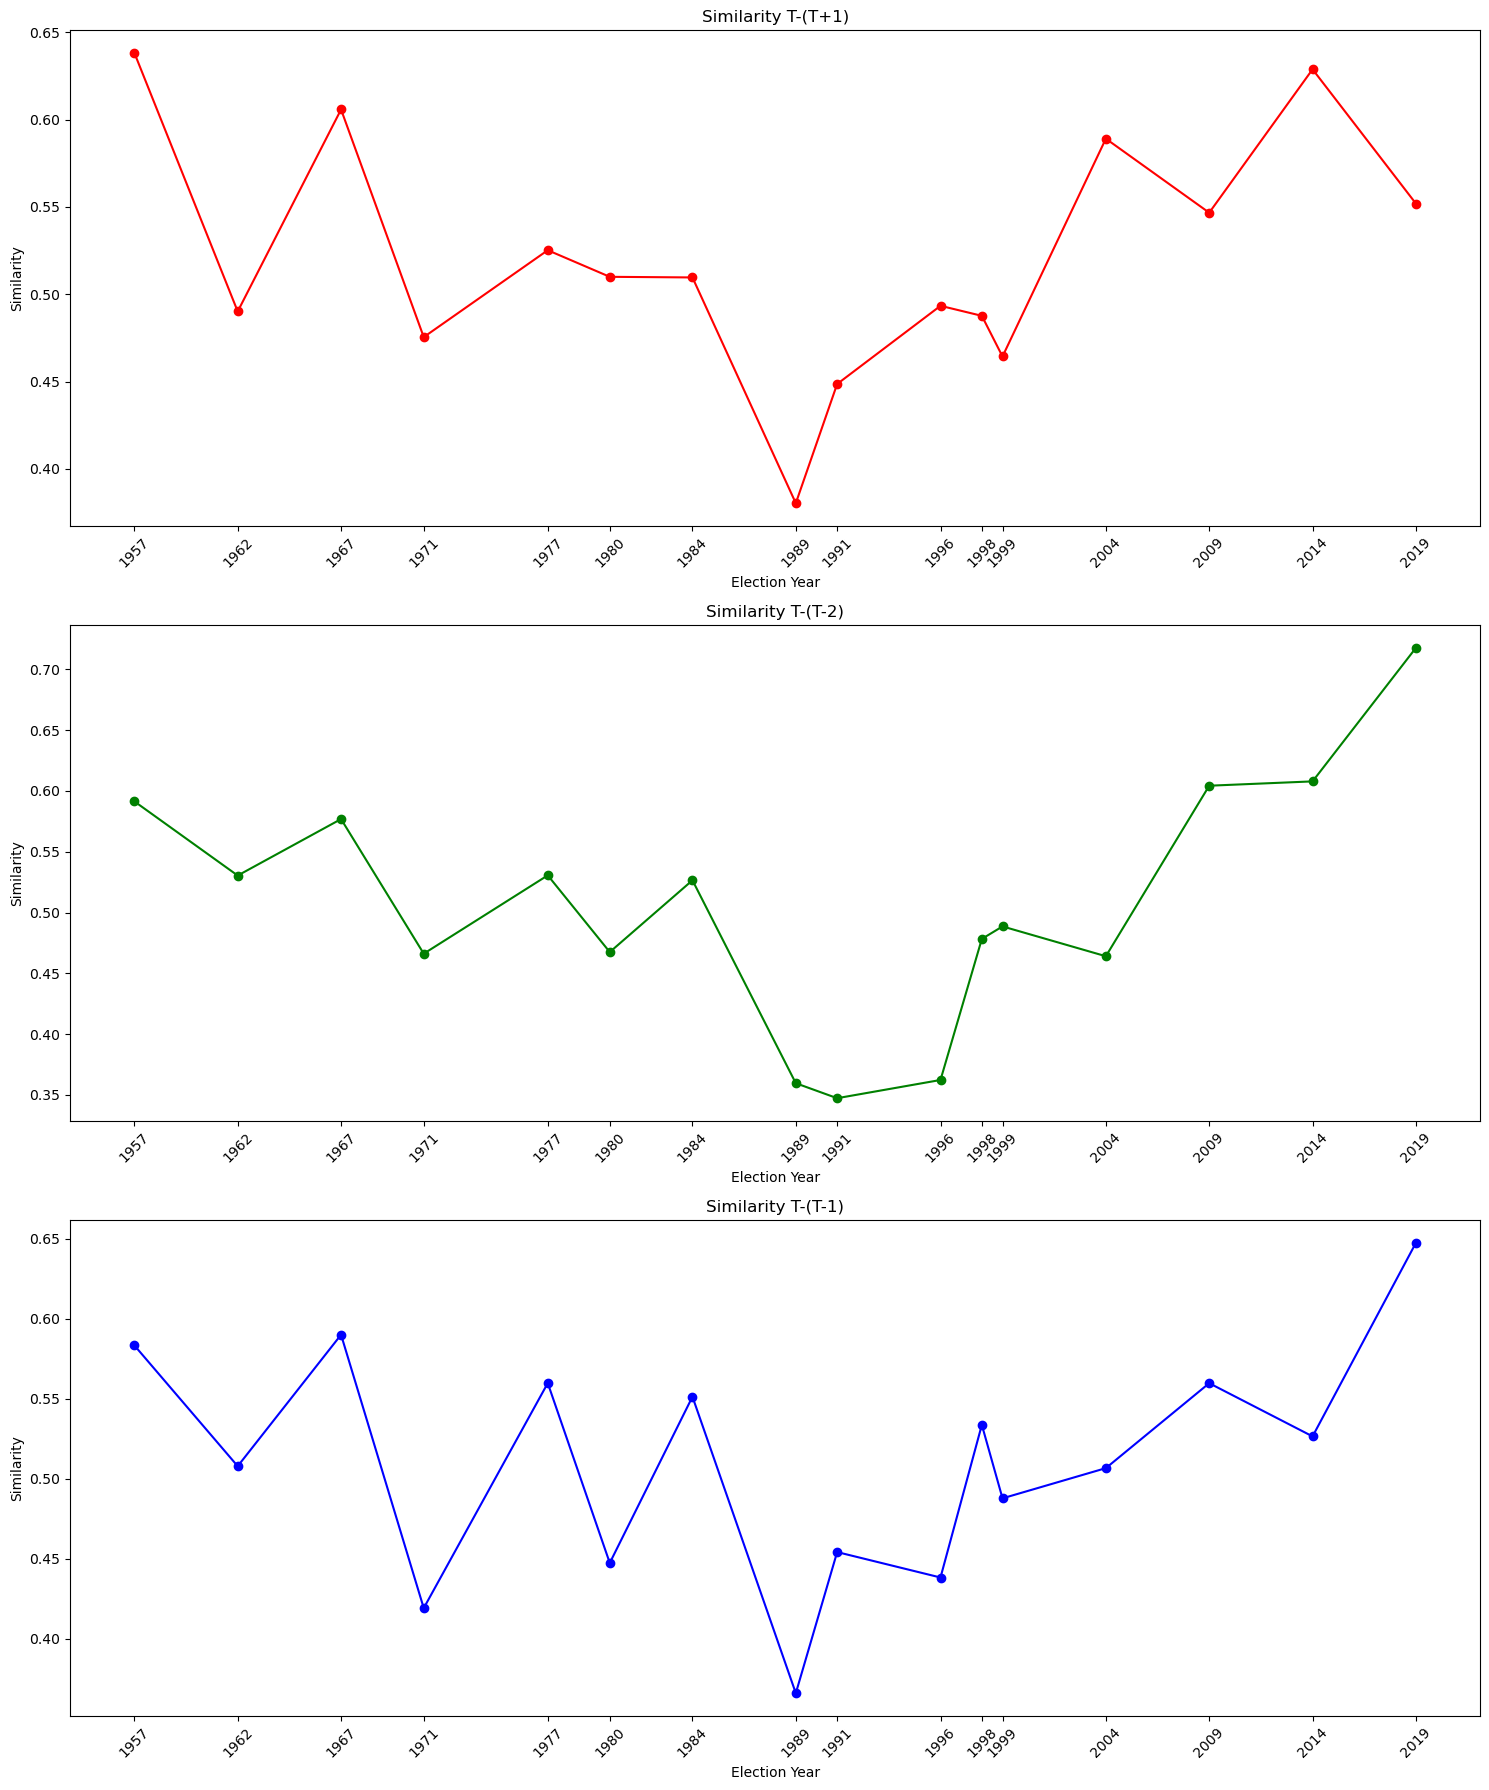

In [79]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_election_years_pm(pm_avg_word_vectors, election_years):
    similarity_t_t1 = []
    similarity_t_t2 = []
    similarity_t_t1_plus = []

    for year in election_years:
        # For T-(T-1)
        if year - 1 in pm_avg_word_vectors:
            similarity_t_t1.append(compute_similarity(pm_avg_word_vectors[year], pm_avg_word_vectors[year - 1]))
        else:
            similarity_t_t1.append(None)

        # For T-(T-2)
        if year - 2 in pm_avg_word_vectors:
            similarity_t_t2.append(compute_similarity(pm_avg_word_vectors[year], pm_avg_word_vectors[year - 2]))
        else:
            similarity_t_t2.append(None)

        # For T-(T+1)
        if year + 1 in pm_avg_word_vectors:
            similarity_t_t1_plus.append(compute_similarity(pm_avg_word_vectors[year], pm_avg_word_vectors[year + 1]))
        else:
            similarity_t_t1_plus.append(None)

    return similarity_t_t1, similarity_t_t2, similarity_t_t1_plus

# Define the election years
election_years = [1957, 1962, 1967, 1971, 1977, 1980, 1984, 1989, 1991, 1996, 1998, 1999, 2004, 2009, 2014, 2019]

# Example usage
similarity_t_t1, similarity_t_t2, similarity_t_t1_plus = analyze_election_years_pm(pm_avg_word_vectors_glove, election_years)

# Plotting the graphs
fig, axs = plt.subplots(3, 1, figsize=(15, 18))  # Three subplots, one below the other

# Plot Similarity T-(T+1)
axs[0].plot(election_years, similarity_t_t1_plus, 'r-o')
axs[0].set_title("Similarity T-(T+1)")
axs[0].set_xlabel("Election Year")
axs[0].set_ylabel("Similarity")
axs[0].set_xticks(election_years)
axs[0].tick_params(axis='x', rotation=45, labelsize=10)

# Plot Similarity T-(T-2)
axs[1].plot(election_years, similarity_t_t2, 'g-o')
axs[1].set_title("Similarity T-(T-2)")
axs[1].set_xlabel("Election Year")
axs[1].set_ylabel("Similarity")
axs[1].set_xticks(election_years)
axs[1].tick_params(axis='x', rotation=45, labelsize=10)

# Plot Similarity T-(T-1)
axs[2].plot(election_years, similarity_t_t1, 'b-o')
axs[2].set_title("Similarity T-(T-1)")
axs[2].set_xlabel("Election Year")
axs[2].set_ylabel("Similarity")
axs[2].set_xticks(election_years)
axs[2].tick_params(axis='x', rotation=45, labelsize=10)

plt.tight_layout()
plt.show()


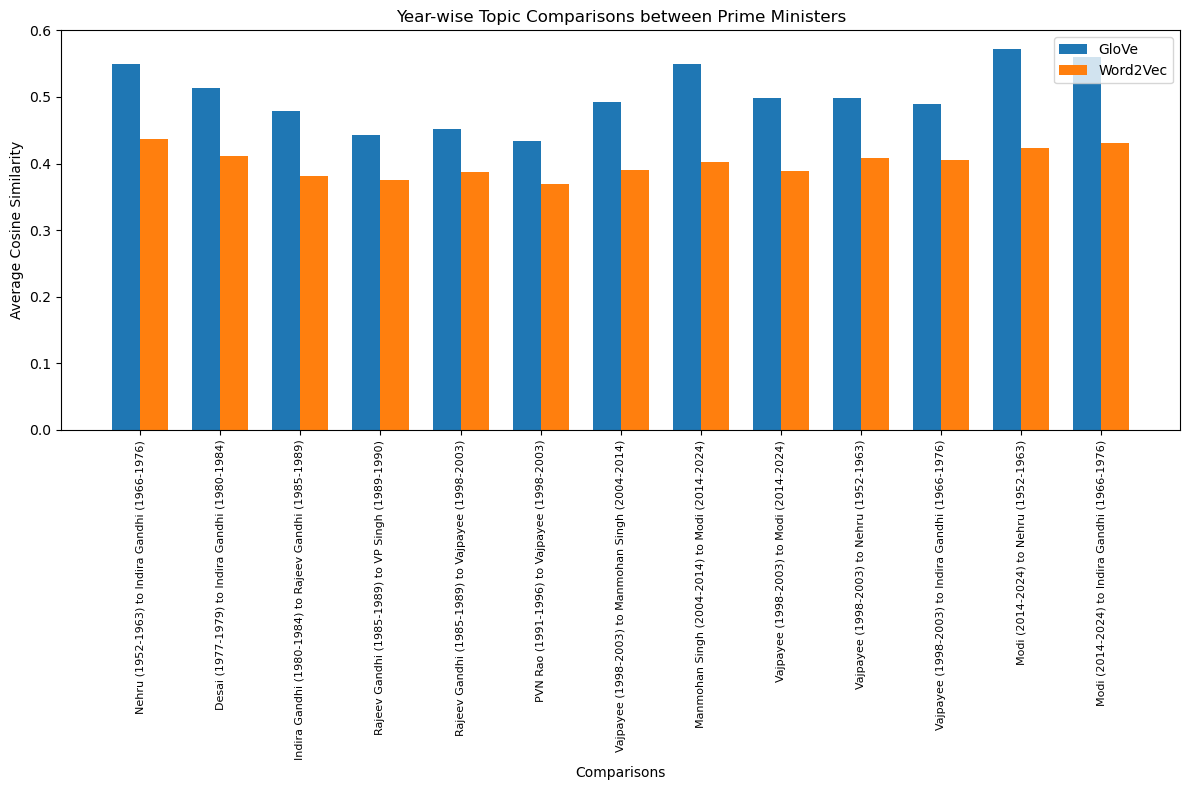

In [80]:
def compare_yearwise_topics(pm_avg_word_vectors, years_range1, years_range2, model_name="GloVe"):
    similarities = []
    
    for year1 in years_range1:
        for year2 in years_range2:
            if year1 in pm_avg_word_vectors and year2 in pm_avg_word_vectors:
                similarity = compute_similarity(pm_avg_word_vectors[year1], pm_avg_word_vectors[year2])
                similarities.append(similarity)
    
    avg_similarity = np.mean(similarities) if similarities else 0
    return avg_similarity

# Specify the year ranges for different PMs
comparisons = [
    ("Nehru (1952-1963) to Indira Gandhi (1966-1976)", list(range(1952, 1964)), list(range(1966, 1977))),
    ("Desai (1977-1979) to Indira Gandhi (1980-1984)", list(range(1977, 1980)), list(range(1980, 1985))),
    ("Indira Gandhi (1980-1984) to Rajeev Gandhi (1985-1989)", list(range(1980, 1985)), list(range(1985, 1990))),
    ("Rajeev Gandhi (1985-1989) to VP Singh (1989-1990)", list(range(1985, 1990)), list(range(1989, 1991))),
    ("Rajeev Gandhi (1985-1989) to Vajpayee (1998-2003)", list(range(1985, 1990)), list(range(1998, 2004))),
    ("PVN Rao (1991-1996) to Vajpayee (1998-2003)", list(range(1991, 1997)), list(range(1998, 2004))),
    ("Vajpayee (1998-2003) to Manmohan Singh (2004-2014)", list(range(1998, 2004)), list(range(2004, 2015))),
    ("Manmohan Singh (2004-2014) to Modi (2014-2024)", list(range(2004, 2015)), list(range(2014, 2025))),
    ("Vajpayee (1998-2003) to Modi (2014-2024)", list(range(1998, 2004)), list(range(2014, 2025))),
    ("Vajpayee (1998-2003) to Nehru (1952-1963)", list(range(1998, 2004)), list(range(1952, 1964))),
    ("Vajpayee (1998-2003) to Indira Gandhi (1966-1976)", list(range(1998, 2004)), list(range(1966, 1977))),
    ("Modi (2014-2024) to Nehru (1952-1963)", list(range(2014, 2025)), list(range(1952, 1964))),
    ("Modi (2014-2024) to Indira Gandhi (1966-1976)", list(range(2014, 2025)), list(range(1966, 1977)))
]

# Calculate similarities and plot them for both GloVe and Word2Vec
similarities_glove = []
similarities_word2vec = []
labels = []

for label, range1, range2 in comparisons:
    avg_similarity_glove = compare_yearwise_topics(pm_avg_word_vectors_glove, range1, range2, "GloVe")
    avg_similarity_word2vec = compare_yearwise_topics(pm_avg_word_vectors_word2vec, range1, range2, "Word2Vec")
    
    similarities_glove.append(avg_similarity_glove)
    similarities_word2vec.append(avg_similarity_word2vec)
    labels.append(label)

# Plot the results
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, similarities_glove, width, label='GloVe')
rects2 = ax.bar(x + width/2, similarities_word2vec, width, label='Word2Vec')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Comparisons')
ax.set_ylabel('Average Cosine Similarity')
ax.set_title('Year-wise Topic Comparisons between Prime Ministers')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=8)
ax.legend()

fig.tight_layout()

plt.show()


In [81]:
pip install -U notebook-as-pdf

Note: you may need to restart the kernel to use updated packages.


In [82]:
pip install nbconvert


Note: you may need to restart the kernel to use updated packages.


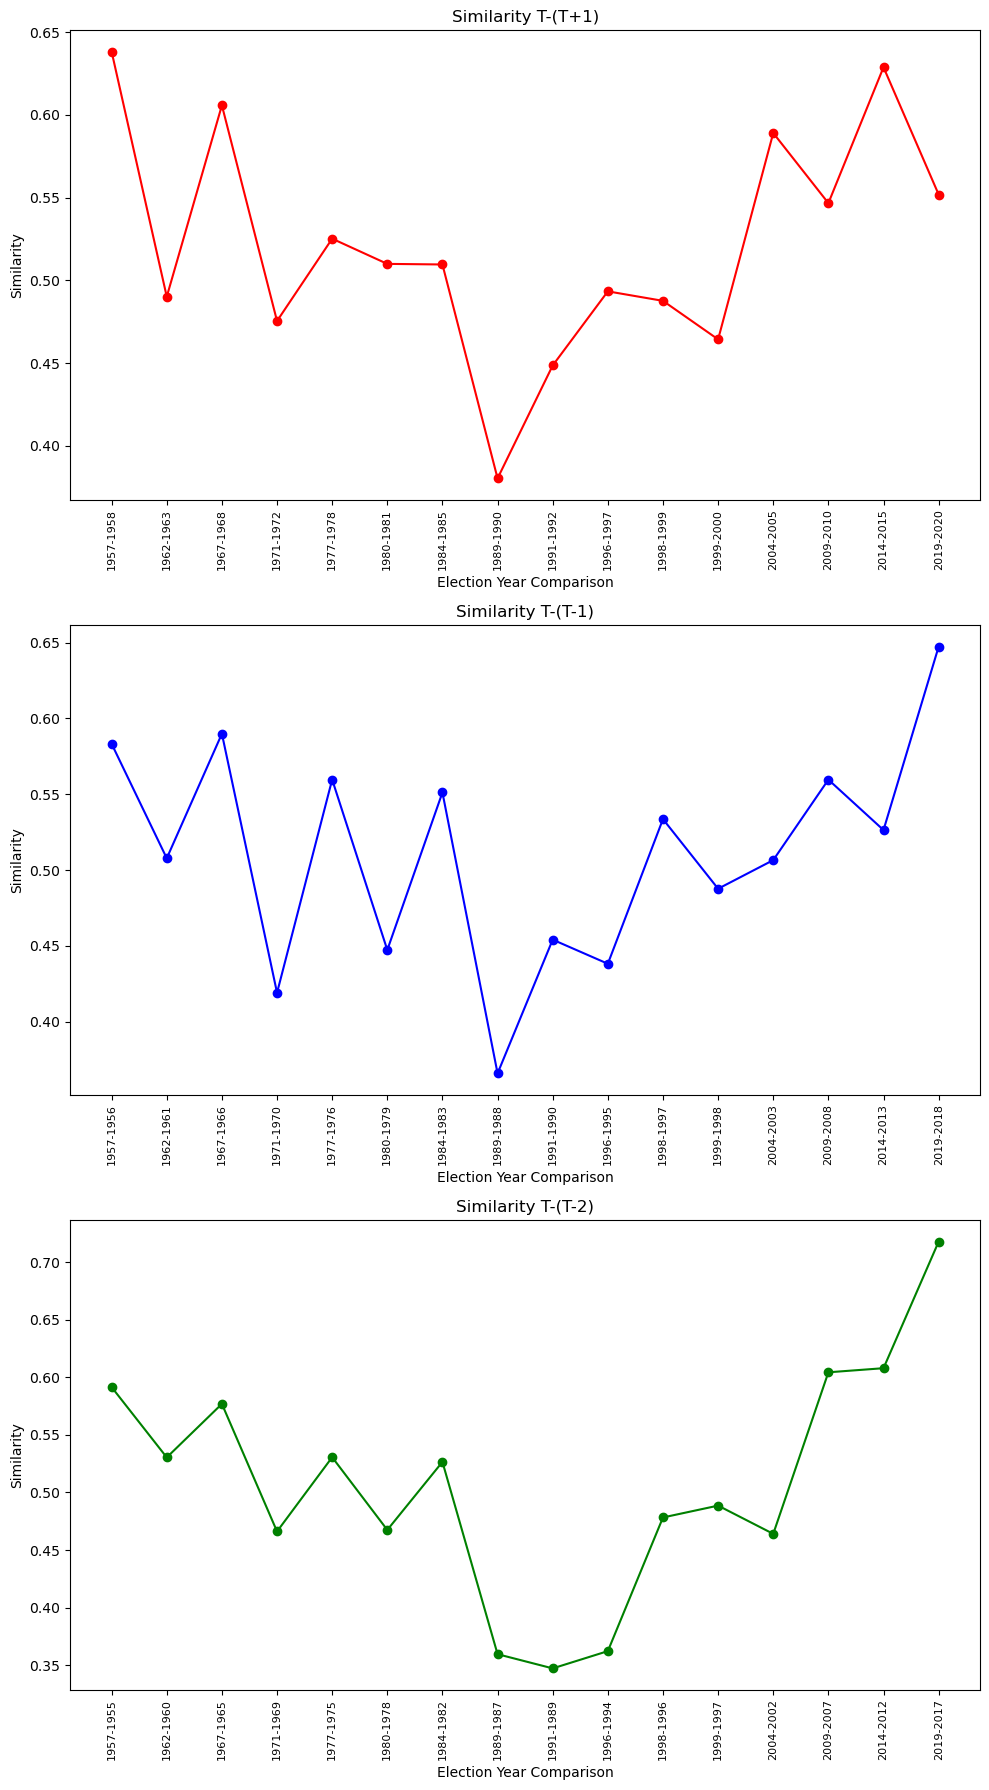

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_election_years_pm(pm_avg_word_vectors, election_years):
    similarity_t_t1 = []
    similarity_t_t2 = []
    similarity_t_t1_plus = []

    year_labels_t_t1 = []
    year_labels_t_t2 = []
    year_labels_t_t1_plus = []

    for year in election_years:
        if year - 1 in pm_avg_word_vectors:
            similarity_t_t1.append(compute_similarity(pm_avg_word_vectors[year], pm_avg_word_vectors[year-1]))
            year_labels_t_t1.append(f"{year}-{year-1}")
        else:
            similarity_t_t1.append(None)
            year_labels_t_t1.append(f"{year}-{year-1}")

        if year - 2 in pm_avg_word_vectors:
            similarity_t_t2.append(compute_similarity(pm_avg_word_vectors[year], pm_avg_word_vectors[year-2]))
            year_labels_t_t2.append(f"{year}-{year-2}")
        else:
            similarity_t_t2.append(None)
            year_labels_t_t2.append(f"{year}-{year-2}")

        if year + 1 in pm_avg_word_vectors:
            similarity_t_t1_plus.append(compute_similarity(pm_avg_word_vectors[year], pm_avg_word_vectors[year+1]))
            year_labels_t_t1_plus.append(f"{year}-{year+1}")
        else:
            similarity_t_t1_plus.append(None)
            year_labels_t_t1_plus.append(f"{year}-{year+1}")

    return (year_labels_t_t1, similarity_t_t1), (year_labels_t_t2, similarity_t_t2), (year_labels_t_t1_plus, similarity_t_t1_plus)

# Example usage
election_years = [1957, 1962, 1967, 1971, 1977, 1980, 1984, 1989, 1991, 1996, 1998, 1999, 2004, 2009, 2014, 2019]

(similarity_labels_t_t1, similarity_t_t1), (similarity_labels_t_t2, similarity_t_t2), (similarity_labels_t_t1_plus, similarity_t_t1_plus) = analyze_election_years_pm(pm_avg_word_vectors_glove, election_years)

# Plotting the graphs
fig, axs = plt.subplots(3, 1, figsize=(10, 18))  # Three subplots, one below the other

# Plot Similarity T-(T+1)
axs[0].plot(similarity_labels_t_t1_plus, similarity_t_t1_plus, 'r-o')
axs[0].set_title("Similarity T-(T+1)")
axs[0].set_xlabel("Election Year Comparison")
axs[0].set_ylabel("Similarity")
axs[0].tick_params(axis='x', rotation=90, labelsize=8)

# Plot Similarity T-(T-1)
axs[1].plot(similarity_labels_t_t1, similarity_t_t1, 'b-o')
axs[1].set_title("Similarity T-(T-1)")
axs[1].set_xlabel("Election Year Comparison")
axs[1].set_ylabel("Similarity")
axs[1].tick_params(axis='x', rotation=90, labelsize=8)

# Plot Similarity T-(T-2)
axs[2].plot(similarity_labels_t_t2, similarity_t_t2, 'g-o')
axs[2].set_title("Similarity T-(T-2)")
axs[2].set_xlabel("Election Year Comparison")
axs[2].set_ylabel("Similarity")
axs[2].tick_params(axis='x', rotation=90, labelsize=8)

plt.tight_layout()
plt.show()


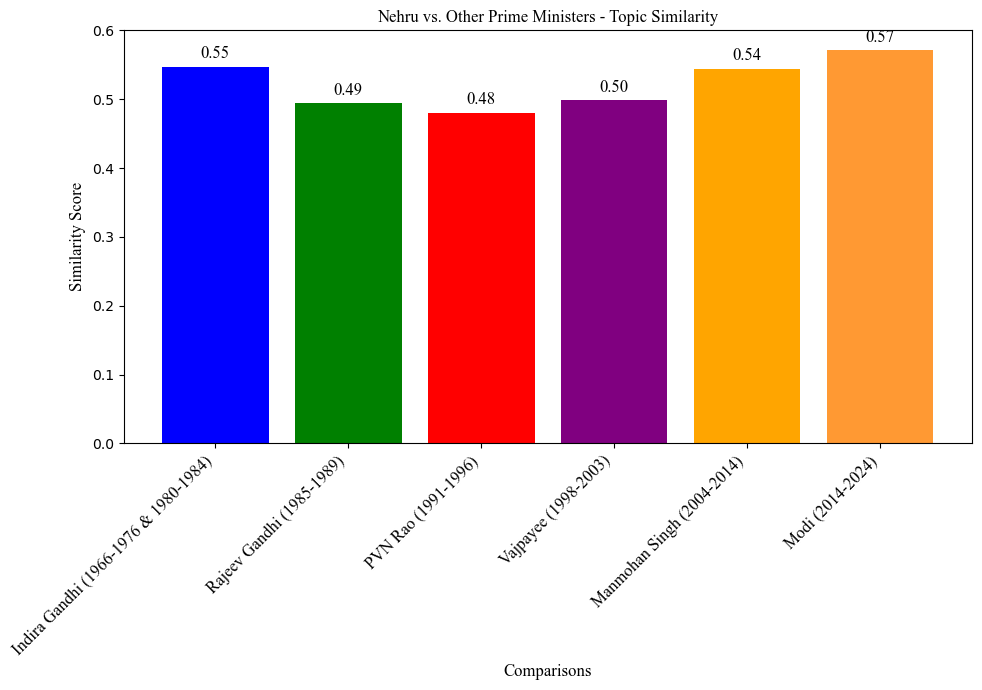

In [84]:
import numpy as np
import matplotlib.pyplot as plt

def compare_yearwise_topics(pm_avg_word_vectors, years_range1, years_range2, model_name="GloVe"):
    similarities = []
    
    for year1 in years_range1:
        for year2 in years_range2:
            if year1 in pm_avg_word_vectors and year2 in pm_avg_word_vectors:
                similarity = compute_similarity(pm_avg_word_vectors[year1], pm_avg_word_vectors[year2])
                similarities.append(similarity)
    
    avg_similarity = np.mean(similarities) if similarities else 0
    return avg_similarity

# Specify the year ranges for Nehru's comparisons
nehru_comparisons = [
    ("Indira Gandhi (1966-1976 & 1980-1984)", list(range(1952, 1964)), list(range(1966, 1977)) + list(range(1980, 1985))),
    ("Rajeev Gandhi (1985-1989)", list(range(1952, 1964)), list(range(1985, 1990))),
    ("PVN Rao (1991-1996)", list(range(1952, 1964)), list(range(1991, 1997))),
    ("Vajpayee (1998-2003)", list(range(1952, 1964)), list(range(1998, 2004))),
    ("Manmohan Singh (2004-2014)", list(range(1952, 1964)), list(range(2004, 2015))),
    ("Modi (2014-2024)", list(range(1952, 1964)), list(range(2014, 2025)))
]

# Calculate similarities using the GloVe model
similarities_glove = []
labels = []

for label, range1, range2 in nehru_comparisons:
    avg_similarity_glove = compare_yearwise_topics(pm_avg_word_vectors_glove, range1, range2, "GloVe")
    similarities_glove.append(avg_similarity_glove)
    labels.append(label)

# Plot the results
x = np.arange(len(labels))  # the label locations

# Define colors with saffron color for Modi and others as distinct colors
colors = ['blue', 'green', 'red', 'purple', 'orange', '#FF9933']  # Hex code for saffron

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(x, similarities_glove, color=colors)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Comparisons', fontsize=12, fontname='Times New Roman')
ax.set_ylabel('Similarity Score', fontsize=12, fontname='Times New Roman')
ax.set_title('Nehru vs. Other Prime Ministers - Topic Similarity', fontsize=12, fontname='Times New Roman')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12, fontname='Times New Roman', rotation=45, ha='right')

# Remove grid lines
ax.grid(False)

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points offset upwards
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12, fontname='Times New Roman')

fig.tight_layout()

plt.show()


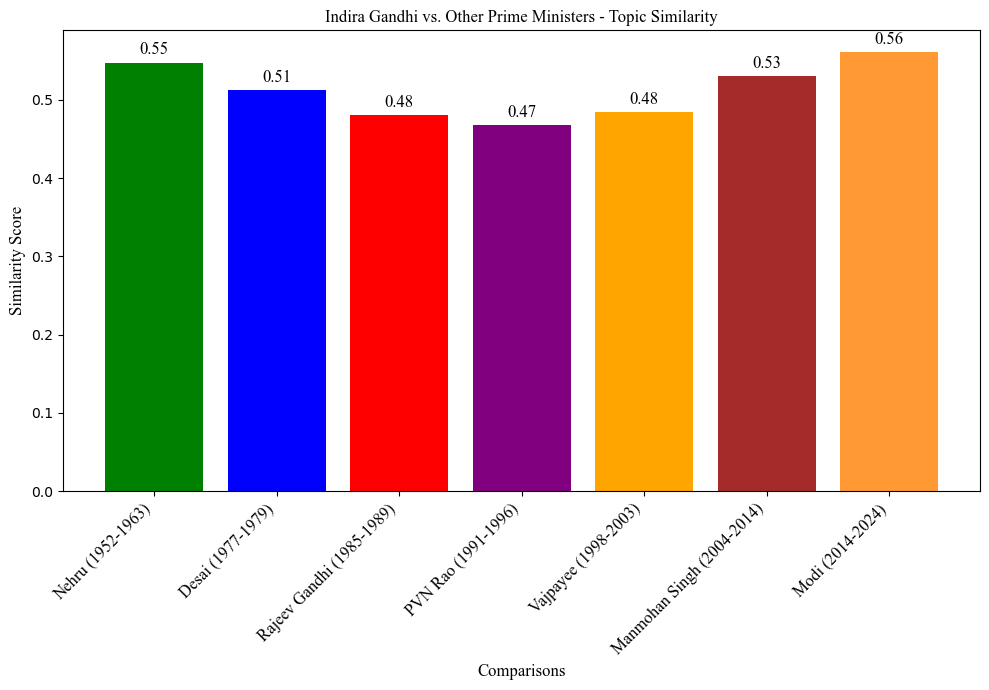

In [85]:
import numpy as np
import matplotlib.pyplot as plt

def compare_yearwise_topics(pm_avg_word_vectors, years_range1, years_range2, model_name="GloVe"):
    similarities = []
    
    for year1 in years_range1:
        for year2 in years_range2:
            if year1 in pm_avg_word_vectors and year2 in pm_avg_word_vectors:
                similarity = compute_similarity(pm_avg_word_vectors[year1], pm_avg_word_vectors[year2])
                similarities.append(similarity)
    
    avg_similarity = np.mean(similarities) if similarities else 0
    return avg_similarity

# Specify the year ranges for Indira Gandhi's comparisons
indira_comparisons = [
    ("Nehru (1952-1963)", list(range(1966, 1977)) + list(range(1980, 1985)), list(range(1952, 1964))),
    ("Desai (1977-1979)", list(range(1966, 1977)) + list(range(1980, 1985)), list(range(1977, 1980))),
    ("Rajeev Gandhi (1985-1989)", list(range(1966, 1977)) + list(range(1980, 1985)), list(range(1985, 1990))),
    ("PVN Rao (1991-1996)", list(range(1966, 1977)) + list(range(1980, 1985)), list(range(1991, 1997))),
    ("Vajpayee (1998-2003)", list(range(1966, 1977)) + list(range(1980, 1985)), list(range(1998, 2004))),
    ("Manmohan Singh (2004-2014)", list(range(1966, 1977)) + list(range(1980, 1985)), list(range(2004, 2015))),
    ("Modi (2014-2024)", list(range(1966, 1977)) + list(range(1980, 1985)), list(range(2014, 2025)))
]

# Calculate similarities using the GloVe model
similarities_glove = []
labels = []

for label, range1, range2 in indira_comparisons:
    avg_similarity_glove = compare_yearwise_topics(pm_avg_word_vectors_glove, range1, range2, "GloVe")
    similarities_glove.append(avg_similarity_glove)
    labels.append(label)

# Plot the results
x = np.arange(len(labels))  # the label locations

# Define colors with saffron color for Modi and others as distinct colors
colors = ['green', 'blue', 'red', 'purple', 'orange', 'brown', '#FF9933']  # Hex code for saffron

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(x, similarities_glove, color=colors)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Similarity Score', fontsize=12, fontname='Times New Roman')
ax.set_xlabel('Comparisons', fontsize=12, fontname='Times New Roman')
ax.set_title('Indira Gandhi vs. Other Prime Ministers - Topic Similarity', fontsize=12, fontname='Times New Roman')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12, fontname='Times New Roman', rotation=45, ha='right')

# Remove grid lines
ax.grid(False)

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points offset upwards
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12, fontname='Times New Roman')

fig.tight_layout()

plt.show()


In [91]:
import numpy as np
import matplotlib.pyplot as plt

def compute_similarity(vector1, vector2):
    from scipy.spatial.distance import cosine
    return 1 - cosine(vector1, vector2)

def compare_yearwise_topics(pm_avg_word_vectors, years_range1, years_range2, model_name="GloVe"):
    similarities = []
    
    for year1 in years_range1:
        for year2 in years_range2:
            if year1 in pm_avg_word_vectors and year2 in pm_avg_word_vectors:
                similarity = compute_similarity(pm_avg_word_vectors[year1], pm_avg_word_vectors[year2])
                similarities.append(similarity)
    
    avg_similarity = np.mean(similarities) if similarities else 0
    return avg_similarity

# Specify the year ranges for PVN Rao's comparisons
pvn_rao_comparisons = [
    ("Nehru (1952-1963)", list(range(1991, 1997)), list(range(1952, 1964))),
    ("Indira Gandhi (1966-1976 & 1980-1984)", list(range(1991, 1997)), list(range(1966, 1977)) + list(range(1980, 1985))),
    ("Rajeev Gandhi (1985-1989)", list(range(1991, 1997)), list(range(1985, 1990))),
    ("VP Singh (1989-1990)", list(range(1991, 1997)), list(range(1989, 1991))),
    ("Vajpayee (1998-2003)", list(range(1991, 1997)), list(range(1998, 2004))),
    ("Manmohan Singh (2004-2014)", list(range(1991, 1997)), list(range(2004, 2015))),
    ("Modi (2014-2024)", list(range(1991, 1997)), list(range(2014, 2025)))
]

# Calculate similarities using the GloVe model
similarities_glove = []
labels = []

for label, range1, range2 in pvn_rao_comparisons:
    avg_similarity_glove = compare_yearwise_topics(pm_avg_word_vectors_glove, range1, range2, "GloVe")
    similarities_glove.append(avg_similarity_glove)
    labels.append(label)

# Plot the results
x = np.arange(len(labels))  # the label locations

# Define colors with saffron color for Modi and others as distinct colors
colors = ['green', 'blue', 'red', 'purple', 'orange', 'brown', '#FF9933']  # Hex code for saffron

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(x, similarities_glove, color=colors)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Similarity Score', fontsize=12, fontname='Times New Roman')
ax.set_xlabel('Comparisons', fontsize=12, fontname='Times New Roman')
ax.set_title('PVN Rao vs. Other Prime Ministers - Topic Similarity', fontsize=12, fontname='Times New Roman')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12, fontname='Times New Roman', rotation=45, ha='right')

# Remove grid lines
ax.grid(False)

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points offset upwards
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12, fontname='Times New Roman')

fig.tight_layout()

plt.show()


ValueError: Input vector should be 1-D.

In [89]:
import numpy as np
import matplotlib.pyplot as plt

def compare_yearwise_topics(pm_avg_word_vectors, years_range1, years_range2, model_name="GloVe"):
    similarities = []
    
    for year1 in years_range1:
        for year2 in years_range2:
            if year1 in pm_avg_word_vectors and year2 in pm_avg_word_vectors:
                similarity = compute_similarity(pm_avg_word_vectors[year1], pm_avg_word_vectors[year2])
                similarities.append(similarity)
    
    avg_similarity = np.mean(similarities) if similarities else 0
    return avg_similarity

# Specify the year ranges for Modi's comparisons
modi_comparisons = [
    ("Nehru (1952-1963)", list(range(2014, 2025)), list(range(1952, 1964))),
    ("Indira Gandhi (1966-1976 & 1980-1984)", list(range(2014, 2025)), list(range(1966, 1977)) + list(range(1980, 1985))),
    ("Rajeev Gandhi (1985-1989)", list(range(2014, 2025)), list(range(1985, 1990))),
    ("PVN Rao (1991-1996)", list(range(2014, 2025)), list(range(1991, 1997))),
    ("Vajpayee (1998-2003)", list(range(2014, 2025)), list(range(1998, 2004))),
    ("Manmohan Singh (2004-2014)", list(range(2014, 2025)), list(range(2004, 2015)))
]

# Calculate similarities using the GloVe model
similarities_glove = []
labels = []

for label, range1, range2 in modi_comparisons:
    avg_similarity_glove = compare_yearwise_topics(pm_avg_word_vectors_glove, range1, range2, "GloVe")
    similarities_glove.append(avg_similarity_glove)
    labels.append(label)

# Plot the results
y = np.arange(len(labels))  # the label locations

# Define colors with saffron color for Modi and others as distinct colors
colors = ['blue', 'green', 'red', 'purple', 'orange', '#FFC0CB']  # Hex code for saffron

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(y, similarities_glove, color=colors)

# Add some text for labels, title, and custom y-axis tick labels, etc.
ax.set_ylabel('Comparisons', fontsize=12, fontname='Times New Roman')
ax.set_xlabel('Similarity Score', fontsize=12, fontname='Times New Roman')
ax.set_title('Modi vs. Other Prime Ministers - Topic Similarity', fontsize=12, fontname='Times New Roman')
ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=12, fontname='Times New Roman')
ax.invert_yaxis()  # reverse the order of the y-axis

# Remove grid lines
ax.grid(False)

# Add value labels on top of the bars
for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width:.2f}', 
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),  # 3 points offset to the right
                textcoords="offset points",
                ha='left', va='center', fontsize=12, fontname='Times New Roman')

fig.tight_layout()

plt.show()


ValueError: operands could not be broadcast together with shapes (2100,) (3000,) 

In [104]:
import numpy as np
import matplotlib.pyplot as plt

def compare_yearwise_topics(pm_avg_word_vectors, years_range1, years_range2, model_name="GloVe"):
    similarities = []
    
    for year1 in years_range1:
        for year2 in years_range2:
            if year1 in pm_avg_word_vectors and year2 in pm_avg_word_vectors:
                similarity = compute_similarity(pm_avg_word_vectors[year1], pm_avg_word_vectors[year2])
                similarities.append(similarity)
    
    avg_similarity = np.mean(similarities) if similarities else 0
    return avg_similarity

# Specify the year ranges for Manmohan Singh's comparisons
manmohan_comparisons = [
    ("Nehru (1952-1963)", list(range(2004, 2015)), list(range(1952, 1964))),
    ("Indira Gandhi (1966-1976 & 1980-1984)", list(range(2004, 2015)), list(range(1966, 1977)) + list(range(1980, 1985))),
    ("Rajeev Gandhi (1985-1989)", list(range(2004, 2015)), list(range(1985, 1990))),
    ("PVN Rao (1991-1996)", list(range(2004, 2015)), list(range(1991, 1997))),
    ("Vajpayee (1998-2003)", list(range(2004, 2015)), list(range(1998, 2004))),
    ("Modi (2014-2024)", list(range(2004, 2015)), list(range(2014, 2025)))
]

# Calculate similarities using the GloVe model
similarities_glove = []
labels = []

for label, range1, range2 in manmohan_comparisons:
    avg_similarity_glove = compare_yearwise_topics(pm_avg_word_vectors_glove, range1, range2, "GloVe")
    similarities_glove.append(avg_similarity_glove)
    labels.append(label)

# Plot the results
y = np.arange(len(labels))  # the label locations

# Define colors with saffron color for Modi and others as distinct colors
colors = ['blue', 'green', 'red', 'purple', 'orange', '#FF9933']  # Hex code for saffron

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(y, similarities_glove, color=colors)

# Add some text for labels, title, and custom y-axis tick labels, etc.
ax.set_ylabel('Comparisons', fontsize=12, fontname='Times New Roman')
ax.set_xlabel('Similarity Score', fontsize=12, fontname='Times New Roman')
ax.set_title('Manmohan Singh vs. Other Prime Ministers - Topic Similarity', fontsize=12, fontname='Times New Roman')
ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=12, fontname='Times New Roman')
ax.invert_yaxis()  # reverse the order of the y-axis

# Remove grid lines
ax.grid(False)

# Add value labels on top of the bars
for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width:.2f}', 
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),  # 3 points offset to the right
                textcoords="offset points",
                ha='left', va='center', fontsize=12, fontname='Times New Roman')

fig.tight_layout()

plt.show()


ValueError: Input vector should be 1-D.

In [117]:
import pandas as pd

# Load the Excel file into a DataFrame
file_path = r"C:\Users\HP\Downloads\Lscomp.xlsx"
df = pd.read_excel(file_path)

# Display the first few rows of the DataFrame
df.head()

Lok sabha NO                                                  E  \
0          LS1  "thing", "plan", "people", "great", "house", "...   
1          LS2  "plan", "thing", "think", "industry", "house",...   
2          LS3  "planning", "plan", "thing", "industrial", "th...   
3          LS4  "region", "cooperation", "singapore", "malaysi...   
4          LS5  "employment", "price", "programme", "sector", ...   

                                                  IR  \
0  "problem", "solution", "un", "people", "pakist...   
1  "kashmir", "pakistan", "world", "house", "thin...   
2  "pakistan", "bengal", "west", "east", "commiss...   
3  "israel", "asia", "council", "west", "bank", "...   
4  "rehman", "sheikh", "mujibur", "arc", "impact"...   

                                                   C  \
0   "province", "andhra", "matter", "think", "dem...   
1  "work", "thing", "course", "done", "matter", "...   
2  "people", "thing", "war", "think", "good", "ar...   
3  "party", "want", "congress", "thing", "democra...   
4  "scheduled", "problem", "programme", "caste", ...   

                                                IANS  \
0  "kashmir", "state", "people", "matter", "pakis...   
1  "kashmir", "pakistan", "world", "house", "thin...   
2  "test", "conference", "naga", "nuclear", "burm...   
3  "rajasthan", "monopoly", "change", "situation"...   
4  "constituency", "people", "procedure", "thing"...   

                                                 SnT  \
0  "defence", "equipment", "war", "army", "factor...   
1  "energy", "atomic", "research", "work", "sourc...   
2                                                NaN   
3  "landing", "moon", "moment", "united", "nauts"...   
4  "nuclear", "experiment", "explosion", "peacefu...   

                                                  PA  
0   "property", "constitution", "compensation", "...  
1  "plan", "thing", "think", "industry", "house",...  
2  "nagaland", "naga", "bill", "convention", "sep...  
3  "cabinet", "house", "election", "secretariat",...  
4  "scheduled", "problem", "programme", "caste", ...

In [118]:
df

Lok sabha NO                                                  E  \
0           LS1  "thing", "plan", "people", "great", "house", "...   
1           LS2  "plan", "thing", "think", "industry", "house",...   
2           LS3  "planning", "plan", "thing", "industrial", "th...   
3           LS4  "region", "cooperation", "singapore", "malaysi...   
4           LS5  "employment", "price", "programme", "sector", ...   
5           LS6  "soviet", "commonwealth", "cooperation", "rela...   
6           LS7  "people", "state", "problem", "price", "member...   
7           LS8  "plan", "look", "people", "sector", "industry"...   
8           LS9  "want", "private", "higher", "lem", "current",...   
9          LS10  "german", "germany", "chancellor", "cooperatio...   
10         LS11  "distribution", "system", "poverty", "public",...   
11         LS12  "sector", "party", "policy", "public", "planni...   
12         LS13  "negotiation", "seattle", "wto", "conference",...   
13         LS14  "price", "kilogram", "live", "poor", "scheme",...   
14         LS15  "development", "australia", "mandate", "republ...   
15         LS16  "poor", "state", "world", "people", "model", "...   
16         LS17  "people", "life", "opportunity", "work", "kota...   

                                                   IR  \
0   "problem", "solution", "un", "people", "pakist...   
1   "kashmir", "pakistan", "world", "house", "thin...   
2   "pakistan", "bengal", "west", "east", "commiss...   
3   "israel", "asia", "council", "west", "bank", "...   
4   "rehman", "sheikh", "mujibur", "arc", "impact"...   
5   "soviet", "commonwealth", "cooperation", "rela...   
6   "soviet", "peace", "union", "president", "euro...   
7   "visit", "soviet", "useful", "president", "mee...   
8   "nuclear", "yielded", "andi", "drop", "happens...   
9   "world", "international", "nepal", "china", "q...   
10  "saarc", "summit", "cooperation", "subregional...   
11  "iraq", "un", "council", "compliance", "securi...   
12  "mauritius", "visit", "bilateral", "relation",...   
13  "saarc", "summit", "cooperation", "subregional...   
14  "pakistan", "technology", "nuclear", "meeting"...   
15  "incident", "pakistan", "recent", "bangladesh"...   
16  "people", "today", "congress", "time", "world"...   

                                                    C  \
0    "province", "andhra", "matter", "think", "dem...   
1   "work", "thing", "course", "done", "matter", "...   
2   "people", "thing", "war", "think", "good", "ar...   
3   "party", "want", "congress", "thing", "democra...   
4   "scheduled", "problem", "programme", "caste", ...   
5   "opposition", "fear", "want", "happened", "peo...   
6   "people", "right", "cause", "past", "harijan",...   
7   "bill", "party", "opposition", "looking", "cla...   
8   "social", "deputy", "change", "house", "want",...   
9   "court", "uttar", "janma", "settlement", "cons...   
10  "party", "bihari", "atal", "house", "vote", "p...   
11  "apology", "minority", "house", "yesterday", "...   
12  "agenda", "seat", "statement", "chaturvedi", "...   
13  "party", "bihari", "atal", "house", "vote", "p...   
14  "behalf", "occasion", "elected", "experience",...   
15  "house", "issue", "carry", "meeting", "keeping...   
16  "nation", "people", "water", "forward", "oppor...   

                                                 IANS  \
0   "kashmir", "state", "people", "matter", "pakis...   
1   "kashmir", "pakistan", "world", "house", "thin...   
2   "test", "conference", "naga", "nuclear", "burm...   
3   "rajasthan", "monopoly", "change", "situation"...   
4   "constituency", "people", "procedure", "thing"...   
5   opposition", "fear", "want", "happened", "peop...   
6   "people", "noconfidence", "interested", "name"...   
7   "democratic", "demo", "terrorism", "people", "...   
8   "shrivishwanath", "vishwanath", "pratap", "thi...   
9   "narasimha", "aware", "tions", "side", "presen...   
10  "election", "kashmir", "autonomy", "extension"...   
11  

In [119]:
cell_value = df.iloc[8, 2]  # Access the cell in the first row and second column (LS1)
print(cell_value)


"nuclear", "yielded", "andi", "drop", "happens", "went", "principal", "onboth", "honmembers", "thiscountry",
"namibia", "president", "transition", "heid", "visit", "independ", "ence", "occasion", "state", "chairman",
"troop", "pakistan", "fire", "area", "incident", "artillery", "pakistani", "post", "intrusion", "subsector",
"saarc", "state", "head", "govern", "summit", "regional", "expressed", "decided", "cooperation", "noted",
"council", "embassy", "war", "evacuate", "closed", "chairman", "iraq", "membercountries", "chandra", "national"


In [120]:
# Check the actual column names
print(df.columns)


Index(['Lok sabha NO', 'E', 'IR', 'C', 'IANS', 'SnT', 'PA'], dtype='object')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


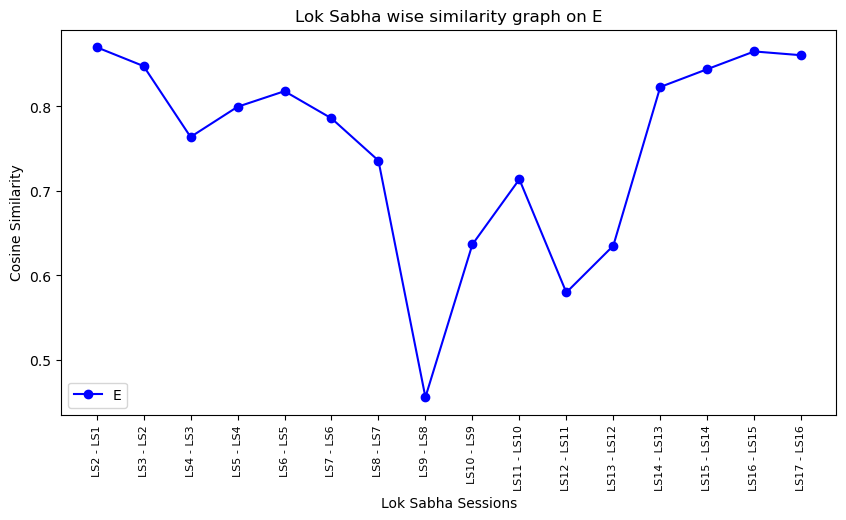

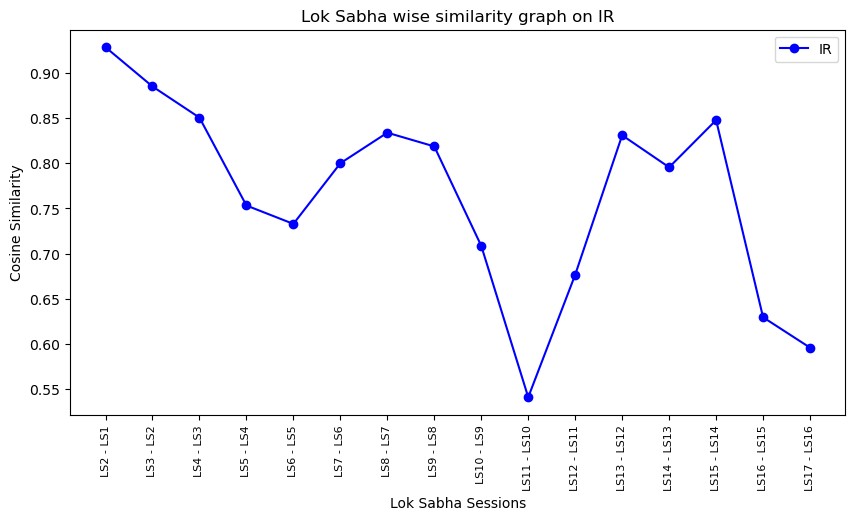

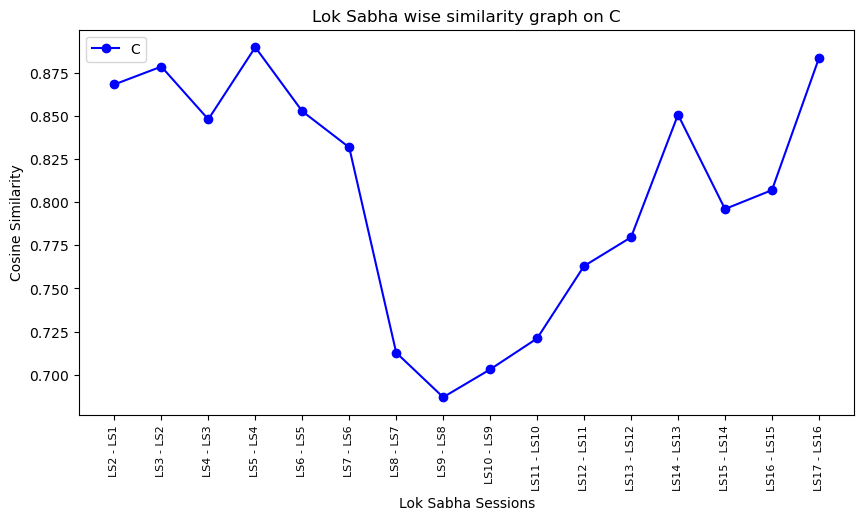

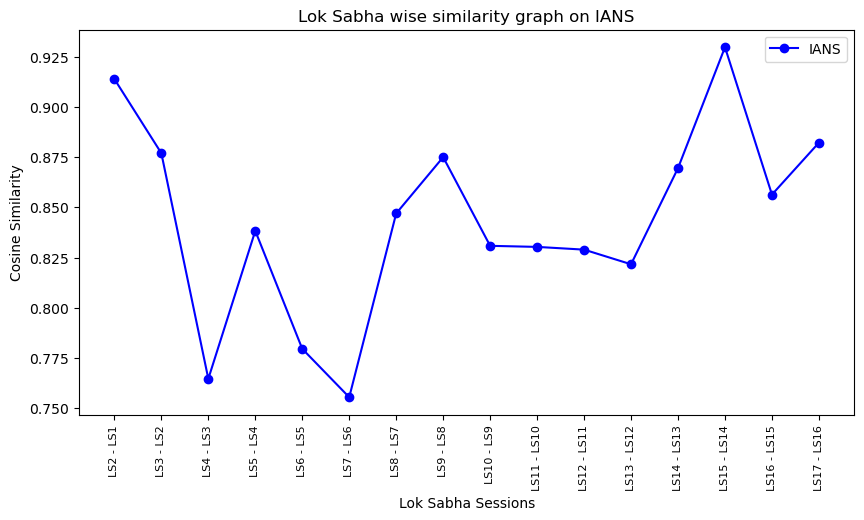

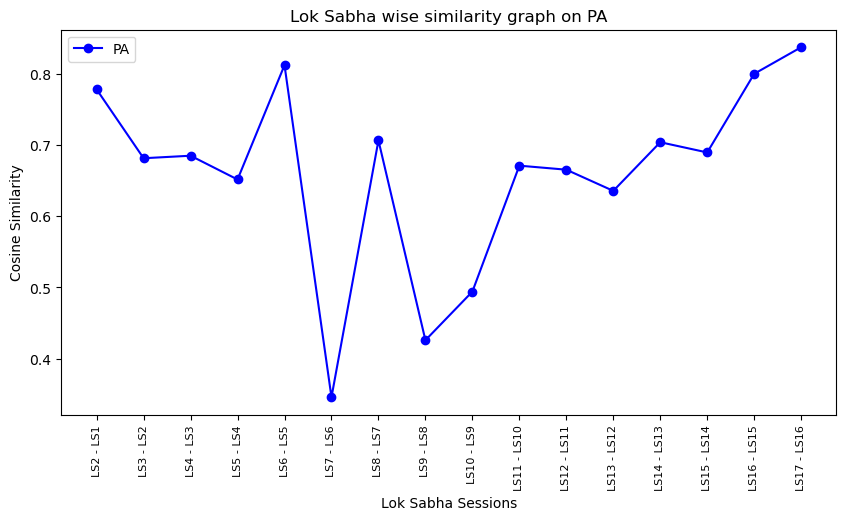

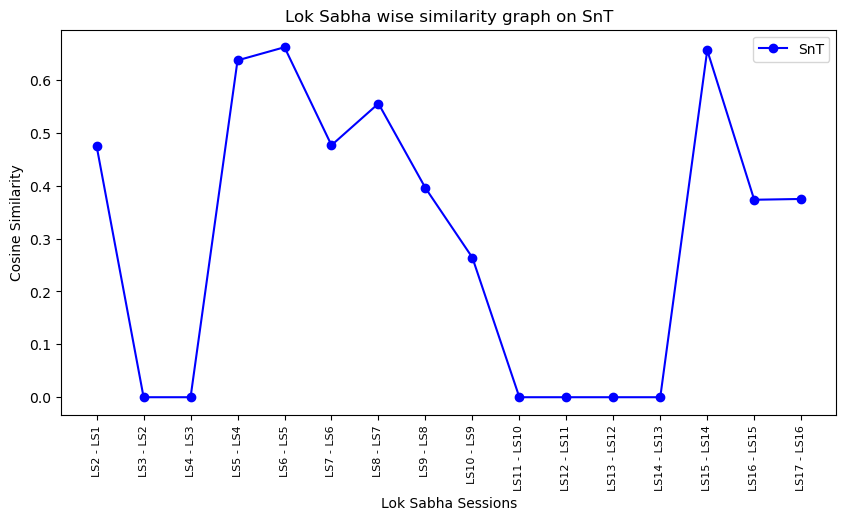

In [121]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
import string
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import nltk

nltk.download('stopwords')

# Load stopwords
stop_words = set(stopwords.words('english'))

# Function to preprocess the data
def preprocess(words):
    return [word.strip('"').lower() for word in words if word.strip('"').lower() not in stop_words and word not in string.punctuation]

# Function to compute average word vectors
def average_word_vector(words, model, num_features=300):
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model:
            num_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

# Function to compute cosine similarity
def compute_similarity(vec1, vec2):
    if np.linalg.norm(vec1) != 0 and np.linalg.norm(vec2) != 0: # Avoid zero vectors
        return cosine_similarity([vec1], [vec2])[0][0]
    return 0

# Load the pre-trained Word2Vec or GloVe model
word2vec_model = api.load("word2vec-google-news-300")
# glove_model = api.load("glove-wiki-gigaword-300")

# Load the Excel file into a DataFrame
file_path = r"C:\Users\HP\Downloads\Lscomp.xlsx"
df = pd.read_excel(file_path)

# Preprocess the data and compute average word vectors for each topic category
categories = ['E', 'IR', 'C', 'IANS', 'PA', 'SnT']
processed_data = {category: {} for category in categories}

for index, row in df.iterrows():
    lok_sabha = row['Lok sabha NO']
    for category in categories:
        if isinstance(row[category], str):  # Check if the cell is a valid string
            words = row[category].split(", ")
            processed_words = preprocess(words)
            avg_vector = average_word_vector(processed_words, word2vec_model)
        else:
            avg_vector = np.zeros((300,))  # Handle NaN or missing values by assigning a zero vector
        processed_data[category][lok_sabha] = avg_vector

# Compute similarities for consecutive Lok Sabha sessions for each category
similarity_scores = {category: [] for category in categories}
lok_sabhas = df['Lok sabha NO'].tolist()

for category in categories:
    for i in range(1, len(lok_sabhas)):
        prev_lok_sabha = lok_sabhas[i - 1]
        current_lok_sabha = lok_sabhas[i]
        similarity = compute_similarity(processed_data[category][current_lok_sabha], processed_data[category][prev_lok_sabha])
        similarity_scores[category].append(similarity)

# Define X-axis labels for the plots
x_labels = [f"{lok_sabhas[i]} - {lok_sabhas[i-1]}" for i in range(1, len(lok_sabhas))]

# Plot the results for each category
def plot_similarity(category, scores, x_labels):
    plt.figure(figsize=(10, 5))
    plt.plot(x_labels, scores, 'bo-', label=category)
    plt.title(f'Lok Sabha wise similarity graph on {category}')
    plt.xlabel('Lok Sabha Sessions')
    plt.ylabel('Cosine Similarity')
    plt.legend()
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(False)
    plt.show()

# Plot similarities for each category
for category in categories:
    plot_similarity(category, similarity_scores[category], x_labels)


In [122]:
df

Lok sabha NO                                                  E  \
0           LS1  "thing", "plan", "people", "great", "house", "...   
1           LS2  "plan", "thing", "think", "industry", "house",...   
2           LS3  "planning", "plan", "thing", "industrial", "th...   
3           LS4  "region", "cooperation", "singapore", "malaysi...   
4           LS5  "employment", "price", "programme", "sector", ...   
5           LS6  "soviet", "commonwealth", "cooperation", "rela...   
6           LS7  "people", "state", "problem", "price", "member...   
7           LS8  "plan", "look", "people", "sector", "industry"...   
8           LS9  "want", "private", "higher", "lem", "current",...   
9          LS10  "german", "germany", "chancellor", "cooperatio...   
10         LS11  "distribution", "system", "poverty", "public",...   
11         LS12  "sector", "party", "policy", "public", "planni...   
12         LS13  "negotiation", "seattle", "wto", "conference",...   
13         LS14  "price", "kilogram", "live", "poor", "scheme",...   
14         LS15  "development", "australia", "mandate", "republ...   
15         LS16  "poor", "state", "world", "people", "model", "...   
16         LS17  "people", "life", "opportunity", "work", "kota...   

                                                   IR  \
0   "problem", "solution", "un", "people", "pakist...   
1   "kashmir", "pakistan", "world", "house", "thin...   
2   "pakistan", "bengal", "west", "east", "commiss...   
3   "israel", "asia", "council", "west", "bank", "...   
4   "rehman", "sheikh", "mujibur", "arc", "impact"...   
5   "soviet", "commonwealth", "cooperation", "rela...   
6   "soviet", "peace", "union", "president", "euro...   
7   "visit", "soviet", "useful", "president", "mee...   
8   "nuclear", "yielded", "andi", "drop", "happens...   
9   "world", "international", "nepal", "china", "q...   
10  "saarc", "summit", "cooperation", "subregional...   
11  "iraq", "un", "council", "compliance", "securi...   
12  "mauritius", "visit", "bilateral", "relation",...   
13  "saarc", "summit", "cooperation", "subregional...   
14  "pakistan", "technology", "nuclear", "meeting"...   
15  "incident", "pakistan", "recent", "bangladesh"...   
16  "people", "today", "congress", "time", "world"...   

                                                    C  \
0    "province", "andhra", "matter", "think", "dem...   
1   "work", "thing", "course", "done", "matter", "...   
2   "people", "thing", "war", "think", "good", "ar...   
3   "party", "want", "congress", "thing", "democra...   
4   "scheduled", "problem", "programme", "caste", ...   
5   "opposition", "fear", "want", "happened", "peo...   
6   "people", "right", "cause", "past", "harijan",...   
7   "bill", "party", "opposition", "looking", "cla...   
8   "social", "deputy", "change", "house", "want",...   
9   "court", "uttar", "janma", "settlement", "cons...   
10  "party", "bihari", "atal", "house", "vote", "p...   
11  "apology", "minority", "house", "yesterday", "...   
12  "agenda", "seat", "statement", "chaturvedi", "...   
13  "party", "bihari", "atal", "house", "vote", "p...   
14  "behalf", "occasion", "elected", "experience",...   
15  "house", "issue", "carry", "meeting", "keeping...   
16  "nation", "people", "water", "forward", "oppor...   

                                                 IANS  \
0   "kashmir", "state", "people", "matter", "pakis...   
1   "kashmir", "pakistan", "world", "house", "thin...   
2   "test", "conference", "naga", "nuclear", "burm...   
3   "rajasthan", "monopoly", "change", "situation"...   
4   "constituency", "people", "procedure", "thing"...   
5   opposition", "fear", "want", "happened", "peop...   
6   "people", "noconfidence", "interested", "name"...   
7   "democratic", "demo", "terrorism", "people", "...   
8   "shrivishwanath", "vishwanath", "pratap", "thi...   
9   "narasimha", "aware", "tions", "side", "presen...   
10  "election", "kashmir", "autonomy", "extension"...   
11  

In [ ]:
# Process and Compute Average Word Vectors with Printing
for index, row in df.iterrows():
    lok_sabha = row['Lok sabha NO']
    print(f"\nLok Sabha Session: {lok_sabha}")
    
    for category in categories:
        if isinstance(row[category], str):  # Check if the cell is a valid string
            words = row[category].split(", ")
            processed_words = preprocess(words)
            avg_vector = average_word_vector(processed_words, word2vec_model)
            
            # Print preprocessed words and their average vector
            print(f"Category: {category}")
            print(f"Preprocessed Words: {processed_words}")
            print(f"Average Word Vector: {avg_vector[:10]}... (truncated)")  # Truncate for readability
        else:
            avg_vector = np.zeros((300,))  # Handle NaN or missing values by assigning a zero vector
            print(f"Category: {category}")
            print(f"No valid data. Assigned Zero Vector.")
        
        processed_data[category][lok_sabha] = avg_vector


In [ ]:
print(df.columns)


In [156]:
import pandas as pd

# Load the Excel file into a DataFrame
file_path = r"C:/Users/HP/Downloads/pmcomp.xlsx"
df2 = pd.read_excel(file_path)

# Display the first few rows of the DataFrame
df2


PRIME MINISTER COMPARISON  \
0                     NEHRU   
1                    INDIRA   
2                     DESAI   
3             RAJEEV GANDHI   
4                  VP SINGH   
5                   PVN RAO   
6                 VAJPAYEE    
7                  MANMOHAN   
8                      MODI   

                                                   E  \
0   "thing ", "plan ", "people ", "great ", "hous...   
1   "gold ", "goldsmith ", "order ", "ornament ",...   
2   "soviet ", "commonwealth ", "cooperation ", "...   
3   "plan ", "look ", "people ", "sector ", "indu...   
4   "want ", "private ", "higher ", "lem ", "curr...   
5   "world ", "programme ", "thing ", "bank ", "i...   
6   "world ", "programme ", "thing ", "bank ", "i...   
7   "partnership ", "cooperation ", "summit ", "e...   
8   "poor ", "state ", "world ", "people ", "mode...   

                                                IANS  \
0   "kashmir ", "state ", "people ", "matter ", "...   
1   "naga ", "nagaland ", "peace ", "mission ", "...   
2   "opposition ", "fear ", "want ", "happened ",...   
3   "democratic ", "demo ", "terrorism ", "people...   
4   "shrivishwanath ", "vishwanath ", "pratap ", ...   
5   "narasimha ", "aware ", "tions ", "side ", "p...   
6   "narasimha ", "aware ", "tions ", "side ", "p...   
7   "calamity ", "state ", "maharashtra ", "droug...   
8   "house ", "issue ", "carry ", "meeting ", "ke...   

                                                  IR  \
0   "kashmir ", "state ", "people ", "matter ", "...   
1   "president ", "gaulle ", "de ", "johnson ", "...   
2   "agreement ", "farakka ", "bangladesh ", "wat...   
3   "visit ", "soviet ", "useful ", "president ",...   
4   "nuclear ", "yielded ", "andi ", "drop ", "ha...   
5   "world ", "international ", "nepal ", "china ...   
6   "nuclear ", "weapon ", "security ", "test ", ...   
7   "joint ", "premier ", "agreed ", "boundary ",...   
8   "incident ", "pakistan ", "recent ", "banglad...   

                                                   C  \
0   "province ", "andhra ", "matter ", "think ", ...   
1   "party ", "want ", "congress ", "thing ", "de...   
2   "want ", "thing ", "done ", "anybody ", "oppo...   
3   "people ", "right ", "cause ", "past ", "hari...   
4   "want ", "people ", "house ", "haryana ", "ja...   
5   "court ", "uttar ", "janma ", "settlement ", ...   
6  nth ", "facility ", "island ", "swatantrata ",...   
7   "house ", "nation ", "proceeding ", "illustri...   
8   "house ", "great ", "democracy ", "temple ", ...   

                                                  PA  \
0   "province ", "andhra ", "matter ", "think ", ...   
1   "gold ", "goldsmith ", "order ", "ornament ",...   
2   "institution ", "committee ", "rural ", "plan...   
3   "bill ", "people ", "state ", "panchayati ", ...   
4   "notinorder ", "willgive ", "whenafterthe ", ...   
5   "area ", "investment ", "nave ", "punjab ", "...   
6   "scheme ", "collector ", "village ", "done ",...   
7   "calamity ", "state ", "maharashtra ", "droug...   
8   "house ", "deputy ", "experience ", "deputy "...   

                                                 SnT  
0   "policy ", "job ", "foreign ", "expert ", "at...  
1   "landing ", "moon ", "moment ", "united ", "n...  
2   "people ", "device ", "thing ", "hazard ", "e...  
3   "seabed ", "ocean ", "claim ", "deep ", "regi...  
4   "nuclear ", "yielded ", "andi ", "drop ", "ha...  
5   "insatb ", "satellite ", "payload ", "spacecr...  
6   "insatb ", "satellite ", "payload ", "spacecr...  
7   "nuclear ", "energy ", "united ", "state ", "...  
8   "satellite ", "restructuring ", "head ", "hot...

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
import string

# Load the Excel file into a DataFrame
file_path = r"C:/Users/HP/Downloads/pmcomp.xlsx"
df2 = pd.read_excel(file_path)

# Print the first few rows of the DataFrame
df2.head()


PRIME MINISTER COMPARISON  \
0                     NEHRU   
1                    INDIRA   
2                     DESAI   
3             RAJEEV GANDHI   
4                  VP SINGH   

                                                   E  \
0  "thing", "plan", "people", "great", "house", "...   
1  "gold", "goldsmith", "order", "ornament", "tya...   
2  "soviet", "commonwealth", "cooperation", "rela...   
3  "plan", "look", "people", "sector", "industry"...   
4  "want","private","higher","lem","current","aff...   

                                                IANS  \
0  "kashmir", "state", "people", "matter", "pakis...   
1  "naga", "nagaland", "peace", "mission", "feder...   
2  "opposition", "fear", "want", "happened", "peo...   
3  "democratic", "demo", "terrorism", "people", "...   
4  "shrivishwanath","vishwanath","pratap","think"...   

                                                  IR  \
0  "kashmir", "state", "people", "matter", "pakis...   
1  "president", "gaulle", "de", "johnson", "ameri...   
2  "agreement", "farakka", "bangladesh", "water",...   
3  "visit", "soviet", "useful", "president", "mee...   
4  "nuclear","yielded","andi","drop","happens","w...   

                                                   C  \
0  "province", "andhra", "matter", "think", "dema...   
1  "party", "want", "congress", "thing", "democra...   
2  "want", "thing", "done", "anybody", "oppositio...   
3  "people", "right", "cause", "past", "harijan",...   
4  "want","people","house","haryana","janata","pa...   

                                                  PA  \
0  "province", "andhra", "matter", "think", "dema...   
1  "gold", "goldsmith", "order", "ornament", "tya...   
2  "institution", "committee", "rural", "planning...   
3  "bill", "people", "state", "panchayati", "demo...   
4  "notinorder","willgive","whenafterthe","male",...   

                                                 SnT  
0  "policy", "job", "foreign", "expert", "atomic"...  
1  "landing", "moon", "moment", "united", "nauts"...  
2  "people", "device", "thing", "hazard", "expedi...  
3  "seabed", "ocean", "claim", "deep", "registrat...  
4  "nuclear","yielded","andi","drop","happens","w...

In [166]:
# Display the column names of the DataFrame
print(df2.columns)


Index(['PRIME MINISTER COMPARISON', 'E', 'IANS', 'IR', 'C', 'PA', 'SnT'], dtype='object')


In [172]:
cell_value = df2.iloc[5, 1]  # Access the cell in the first row and second column (LS1)
print(cell_value)

"world","programme","thing","bank","imf","money","number","time","thisis","narasimha"
"durable","signed","gathering","manner","tha","supply","iii","energy","fast","ruptiom"
"khadi","agriculture","weaver","fertiliser","point","state","time","village","matter","party"
"proper","develop","past","outlay","latest","understand","development","scale","process","happen"
"price","industry","company","investment","saying","foreign","sector","programme","english","atal"
"day","today","small","advantage","bengal","expenditure","responded","developmental","agree","everything"


In [190]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess(words):
    return [word.strip('"').lower() for word in words if word.strip('"').lower() not in stop_words and word not in string.punctuation and not word.strip('"').isdigit() and '_' not in word]

# Function to extract words from a cell and preprocess them
def extract_and_preprocess(cell):
    words = cell.split(",")
    return preprocess(words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [191]:
def average_word_vector(words, model, num_features=300):
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model:
            num_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

# Function to compute average word vectors for a given column
def compute_avg_vectors(df, column, model):
    avg_vectors = {}
    for idx, row in df.iterrows():
        words = extract_and_preprocess(row[column])
        avg_vectors[row['PRIME MINISTER COMPARISON']] = average_word_vector(words, model)
    return avg_vectors


In [192]:
def compute_similarity(nehrus_vector, pm_vectors):
    similarities = {}
    for pm, vector in pm_vectors.items():
        if np.linalg.norm(nehrus_vector) != 0 and np.linalg.norm(vector) != 0:  # Avoid zero vectors
            similarity = cosine_similarity([nehrus_vector], [vector])[0][0]
            similarities[pm] = similarity
    return similarities


In [193]:
def plot_similarity(similarities, title):
    pms = list(similarities.keys())
    scores = list(similarities.values())

    plt.figure(figsize=(10, 5))
    plt.barh(pms, scores, color='blue')
    plt.xlabel('Similarity Score')
    plt.ylabel('Prime Ministers')
    plt.title(title)
    plt.gca().invert_yaxis()  # To display the highest similarity on top
    plt.show()


C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


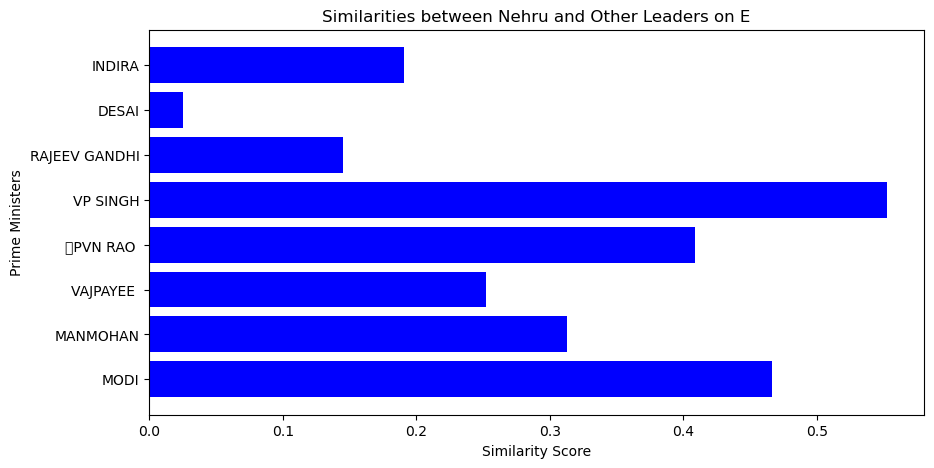

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


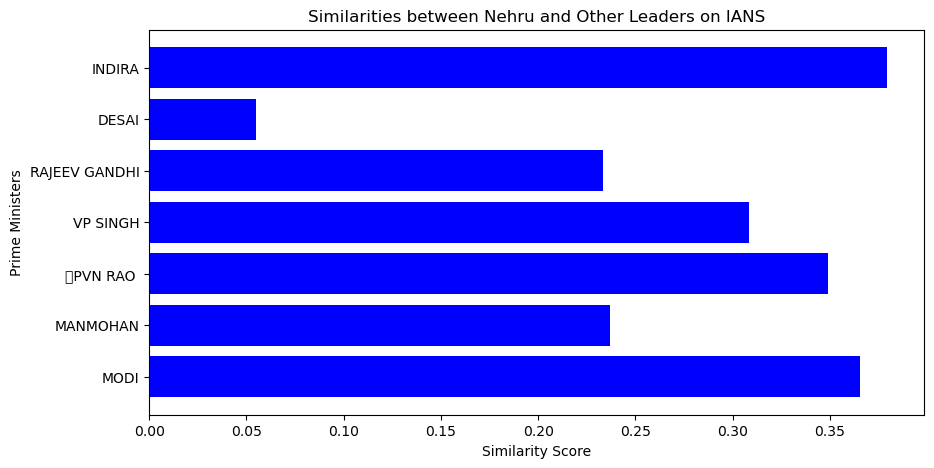

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


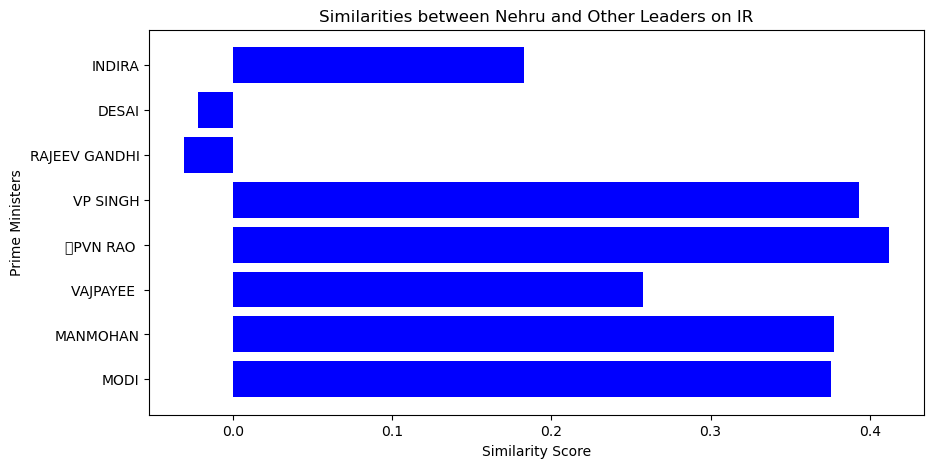

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


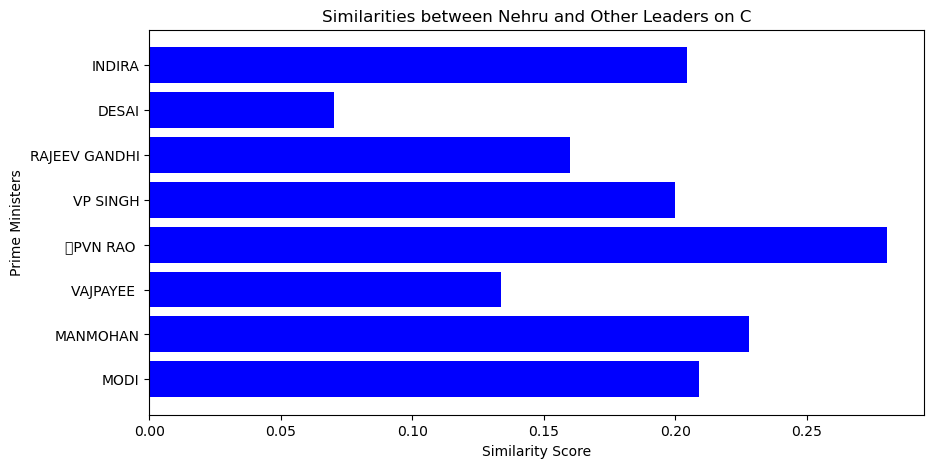

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


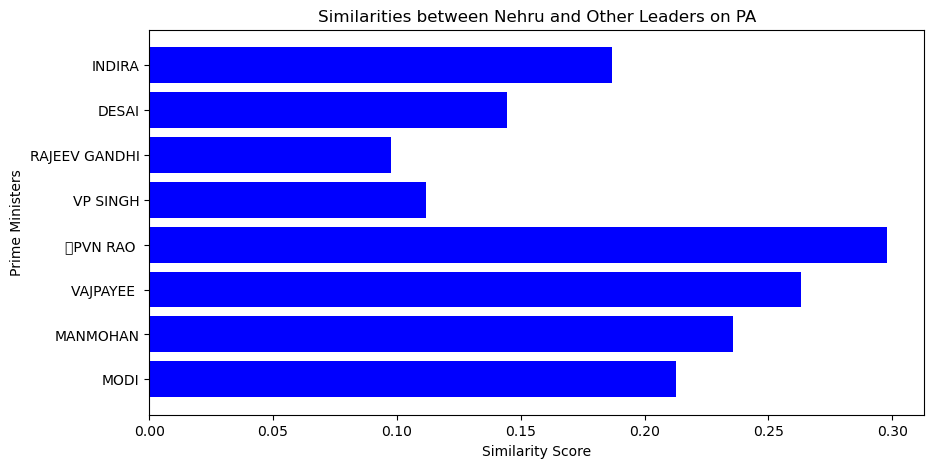

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


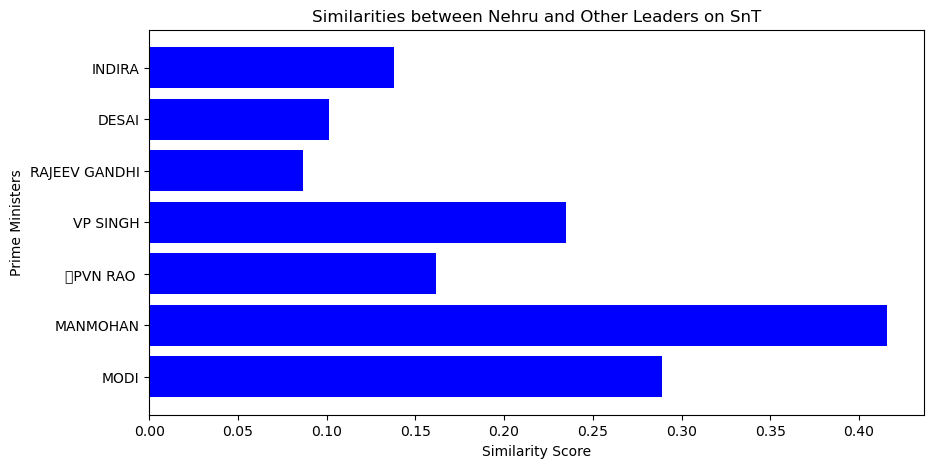

In [194]:
# Paths to the document
file_path = r"C:/Users/HP/Downloads/pmcomp.xlsx"
df2 = pd.read_excel(file_path)

# Compute average word vectors for each topic column
nehrus_vectors = {}
columns = ['E', 'IANS', 'IR', 'C', 'PA', 'SnT']

for column in columns:
    avg_vectors = compute_avg_vectors(df2, column, word2vec_model)
    nehrus_vector = avg_vectors.pop('NEHRU', None)  # Get Nehru's vector and remove it from avg_vectors
    nehrus_vectors[column] = nehrus_vector
    similarities = compute_similarity(nehrus_vector, avg_vectors)
    
    # Plot the similarities for each column
    plot_similarity(similarities, f'Similarities between Nehru and Other Leaders on {column}')


C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


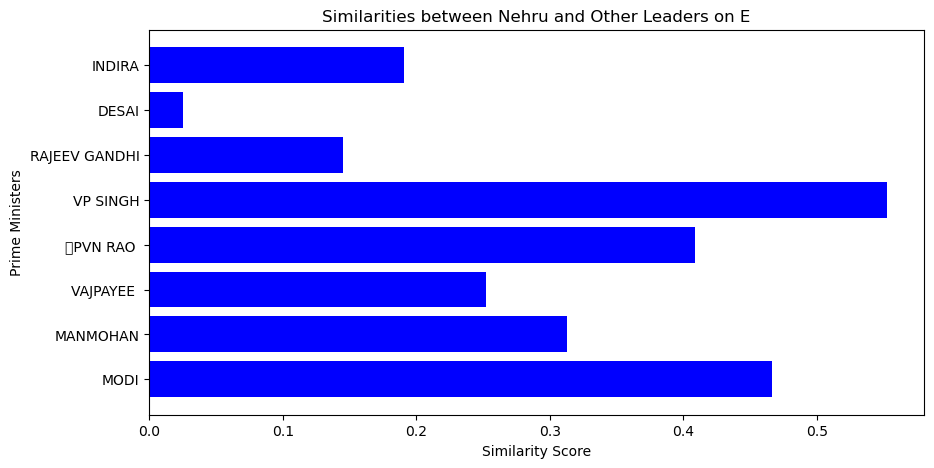

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


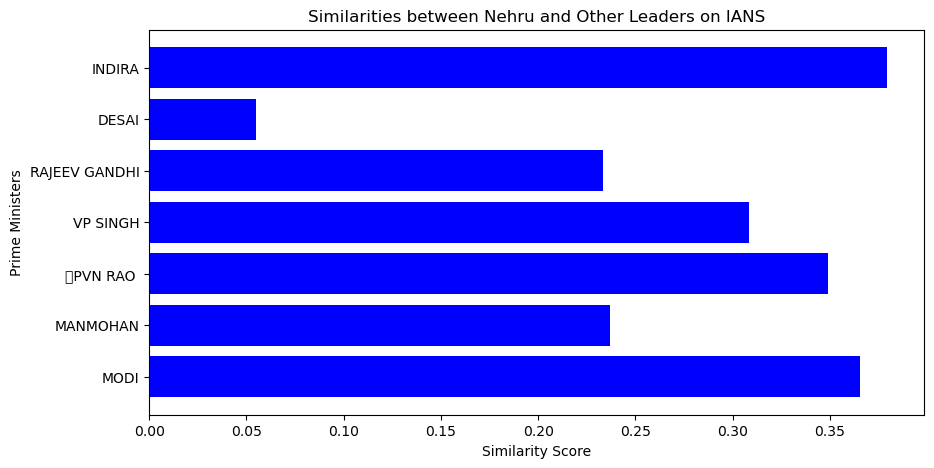

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


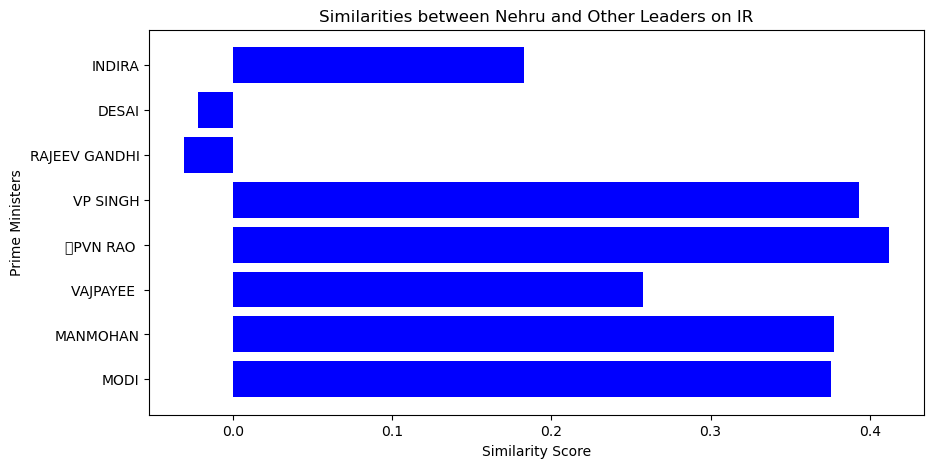

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


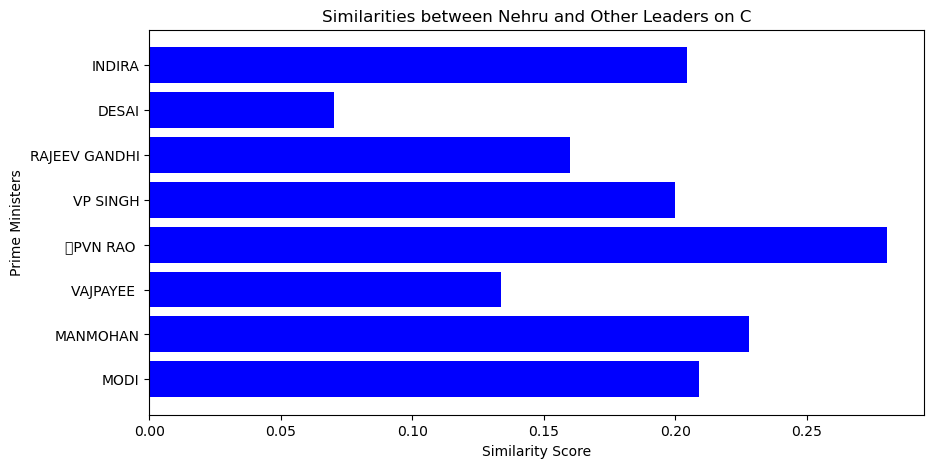

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


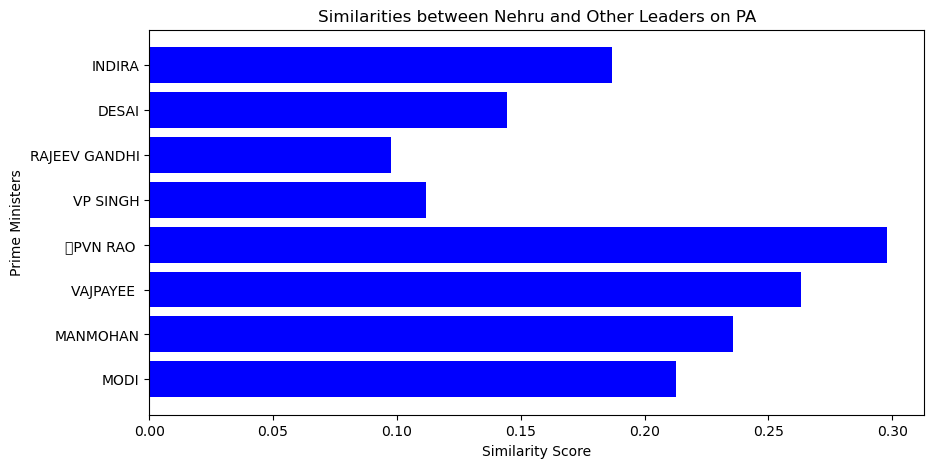

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


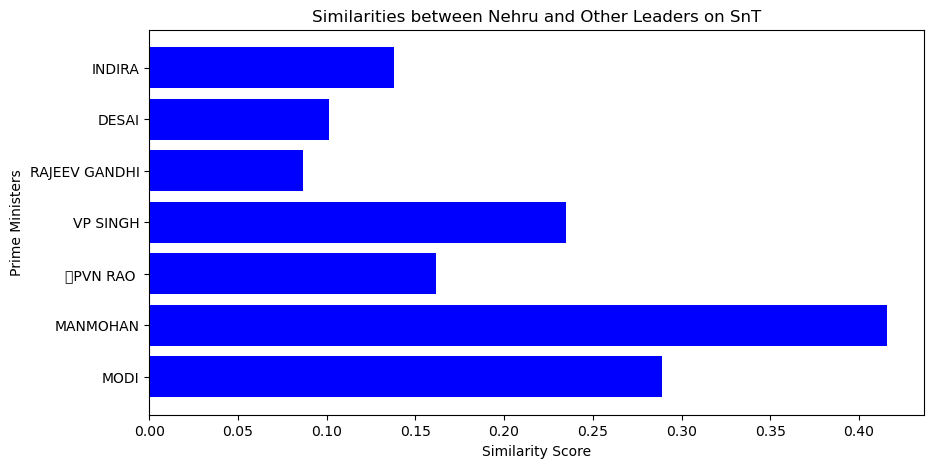

In [195]:
# Paths to the document
file_path = r"C:/Users/HP/Downloads/pmcomp.xlsx"
df2 = pd.read_excel(file_path)

# Compute average word vectors for each topic column
nehrus_vectors = {}
columns = ['E', 'IANS', 'IR', 'C', 'PA', 'SnT']

for column in columns:
    avg_vectors = compute_avg_vectors(df2, column, word2vec_model)
    nehrus_vector = avg_vectors.pop('NEHRU', None)  # Get Nehru's vector and remove it from avg_vectors
    nehrus_vectors[column] = nehrus_vector
    similarities = compute_similarity(nehrus_vector, avg_vectors)
    
    # Plot the similarities for each column
    plot_similarity(similarities, f'Similarities between Nehru and Other Leaders on {column}')


In [196]:
def display_avg_word_vectors(avg_vectors):
    for pm, vector in avg_vectors.items():
        print(f"{pm}: {vector}")

# Example usage to display Nehru's vectors
display_avg_word_vectors(nehrus_vectors)


E: [ 1.69921875e-01  4.90722656e-02  8.15429688e-02  1.20117188e-01
 -1.47460938e-01  2.91748047e-02  3.65234375e-01 -1.01074219e-01
  1.25000000e-01  4.51660156e-02  8.30078125e-02 -2.94921875e-01
  8.30078125e-02 -1.42578125e-01 -1.37695312e-01  3.88671875e-01
  8.98437500e-02  6.07967377e-05  6.10351562e-02 -2.67578125e-01
  8.15429688e-02  2.26562500e-01  2.48046875e-01 -3.01513672e-02
  7.56835938e-03  1.76757812e-01 -1.32446289e-02  6.64062500e-02
 -1.03027344e-01 -5.90820312e-02 -3.07617188e-02  1.19140625e-01
  1.80664062e-01  1.13769531e-01  3.16406250e-01  1.40625000e-01
  1.82617188e-01 -5.61523438e-02  1.11816406e-01  2.47070312e-01
 -9.13085938e-02  7.53784180e-03  1.54296875e-01  6.93359375e-02
 -1.48437500e-01  1.52343750e-01 -5.73730469e-02 -8.78906250e-02
 -1.85546875e-01  1.67968750e-01 -1.68945312e-01  7.61718750e-02
 -5.40161133e-03 -2.28515625e-01  1.69921875e-01  1.33789062e-01
 -9.81445312e-02  3.44238281e-02  9.03320312e-02 -7.17773438e-02
  1.27929688e-01  1.36

In [197]:
import matplotlib.pyplot as plt
import numpy as np

def plot_similarity(similarities, title):
    pms = list(similarities.keys())
    scores = list(similarities.values())
    
    # Generate a color map for each Prime Minister
    colors = plt.cm.tab10(np.linspace(0, 1, len(pms)))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pms, scores, color=colors)

    # Add similarity scores on top of each bar
    for bar, score in zip(bars, scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(score, 2), ha='center', va='bottom', fontsize=10)
    
    plt.ylabel('Similarity Score')
    plt.xlabel('Prime Ministers')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()


C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


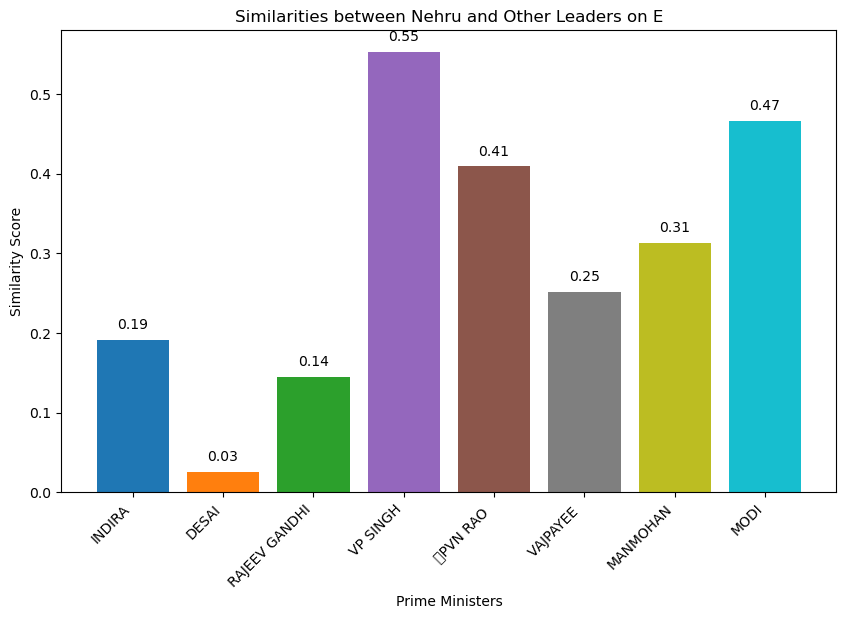

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


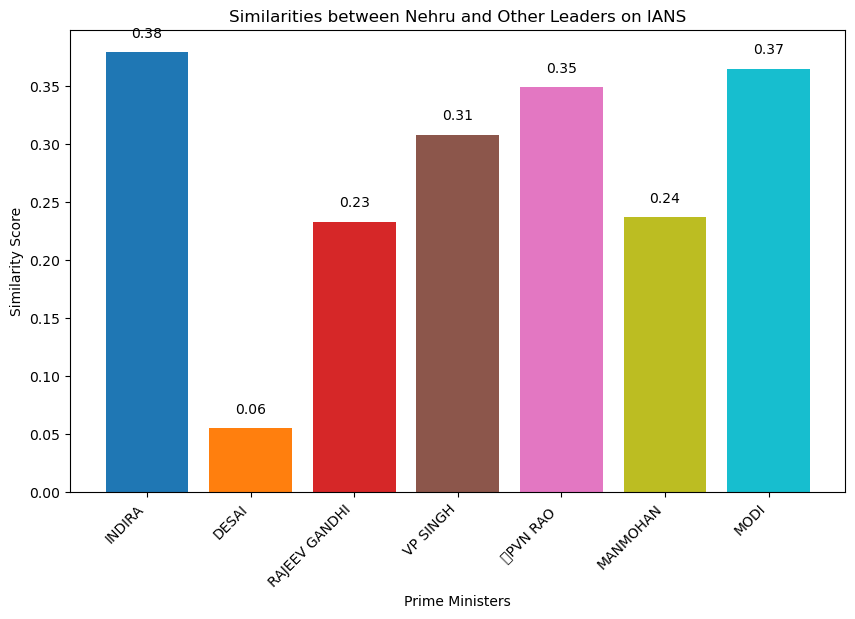

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


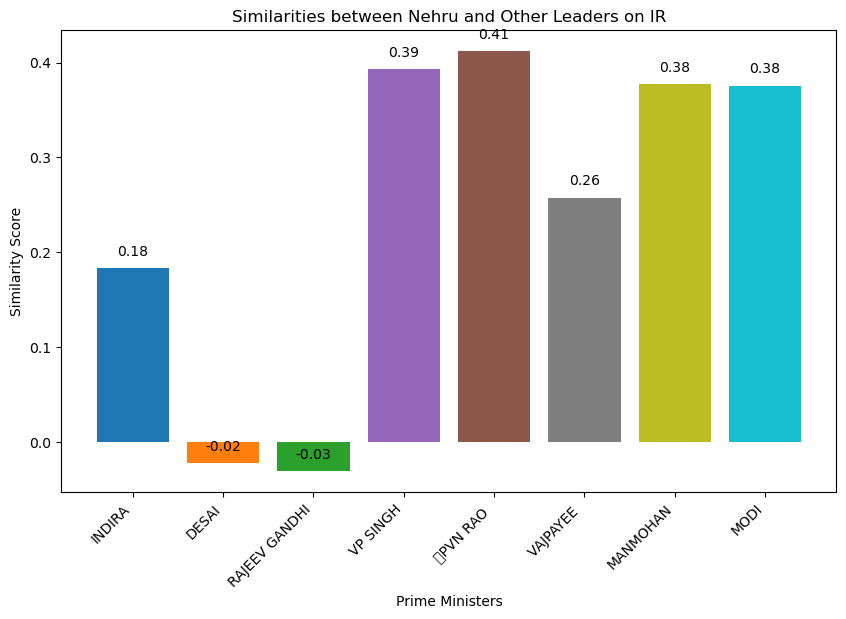

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


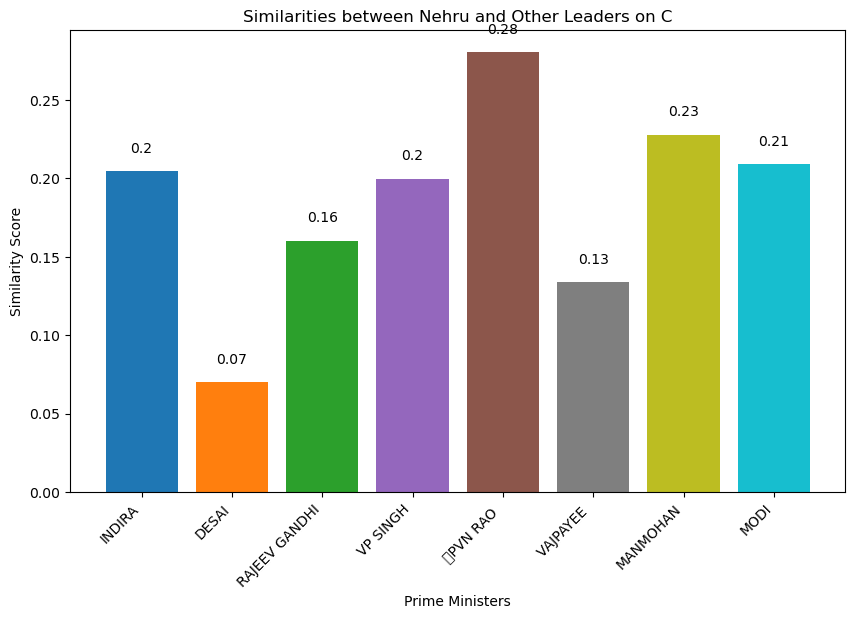

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


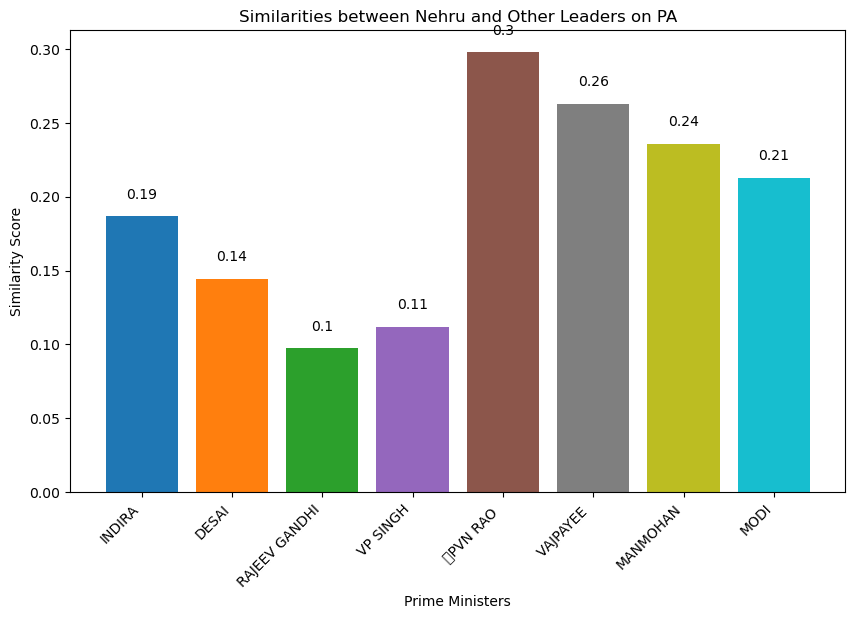

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


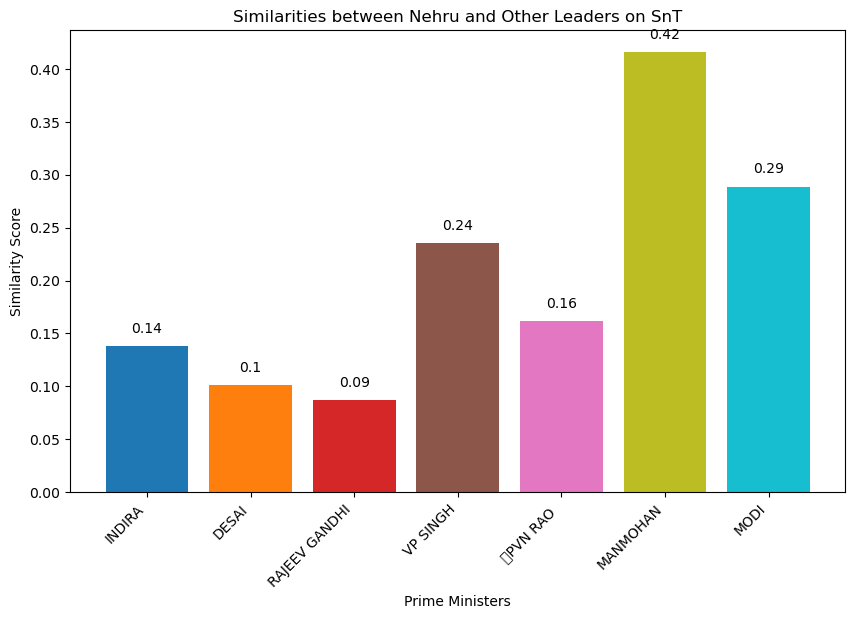

In [199]:
# Paths to the document
file_path = r"C:/Users/HP/Downloads/pmcomp.xlsx"
df2 = pd.read_excel(file_path)

# Compute average word vectors for each topic column
nehrus_vectors = {}
columns = ['E', 'IANS', 'IR', 'C', 'PA', 'SnT']

for column in columns:
    avg_vectors = compute_avg_vectors(df2, column, word2vec_model)
    nehrus_vector = avg_vectors.pop('NEHRU', None)  # Get Nehru's vector and remove it from avg_vectors
    nehrus_vectors[column] = nehrus_vector
    similarities = compute_similarity(nehrus_vector, avg_vectors)
    
    # Plot the similarities for each column
    plot_similarity(similarities, f'Similarities between Nehru and Other Leaders on {column}')


C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


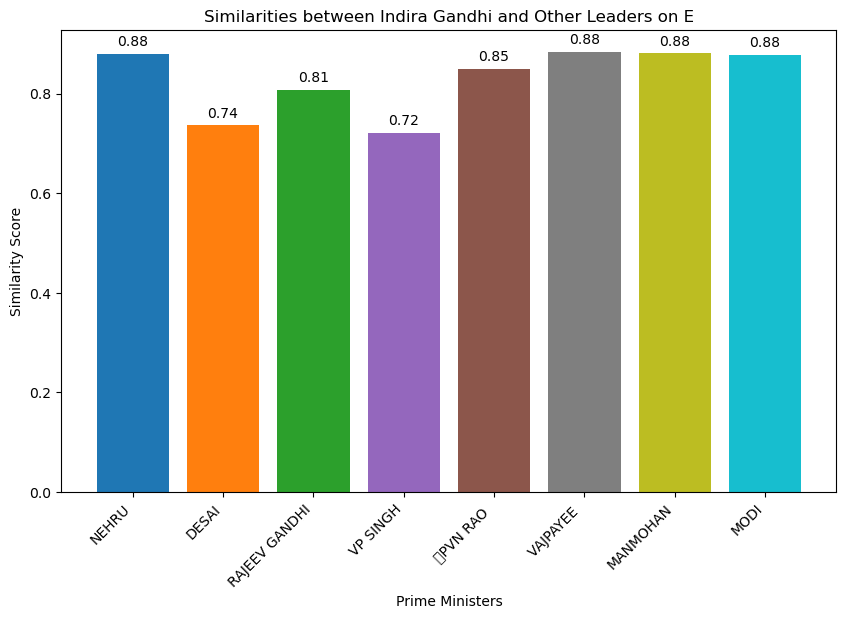

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


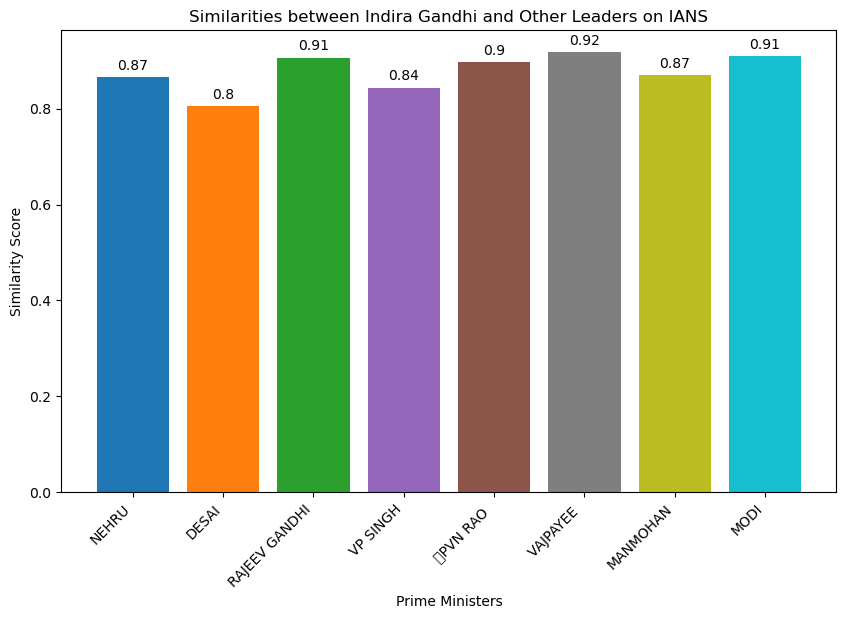

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


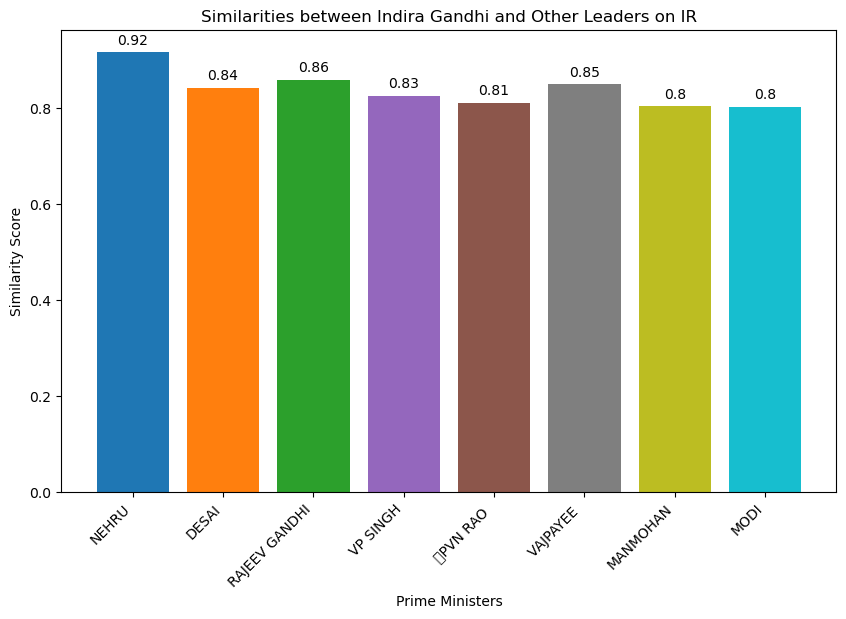

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


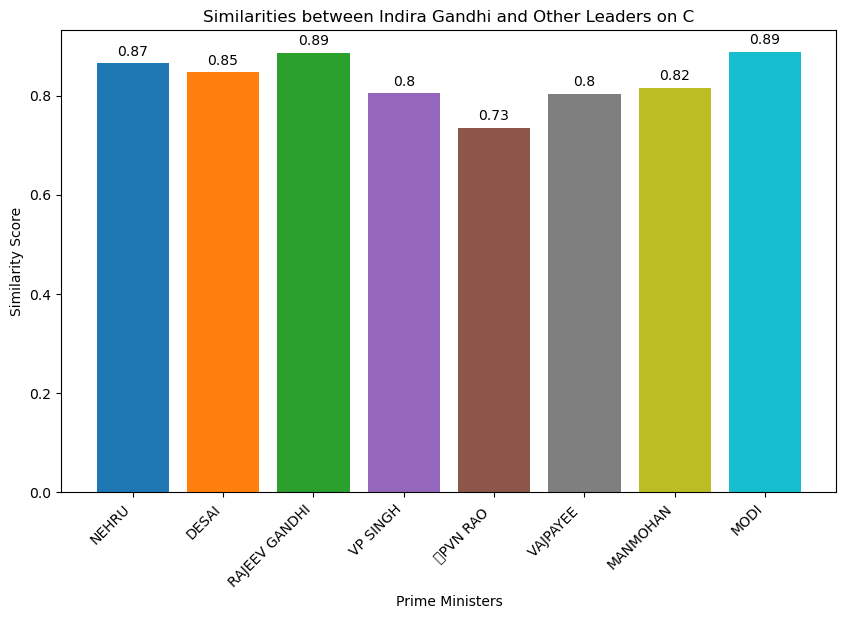

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


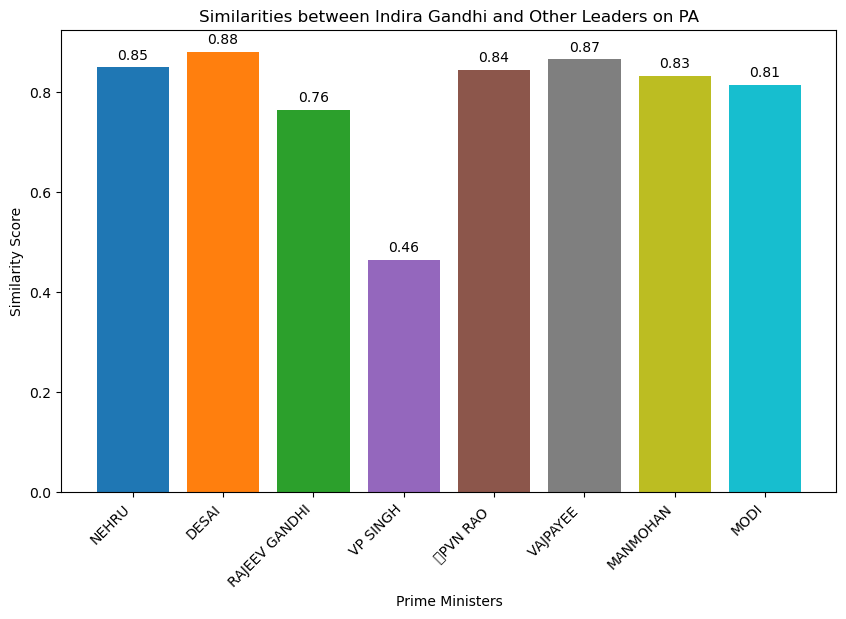

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


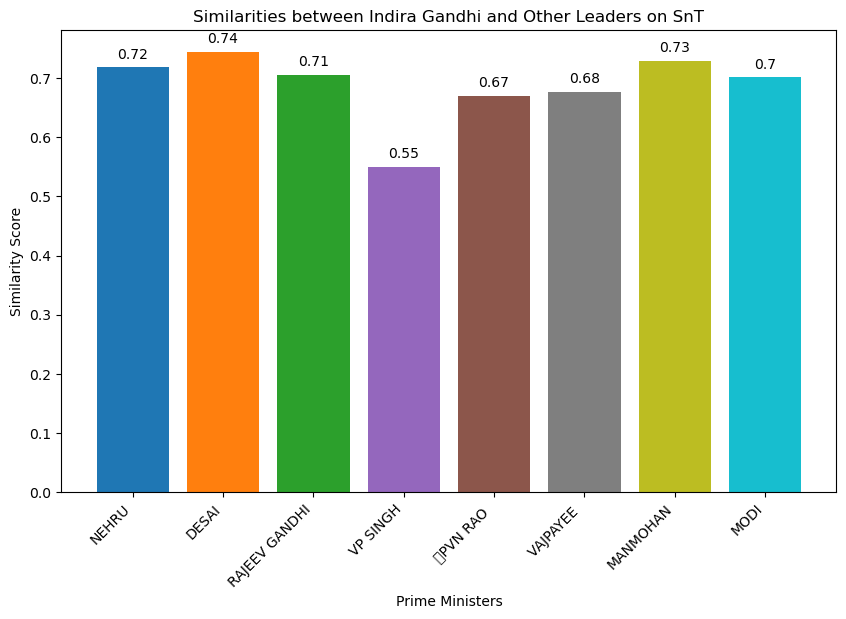

E: [ 0.03470147  0.02848627  0.00496175  0.09399919 -0.04644112 -0.03816625
  0.04566095 -0.08834093  0.07991481  0.05511675 -0.05354883 -0.07916386
 -0.02863272  0.01010998 -0.14328423  0.1067802   0.02994978  0.04930528
 -0.00630848 -0.07326536  0.01454633  0.04171679  0.03079533 -0.01086781
 -0.00237991 -0.02456891 -0.06580471  0.0602425   0.01453302 -0.01653786
 -0.01878047 -0.07064103 -0.01849331 -0.00952883  0.00449618 -0.03898013
  0.03734778  0.01552783  0.05429668  0.06927858  0.0498297  -0.01834353
  0.13009758 -0.017472   -0.06195252 -0.07143132 -0.02934257  0.02939872
 -0.09792551  0.02668011  0.04896804 -0.01815165  0.00268015 -0.03045402
  0.03584863 -0.01082049 -0.08693495 -0.01666787  0.02967041 -0.07155248
 -0.0374305   0.07725789 -0.07869451 -0.04684724  0.04066961 -0.01791405
 -0.03538284  0.06809435  0.04192484  0.07010037 -0.01416056 -0.03420909
  0.09826789 -0.00544656 -0.10479772 -0.03559864  0.04241117  0.05846697
  0.02931592  0.04850367  0.06116293 -0.03345989

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

# Assuming word2vec model is loaded as 'word2vec_model'

def extract_and_preprocess(text):
    """Helper function to preprocess and split text."""
    return [word.strip().strip('"') for word in text.split(',') if word.strip()]

def average_word_vector(words, model, num_features=300):
    """Compute average word vector for a list of words."""
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model:
            num_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

def compute_avg_vectors(df, column, model):
    """Compute average word vectors for a given column."""
    avg_vectors = {}
    for idx, row in df.iterrows():
        words = extract_and_preprocess(row[column])
        avg_vectors[row['PRIME MINISTER COMPARISON']] = average_word_vector(words, model)
    return avg_vectors

def compute_similarity(target_vector, pm_vectors):
    """Compute similarity scores between target vector and other vectors."""
    similarities = {}
    for pm, vector in pm_vectors.items():
        if np.linalg.norm(target_vector) != 0 and np.linalg.norm(vector) != 0:  # Avoid zero vectors
            similarity = cosine_similarity([target_vector], [vector])[0][0]
            similarities[pm] = similarity
    return similarities

def plot_similarity(similarities, title):
    """Plot similarity scores as a bar chart."""
    pms = list(similarities.keys())
    scores = list(similarities.values())
    
    # Generate a color map for each Prime Minister
    colors = plt.cm.tab10(np.linspace(0, 1, len(pms)))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pms, scores, color=colors)

    # Add similarity scores on top of each bar
    for bar, score in zip(bars, scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(score, 2), ha='center', va='bottom', fontsize=10)
    
    plt.ylabel('Similarity Score')
    plt.xlabel('Prime Ministers')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()

# Load the document
file_path = r"C:/Users/HP/Downloads/pmcomp.xlsx"
df2 = pd.read_excel(file_path)

# Compute average word vectors for each topic column
indiras_vectors = {}
columns = ['E', 'IANS', 'IR', 'C', 'PA', 'SnT']

for column in columns:
    avg_vectors = compute_avg_vectors(df2, column, word2vec_model)
    indiras_vector = avg_vectors.pop('INDIRA', None)  # Get Indira Gandhi's vector and remove it from avg_vectors
    indiras_vectors[column] = indiras_vector
    similarities = compute_similarity(indiras_vector, avg_vectors)
    
    # Plot the similarities for each column
    plot_similarity(similarities, f'Similarities between Indira Gandhi and Other Leaders on {column}')

def display_avg_word_vectors(avg_vectors):
    """Display average word vectors for debugging."""
    for pm, vector in avg_vectors.items():
        print(f"{pm}: {vector}")

# Example usage to display Indira Gandhi's vectors
display_avg_word_vectors(indiras_vectors)


C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


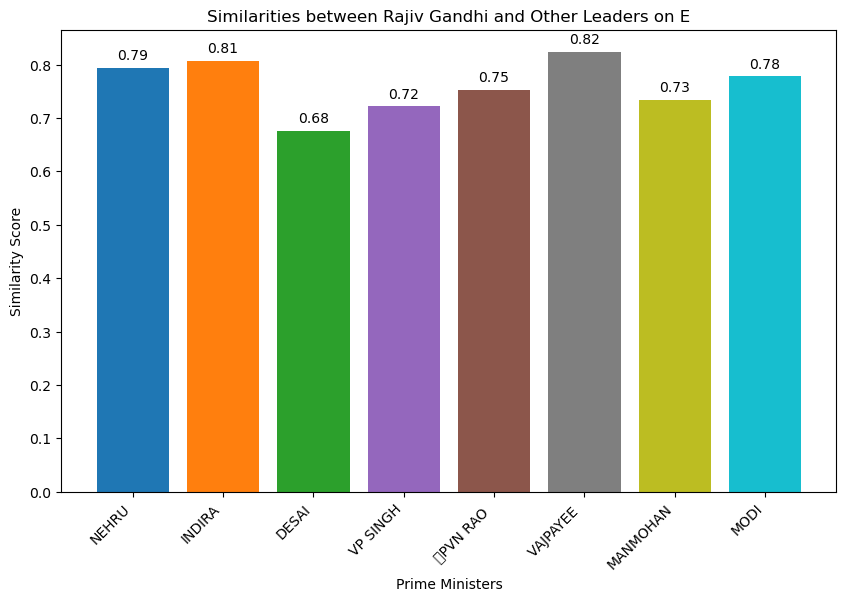

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


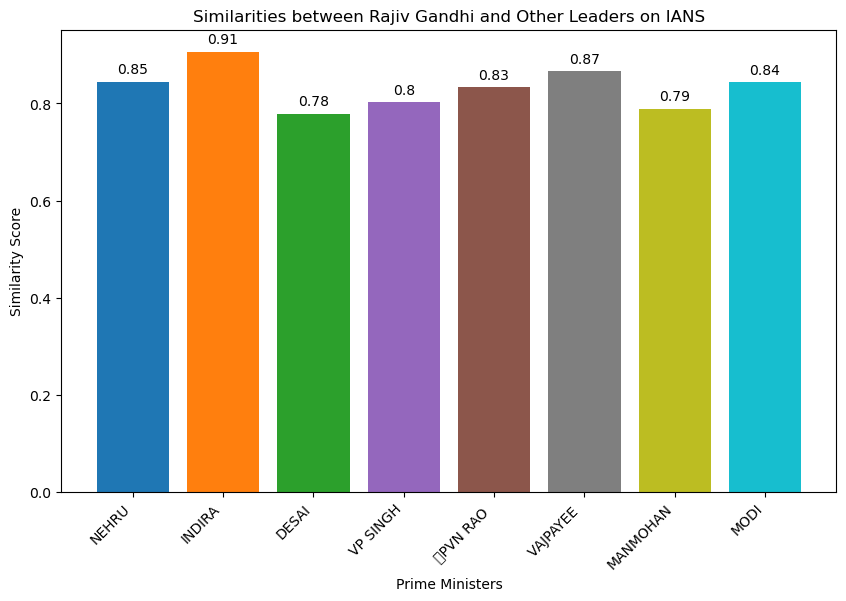

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


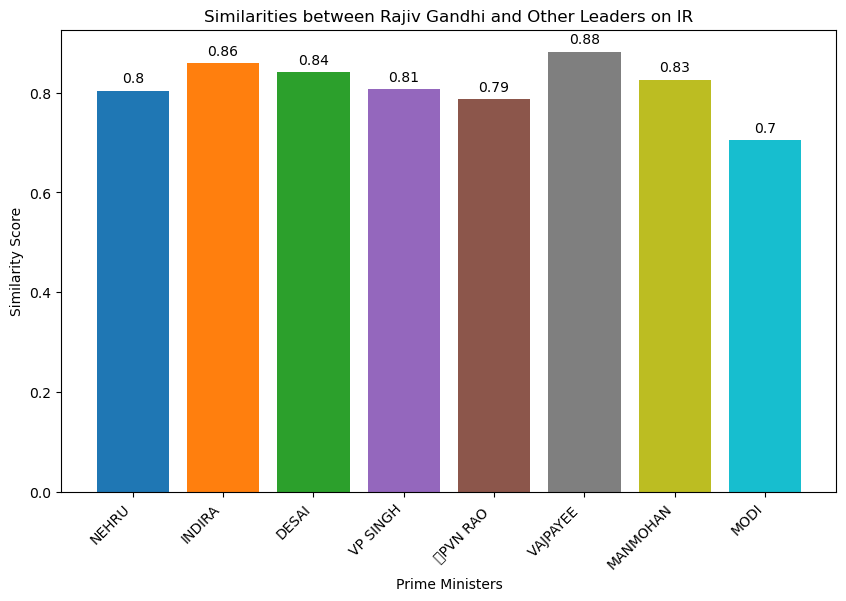

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


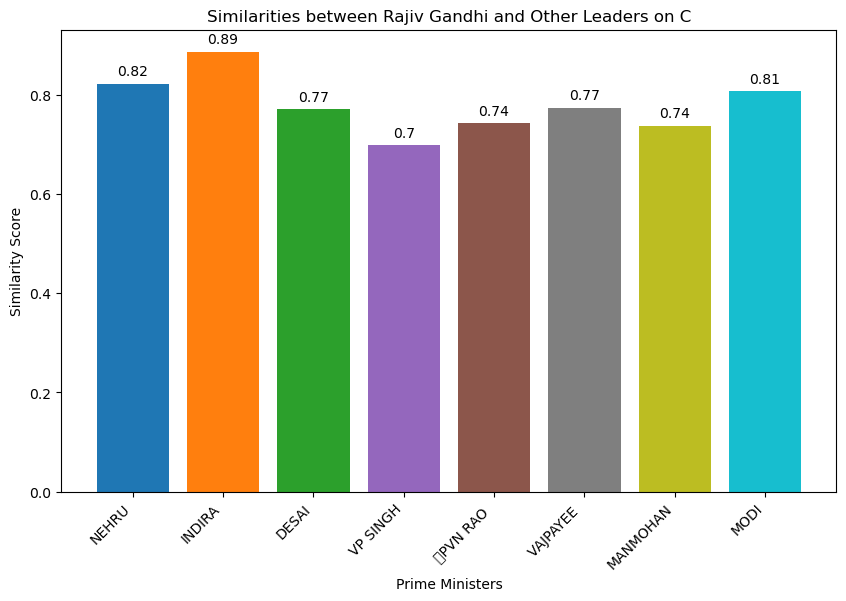

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


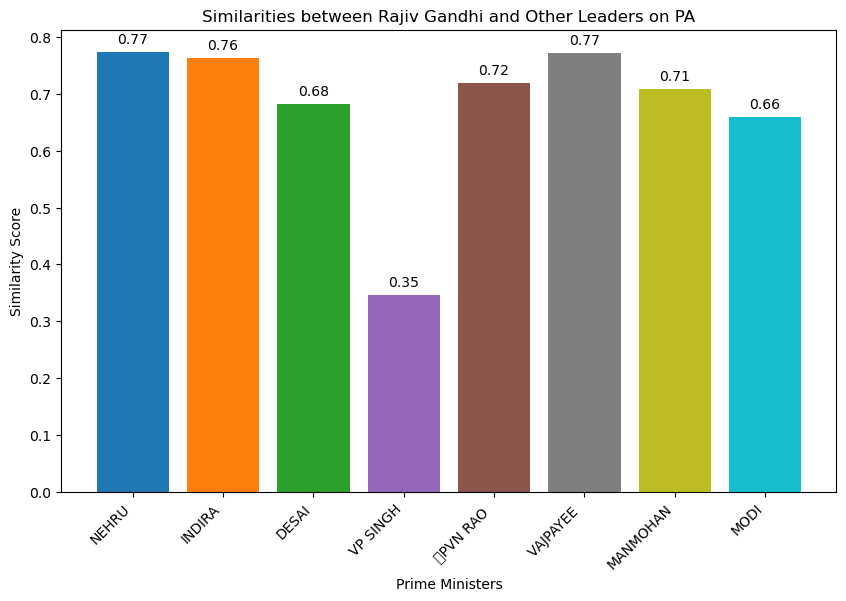

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


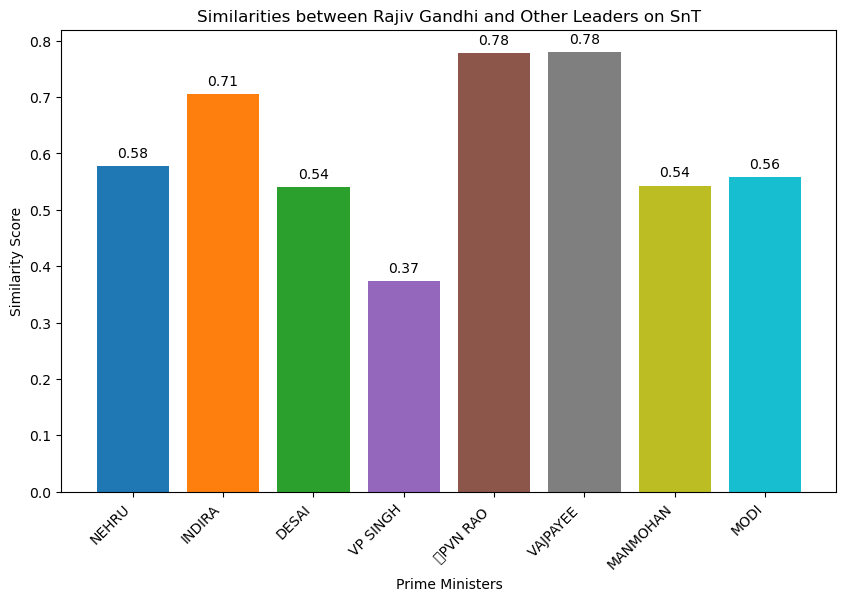

E: [ 0.0259225  -0.00736782  0.03337678  0.07224818 -0.04778266 -0.05368187
  0.01520211 -0.04562523  0.03997657 -0.0431544  -0.03114537 -0.05059705
 -0.04396857 -0.06586856 -0.17978051  0.0815644   0.05524408  0.06797572
  0.01826295 -0.04463559  0.04336112  0.00774565  0.05922445 -0.00955636
  0.00232079 -0.03353155 -0.10425386  0.0969558   0.06779553 -0.059518
 -0.04260835 -0.09248861 -0.05783118 -0.00380997 -0.00617182 -0.0007208
  0.06035796 -0.02425711  0.00739979  0.0509629  -0.01222156 -0.01487187
  0.10064443  0.04082961 -0.0304362  -0.12693132 -0.06015378 -0.02556356
 -0.09741792  0.00494094  0.10050455 -0.02060082  0.05280413  0.051752
  0.06999715 -0.053243   -0.05410621  0.03136771  0.01917993 -0.07136609
 -0.07718622  0.05428496 -0.10611398 -0.0153983   0.01736886  0.01192456
 -0.04568481  0.10041155  0.05155727  0.00229318 -0.11150832  0.05054583
  0.14056687  0.02227493 -0.09362357 -0.05287243  0.01640392  0.08266776
 -0.02123733  0.10117885  0.04735165 -0.06859189  0.0

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

# Assuming word2vec model is loaded as 'word2vec_model'

def average_word_vector(words, model, num_features=300):
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model:
            num_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

def extract_and_preprocess(text):
    # Assuming text is a string with words separated by commas
    return [word.strip().lower().replace('"', '') for word in text.split(',')]

def compute_avg_vectors(df, column, model):
    avg_vectors = {}
    for idx, row in df.iterrows():
        words = extract_and_preprocess(row[column])
        avg_vectors[row['PRIME MINISTER COMPARISON']] = average_word_vector(words, model)
    return avg_vectors

def compute_similarity(target_vector, pm_vectors):
    similarities = {}
    for pm, vector in pm_vectors.items():
        if np.linalg.norm(target_vector) != 0 and np.linalg.norm(vector) != 0:  # Avoid zero vectors
            similarity = cosine_similarity([target_vector], [vector])[0][0]
            similarities[pm] = similarity
    return similarities

def plot_similarity(similarities, title):
    pms = list(similarities.keys())
    scores = list(similarities.values())
    
    # Generate a color map for each Prime Minister
    colors = plt.cm.tab10(np.linspace(0, 1, len(pms)))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pms, scores, color=colors)

    # Add similarity scores on top of each bar
    for bar, score in zip(bars, scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(score, 2), ha='center', va='bottom', fontsize=10)
    
    plt.ylabel('Similarity Score')
    plt.xlabel('Prime Ministers')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()

# Paths to the document
file_path = r"C:/Users/HP/Downloads/pmcomp.xlsx"
df2 = pd.read_excel(file_path)

# Compute average word vectors for each topic column
raajiv_vectors = {}
columns = ['E', 'IANS', 'IR', 'C', 'PA', 'SnT']

for column in columns:
    avg_vectors = compute_avg_vectors(df2, column, word2vec_model)
    raajiv_vector = avg_vectors.pop('RAJEEV GANDHI', None)  # Get Rajiv Gandhi's vector and remove it from avg_vectors
    raajiv_vectors[column] = raajiv_vector
    similarities = compute_similarity(raajiv_vector, avg_vectors)
    
    # Plot the similarities for each column
    plot_similarity(similarities, f'Similarities between Rajiv Gandhi and Other Leaders on {column}')

def display_avg_word_vectors(avg_vectors):
    for pm, vector in avg_vectors.items():
        print(f"{pm}: {vector}")

# Example usage to display Rajiv Gandhi's vectors
display_avg_word_vectors(raajiv_vectors)


C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


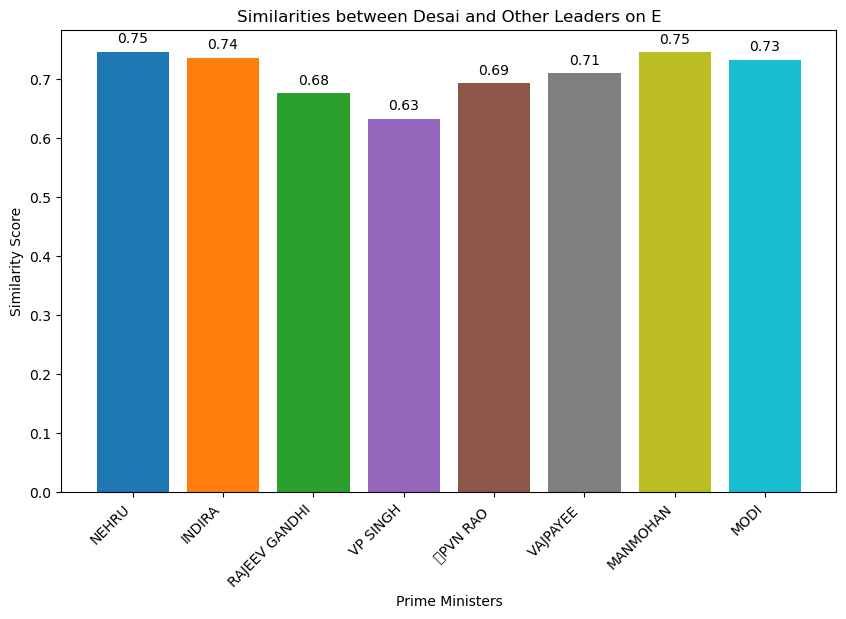

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


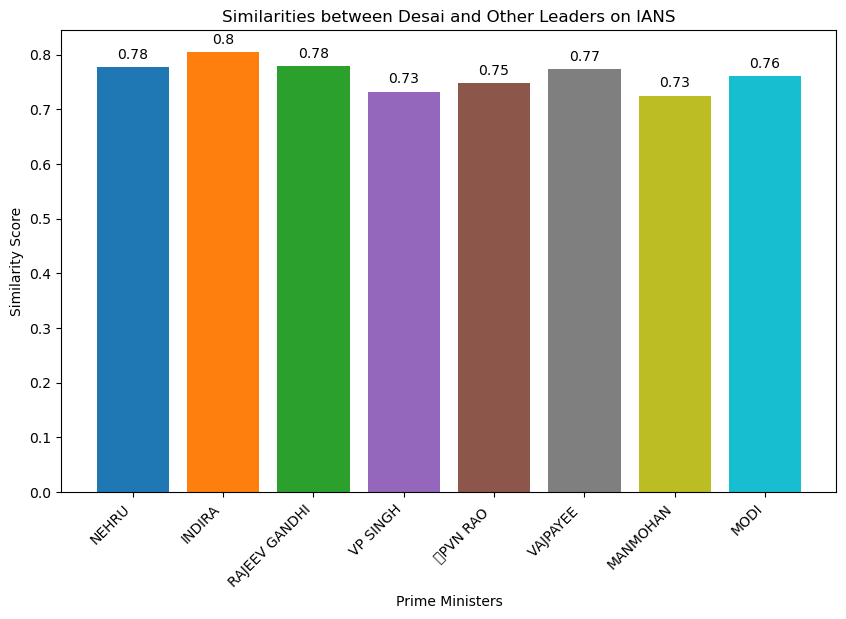

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


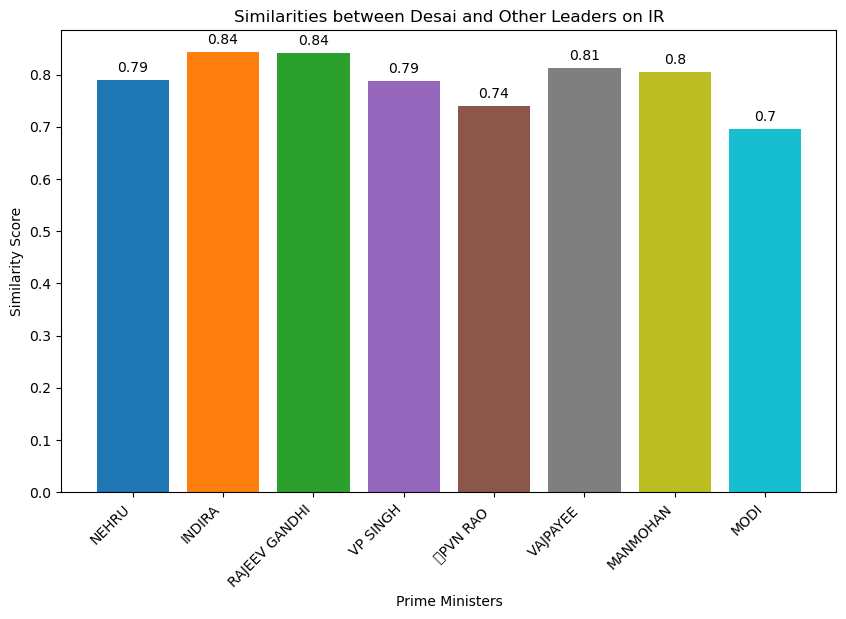

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


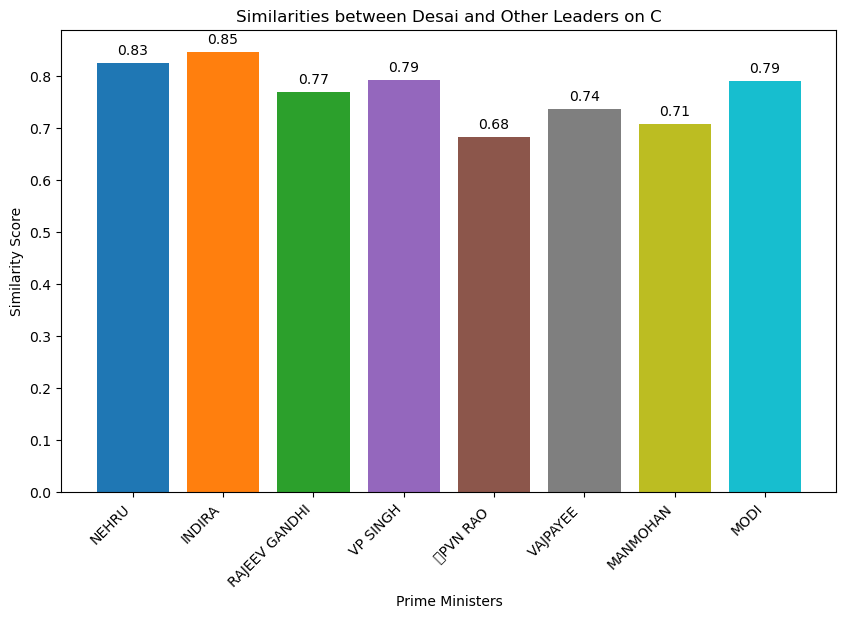

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


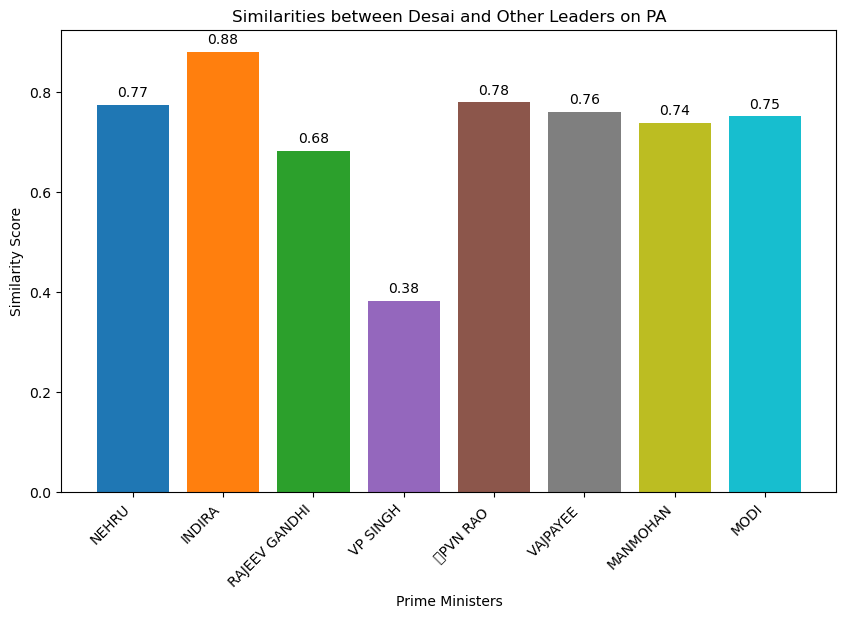

C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


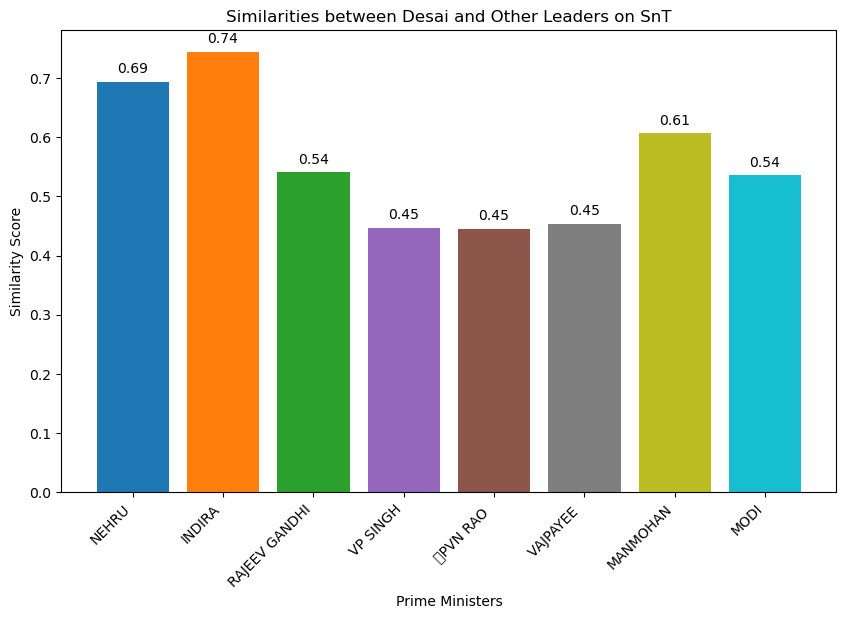

E: [-2.99536139e-02 -1.22155761e-02  7.16155991e-02  6.45046979e-02
 -1.00056455e-02 -6.58911169e-02  4.24542241e-02 -9.28515643e-02
  8.64392072e-02  8.30224603e-02 -5.64624034e-02 -4.99340817e-02
 -1.28540036e-03  4.23521139e-02 -9.36767608e-02  1.47387087e-01
  2.23388663e-03  1.14538565e-01  7.84954801e-02 -8.54101554e-02
 -1.07910158e-03  1.92041025e-02  4.05273438e-02 -5.95416278e-02
  2.43225098e-02  1.59359742e-02 -1.19836427e-01  6.05322272e-02
  9.04418901e-03 -2.49121096e-02 -7.08984397e-03 -5.55975325e-02
 -5.27221672e-02  3.31341550e-02  1.11520998e-01 -4.00146469e-03
  5.05700670e-02  2.27148440e-02  6.65866062e-02  7.77148455e-02
  7.81250000e-03  1.11975102e-02  1.24375001e-01  6.78173825e-02
 -6.02587909e-02 -6.04394525e-02 -1.21874996e-02  2.96069328e-02
 -1.73070073e-01  9.54541042e-02  2.92626955e-02  4.56347652e-02
 -1.98693853e-02 -2.82092281e-02 -2.77929679e-02 -3.01220696e-02
 -1.71152338e-01 -9.45978146e-03 -1.85498055e-02 -6.08636476e-02
 -1.05483398e-01  4.03

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

# Assuming word2vec model is loaded as 'word2vec_model'

def average_word_vector(words, model, num_features=300):
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model:
            num_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

def extract_and_preprocess(text):
    # Process the text: remove quotes, split by commas, etc.
    words = text.replace('"', '').split(',')
    return [word.strip() for word in words if word.strip()]

def compute_avg_vectors(df, column, model):
    avg_vectors = {}
    for idx, row in df.iterrows():
        words = extract_and_preprocess(row[column])
        avg_vectors[row['PRIME MINISTER COMPARISON']] = average_word_vector(words, model)
    return avg_vectors

def compute_similarity(target_vector, avg_vectors):
    similarities = {}
    for pm, vector in avg_vectors.items():
        if np.linalg.norm(target_vector) != 0 and np.linalg.norm(vector) != 0:  # Avoid zero vectors
            similarity = cosine_similarity([target_vector], [vector])[0][0]
            similarities[pm] = similarity
    return similarities

def plot_similarity(similarities, title):
    pms = list(similarities.keys())
    scores = list(similarities.values())
    
    # Generate a color map for each Prime Minister
    colors = plt.cm.tab10(np.linspace(0, 1, len(pms)))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pms, scores, color=colors)

    # Add similarity scores on top of each bar
    for bar, score in zip(bars, scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(score, 2), ha='center', va='bottom', fontsize=10)
    
    plt.ylabel('Similarity Score')
    plt.xlabel('Prime Ministers')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()

# Load the Excel file into a DataFrame
file_path = r"C:/Users/HP/Downloads/pmcomp.xlsx"
df2 = pd.read_excel(file_path)

# Compute average word vectors for each topic column
desais_vectors = {}
columns = ['E', 'IANS', 'IR', 'C', 'PA', 'SnT']

for column in columns:
    avg_vectors = compute_avg_vectors(df2, column, word2vec_model)
    desais_vector = avg_vectors.pop('DESAI', None)  # Get Desai's vector and remove it from avg_vectors
    desais_vectors[column] = desais_vector
    similarities = compute_similarity(desais_vector, avg_vectors)
    
    # Plot the similarities for each column
    plot_similarity(similarities, f'Similarities between Desai and Other Leaders on {column}')

def display_avg_word_vectors(avg_vectors):
    for pm, vector in avg_vectors.items():
        print(f"{pm}: {vector}")

# Example usage to display Desai's vectors
display_avg_word_vectors(desais_vectors)


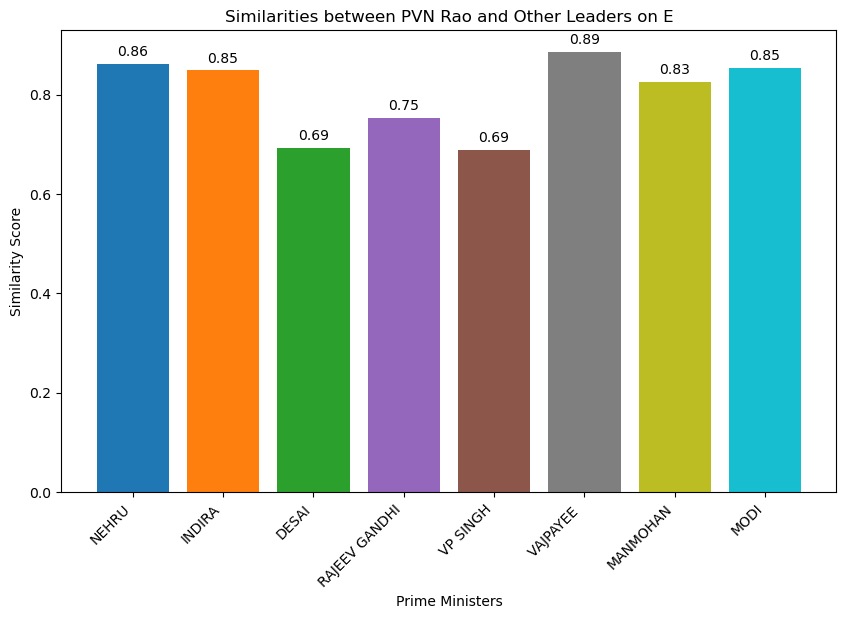

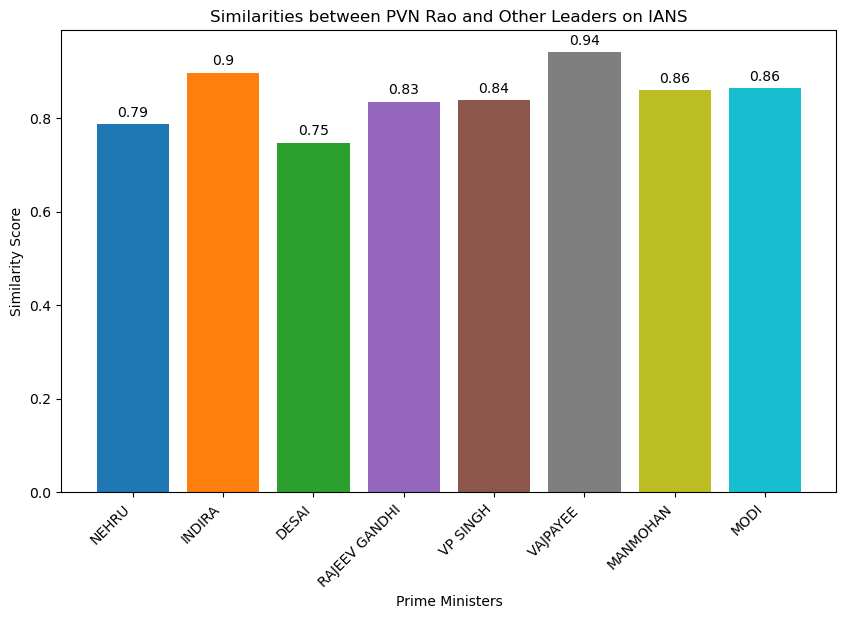

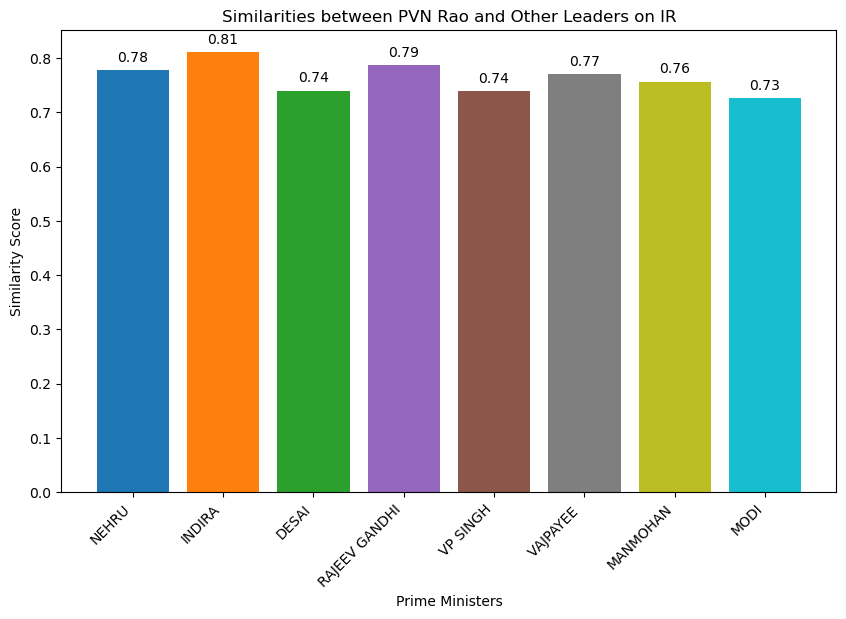

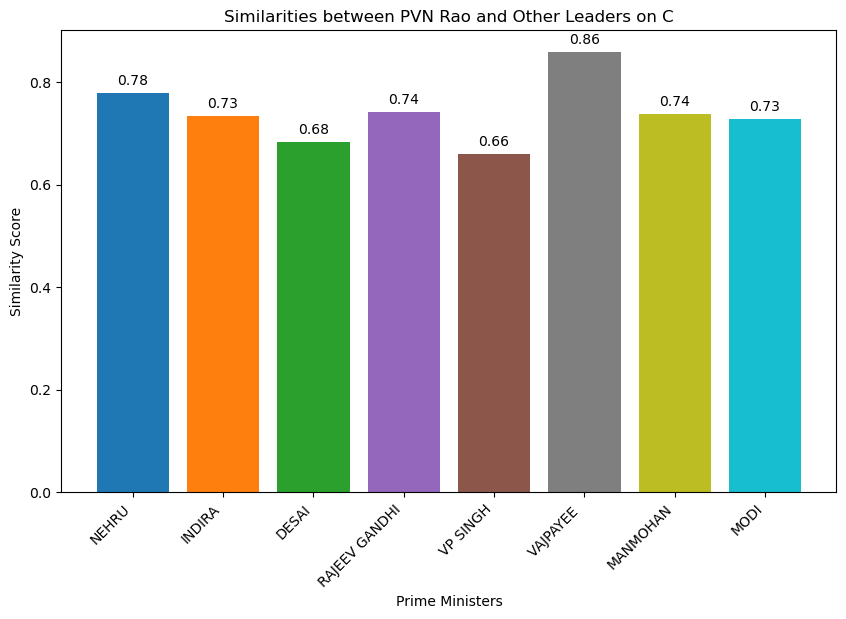

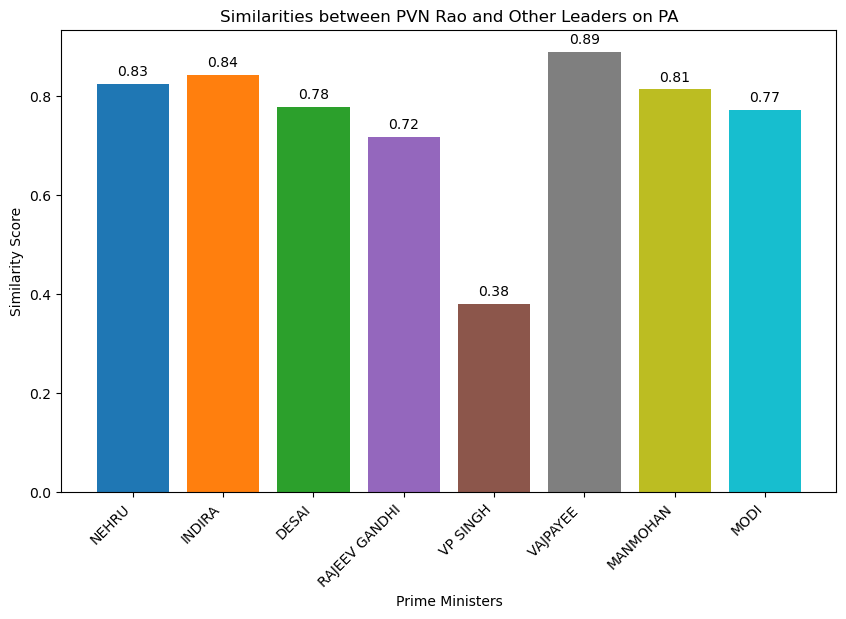

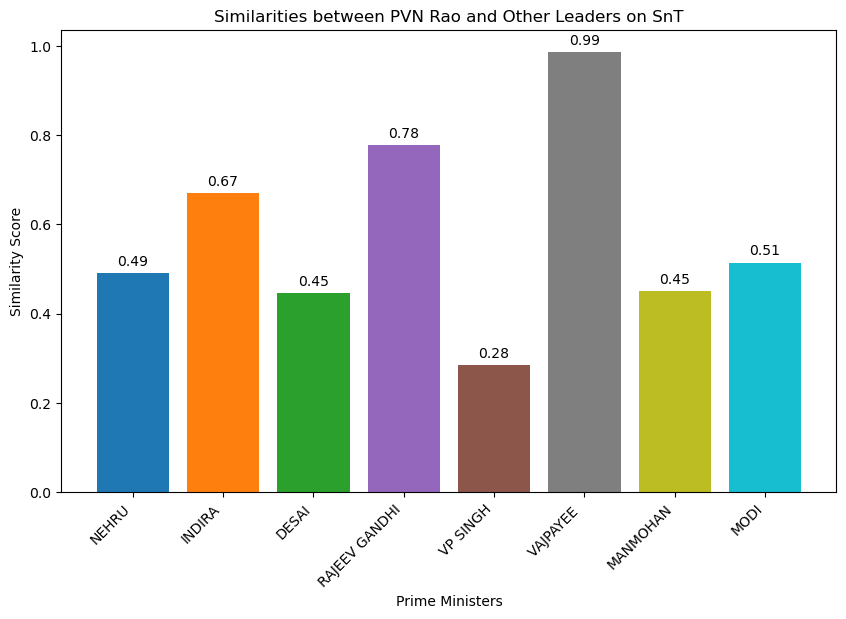

E: [ 0.00744045  0.03446279  0.00977342  0.02908763 -0.0680377  -0.02793267
  0.08584457 -0.10455436  0.05238375  0.0202351  -0.02575177 -0.08526104
 -0.04960827  0.02986356 -0.18366647  0.08268056 -0.01297677  0.07218413
  0.04069487 -0.01850015 -0.03874888  0.01208431  0.01685739  0.02747118
  0.05128796  0.02037941 -0.08514173  0.00905236  0.01212197  0.00149309
 -0.02707307 -0.0406348  -0.02493611  0.00702489  0.00731513 -0.02585488
  0.04458589 -0.00021687  0.03831579  0.05325761  0.0704698   0.01586135
  0.08515703  0.04071305 -0.04932095 -0.0825059  -0.07506301  0.01458107
 -0.12799916  0.05423038  0.05552755 -0.01507861 -0.00144082 -0.06050792
 -0.01301218  0.03521209 -0.0421464  -0.05413299  0.04446411 -0.09725635
 -0.0688009   0.00846431 -0.06310305 -0.05801294 -0.00258653 -0.0292261
 -0.05992873  0.07914571 -0.00598664  0.05515306 -0.05618611 -0.02237539
  0.09704719 -0.02714141 -0.06335822 -0.03525105  0.02989911  0.07491903
  0.01607108  0.08174815  0.00263863 -0.02568939 

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

# Assuming word2vec model is loaded as 'word2vec_model'

def average_word_vector(words, model, num_features=300):
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model:
            num_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

def extract_and_preprocess(text):
    # Process the text: remove quotes, split by commas, etc.
    words = text.replace('"', '').split(',')
    return [word.strip() for word in words if word.strip()]

def compute_avg_vectors(df, column, model):
    avg_vectors = {}
    for idx, row in df.iterrows():
        words = extract_and_preprocess(row[column])
        avg_vectors[row['PRIME MINISTER COMPARISON']] = average_word_vector(words, model)
    return avg_vectors

def compute_similarity(target_vector, avg_vectors):
    similarities = {}
    for pm, vector in avg_vectors.items():
        if np.linalg.norm(target_vector) != 0 and np.linalg.norm(vector) != 0:  # Avoid zero vectors
            similarity = cosine_similarity([target_vector], [vector])[0][0]
            similarities[pm] = similarity
    return similarities

def plot_similarity(similarities, title):
    pms = list(similarities.keys())
    scores = list(similarities.values())
    
    # Generate a color map for each Prime Minister
    colors = plt.cm.tab10(np.linspace(0, 1, len(pms)))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pms, scores, color=colors)

    # Add similarity scores on top of each bar
    for bar, score in zip(bars, scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(score, 2), ha='center', va='bottom', fontsize=10)
    
    plt.ylabel('Similarity Score')
    plt.xlabel('Prime Ministers')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()

# Load the Excel file into a DataFrame
file_path = r"C:/Users/HP/Downloads/pmcomp.xlsx"
df2 = pd.read_excel(file_path)

# Compute average word vectors for each topic column
pvn_raos_vectors = {}
columns = ['E', 'IANS', 'IR', 'C', 'PA', 'SnT']

for column in columns:
    avg_vectors = compute_avg_vectors(df2, column, word2vec_model)
    pvn_raos_vector = avg_vectors.pop('PVN RAO', None)  # Get PVN Rao's vector and remove it from avg_vectors
    pvn_raos_vectors[column] = pvn_raos_vector
    similarities = compute_similarity(pvn_raos_vector, avg_vectors)
    
    # Plot the similarities for each column
    plot_similarity(similarities, f'Similarities between PVN Rao and Other Leaders on {column}')

def display_avg_word_vectors(avg_vectors):
    for pm, vector in avg_vectors.items():
        print(f"{pm}: {vector}")

# Example usage to display PVN Rao's vectors
display_avg_word_vectors(pvn_raos_vectors)


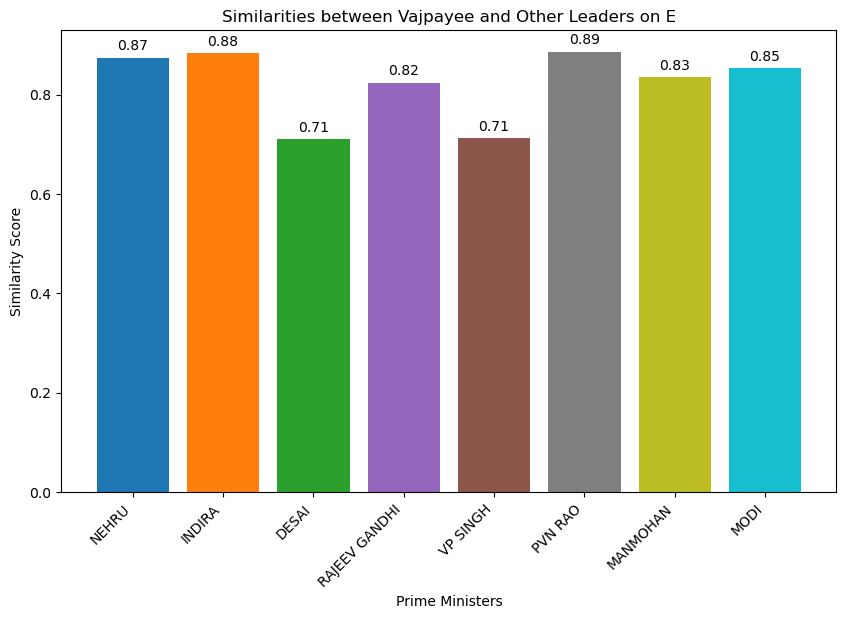

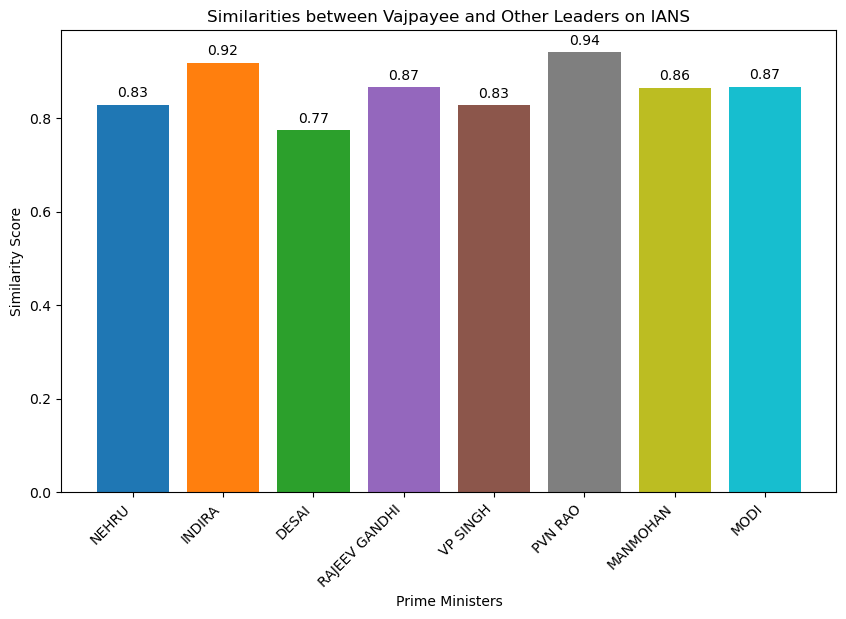

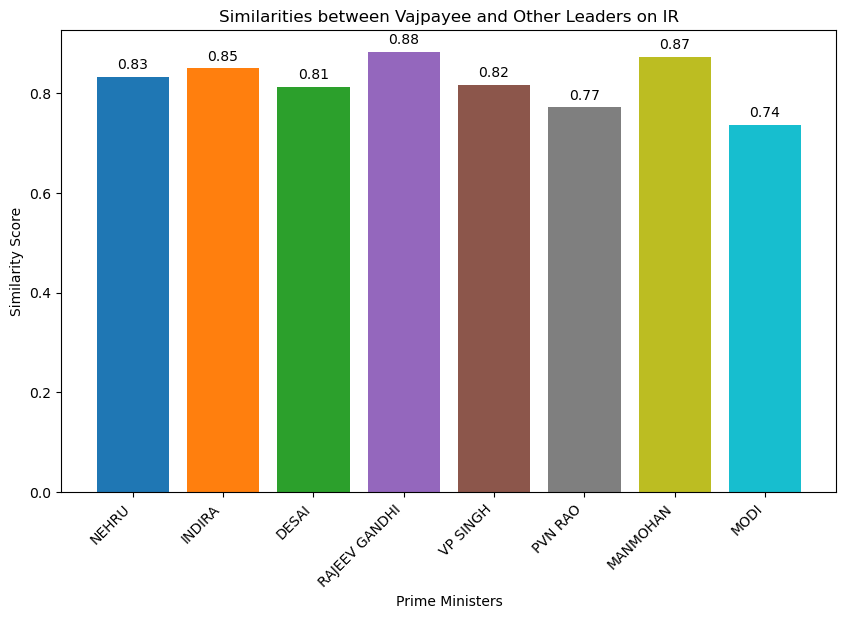

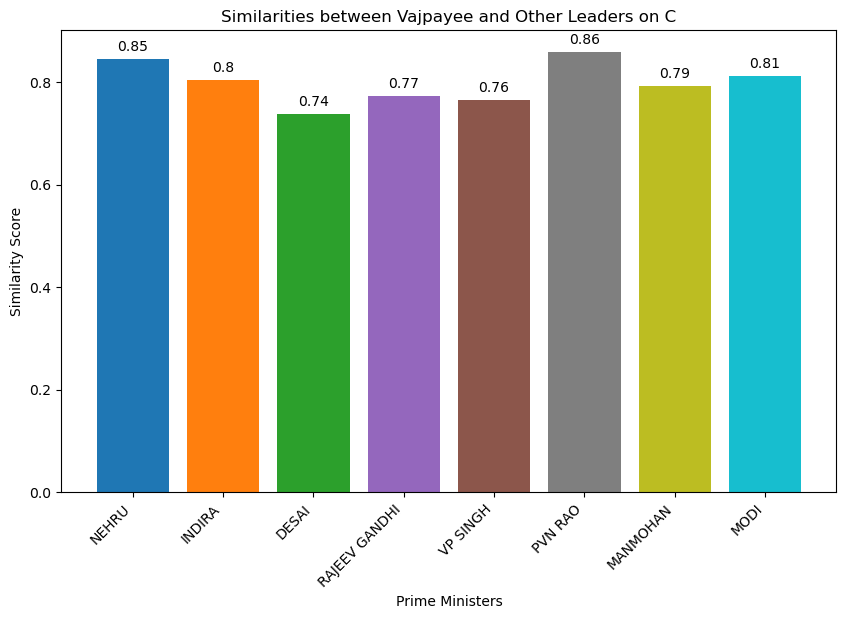

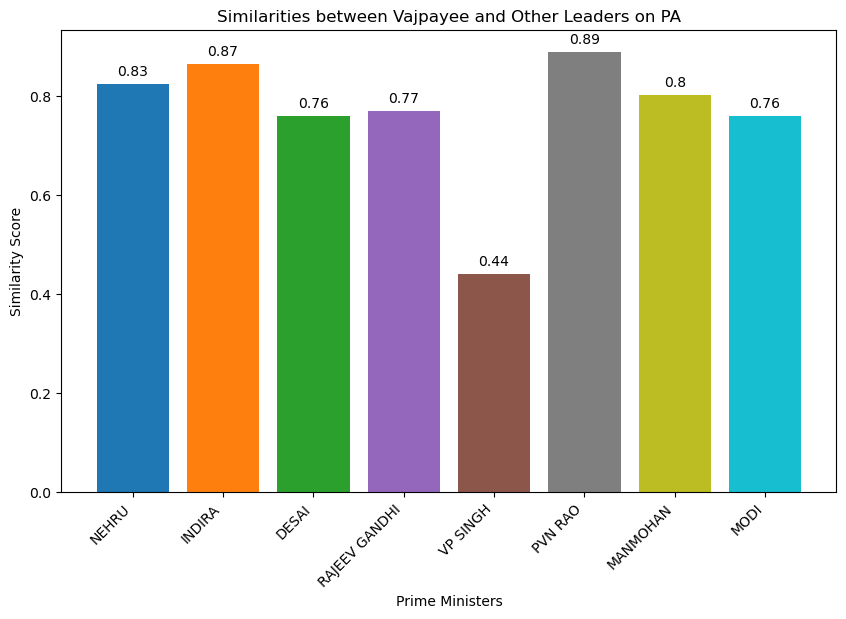

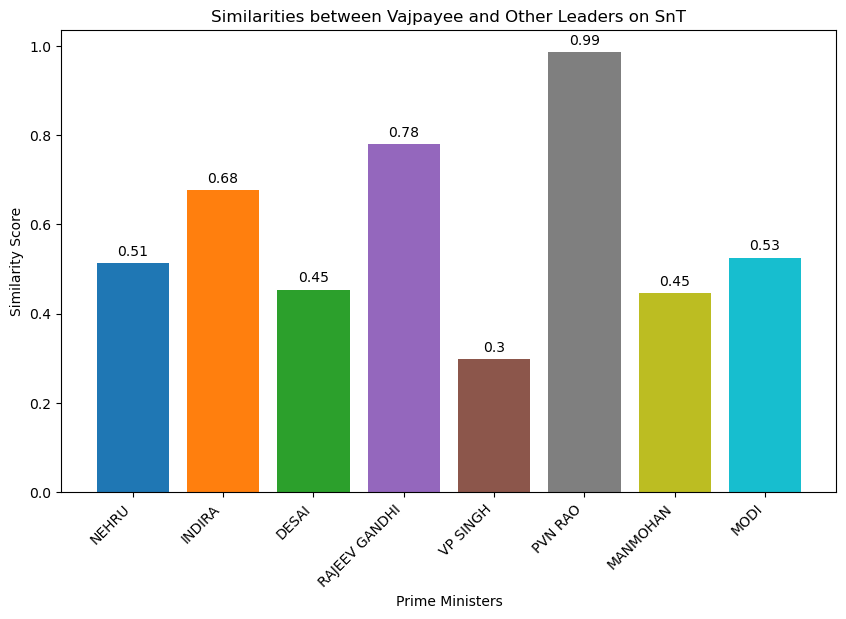

E: [ 0.02344491  0.02965306 -0.00595823  0.06087123 -0.0398556  -0.04634574
  0.07763029 -0.06986629  0.06324768  0.01196551 -0.00659886 -0.08740387
 -0.06112605  0.00558919 -0.17760445  0.11178153 -0.0003917   0.05687081
  0.02404131 -0.05934884  0.00471061  0.00927311  0.03999721  0.0191415
  0.04852949 -0.02481766 -0.08314975  0.03545837  0.02643781 -0.01981702
 -0.02296143 -0.05950906 -0.00508319  0.03162231 -0.01651393 -0.02444763
  0.06448277 -0.02407837  0.07241908  0.04156487  0.01878762 -0.01584603
  0.10094561  0.01526053 -0.08427298 -0.12835039 -0.03453838  0.01949234
 -0.10416391  0.05665981  0.04418542 -0.02795999  0.01766837 -0.01480103
 -0.01918422 -0.00516575 -0.09102412 -0.00461251  0.02237676 -0.12150094
 -0.05328369  0.01765697 -0.08047278 -0.0335022   0.00163596 -0.01789082
 -0.06250523  0.06783665  0.01971784  0.0248679  -0.07812849 -0.01403373
  0.07643346 -0.01974487 -0.0753055  -0.04667358  0.03968222  0.036329
  0.01596418  0.04853516  0.02974243 -0.03933939  0

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

# Assuming word2vec model is loaded as 'word2vec_model'

def average_word_vector(words, model, num_features=300):
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model:
            num_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

def compute_avg_vectors(df, column, model):
    avg_vectors = {}
    for idx, row in df.iterrows():
        if pd.notna(row[column]):  # Ensure there's data in the column
            words = row[column].replace('"', '').split(',')  # Removing quotes and splitting words
            words = [word.strip() for word in words]
            avg_vectors[row['PRIME MINISTER COMPARISON']] = average_word_vector(words, model)
    return avg_vectors

def compute_similarity(target_vector, avg_vectors):
    similarities = {}
    for pm, vector in avg_vectors.items():
        if np.linalg.norm(target_vector) != 0 and np.linalg.norm(vector) != 0:  # Avoid zero vectors
            similarity = cosine_similarity([target_vector], [vector])[0][0]
            similarities[pm] = similarity
    return similarities

def plot_similarity(similarities, title):
    pms = list(similarities.keys())
    scores = list(similarities.values())

    # Generate a color map for each Prime Minister
    colors = plt.cm.tab10(np.linspace(0, 1, len(pms)))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pms, scores, color=colors)

    # Add similarity scores on top of each bar
    for bar, score in zip(bars, scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(score, 2), ha='center', va='bottom', fontsize=10)
    
    plt.ylabel('Similarity Score')
    plt.xlabel('Prime Ministers')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()

# Paths to the document
file_path = r"C:/Users/HP/Downloads/pmcomp.xlsx"
df2 = pd.read_excel(file_path)

# Compute average word vectors for each topic column
vajpayee_vectors = {}
columns = ['E', 'IANS', 'IR', 'C', 'PA', 'SnT']

for column in columns:
    avg_vectors = compute_avg_vectors(df2, column, word2vec_model)
    
    # Check if 'VAJPAYEE' is in the DataFrame and print available names
    if 'VAJPAYEE ' in avg_vectors:
        vajpayee_vector = avg_vectors.pop('VAJPAYEE ', None)  # Get Vajpayee's vector and remove it from avg_vectors
        vajpayee_vectors[column] = vajpayee_vector
        similarities = compute_similarity(vajpayee_vector, avg_vectors)
        
        # Plot the similarities for each column
        plot_similarity(similarities, f'Similarities between Vajpayee and Other Leaders on {column}')
    else:
        print(f"'VAJPAYEE' not found in the column '{column}'")
        print("Available PM names:", avg_vectors.keys())

def display_avg_word_vectors(avg_vectors):
    for pm, vector in avg_vectors.items():
        print(f"{pm}: {vector}")

# Example usage to display Vajpayee's vectors
display_avg_word_vectors(vajpayee_vectors)


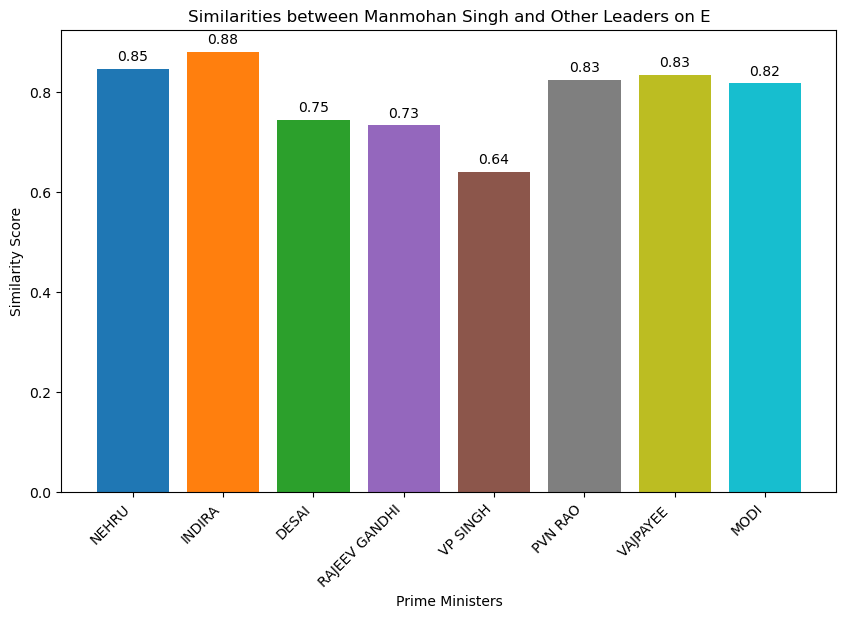

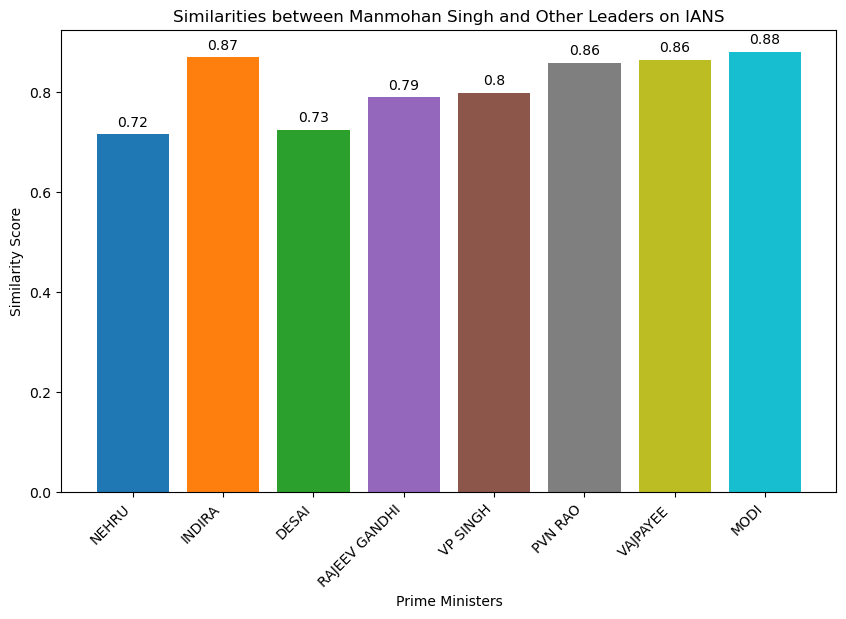

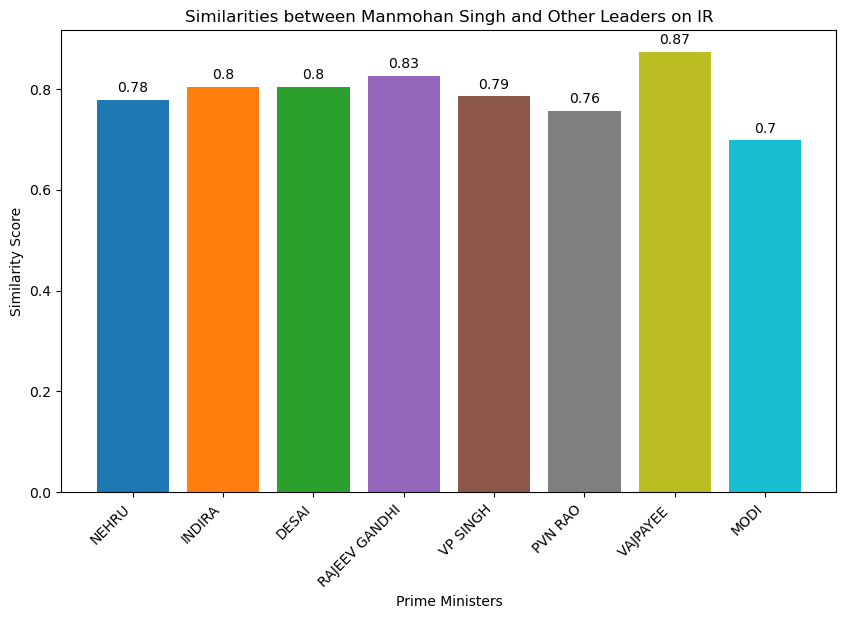

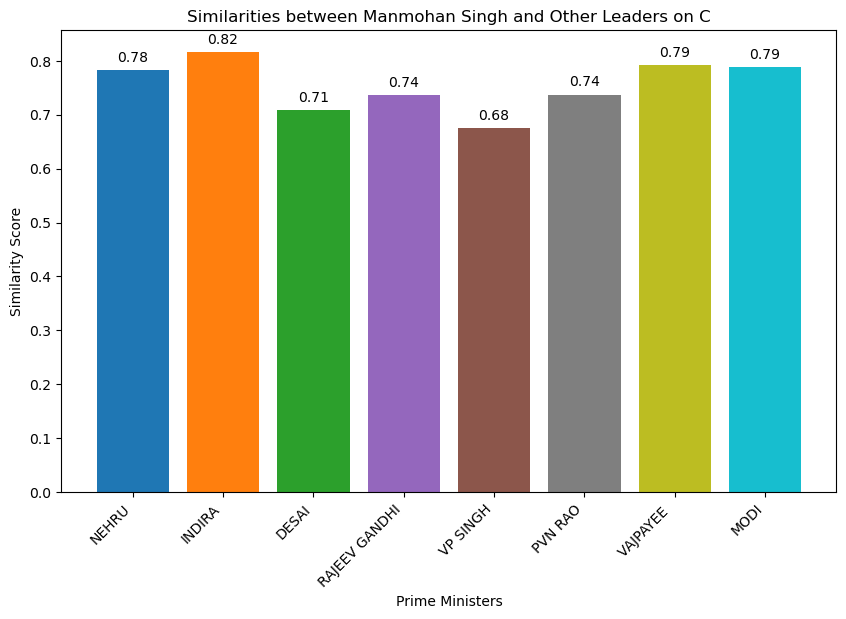

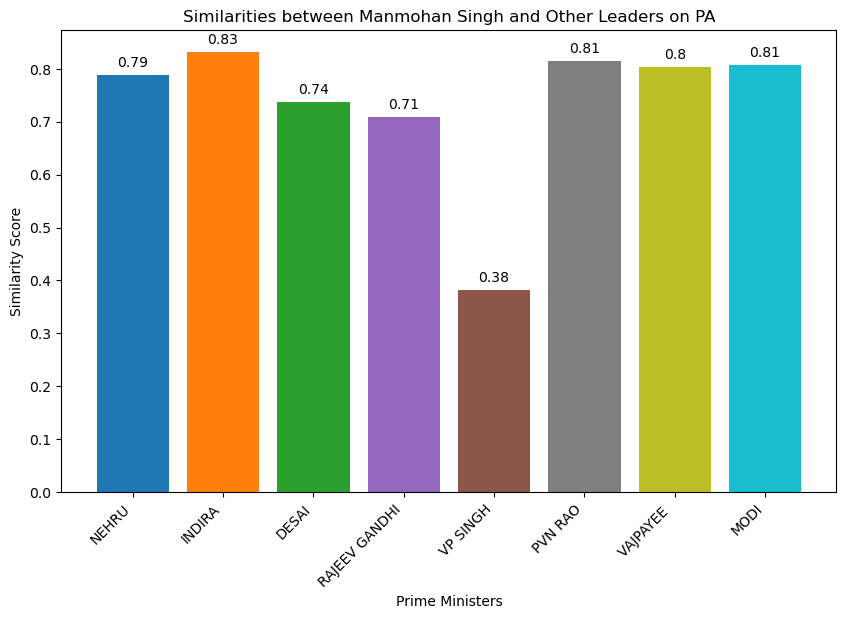

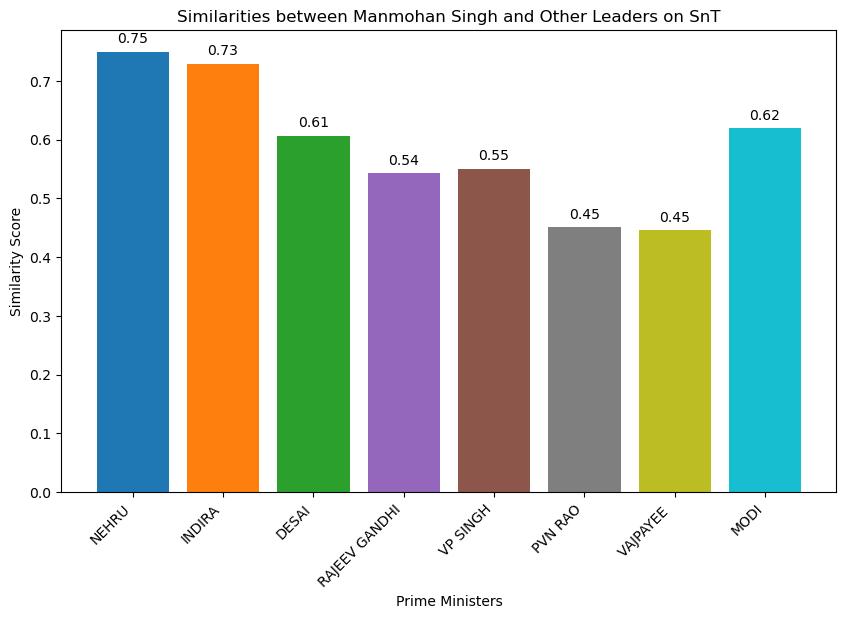

E: [ 0.0088857   0.06029111  0.00986856  0.06022668 -0.01900696 -0.03729345
  0.0568778  -0.09992085  0.09721641  0.02284556 -0.09454055 -0.1227991
  0.00082058  0.00697206 -0.15863715  0.12125167  0.01199922  0.11310299
  0.01540908 -0.07911488 -0.00364951  0.03743683  0.05231537 -0.02990541
  0.02622574 -0.01103622 -0.0914624   0.0234368   0.03974042  0.00287543
 -0.01891993 -0.10830628 -0.02570101  0.02788314  0.01933991  0.01418631
  0.07457721 -0.00379011  0.07721686  0.05342538  0.01439945 -0.01547992
  0.08308338  0.00736031 -0.06207542 -0.12764388 -0.00790211  0.00427852
 -0.10745481  0.05276453  0.06140912  0.00956932 -0.01913392  0.0071092
  0.02840969 -0.03161658 -0.09790463 -0.01774982  0.05257403 -0.10454063
 -0.0886647   0.05383095 -0.09935834 -0.01344372 -0.0006864   0.00055973
 -0.0455361   0.04523093  0.05283053  0.0213577  -0.02844916 -0.04530552
  0.05701869 -0.00314912 -0.0727556  -0.08085781  0.05590481  0.09210544
  0.00308464  0.0262955   0.03168512  0.01308756 -

In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

# Assuming word2vec model is loaded as 'word2vec_model'

def average_word_vector(words, model, num_features=300):
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model:
            num_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

def extract_and_preprocess(text):
    # Convert text to lowercase and split by commas, removing extra spaces
    return [word.strip().lower().replace('"', '') for word in text.split(',')]

def compute_avg_vectors(df, column, model):
    avg_vectors = {}
    for idx, row in df.iterrows():
        words = extract_and_preprocess(row[column])
        avg_vectors[row['PRIME MINISTER COMPARISON']] = average_word_vector(words, model)
    return avg_vectors

def compute_similarity(target_vector, avg_vectors):
    similarities = {}
    for pm, vector in avg_vectors.items():
        if np.linalg.norm(target_vector) != 0 and np.linalg.norm(vector) != 0:  # Avoid zero vectors
            similarity = cosine_similarity([target_vector], [vector])[0][0]
            similarities[pm] = similarity
    return similarities

def plot_similarity(similarities, title):
    pms = list(similarities.keys())
    scores = list(similarities.values())
    
    # Generate a color map for each Prime Minister
    colors = plt.cm.tab10(np.linspace(0, 1, len(pms)))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pms, scores, color=colors)

    # Add similarity scores on top of each bar
    for bar, score in zip(bars, scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(score, 2), ha='center', va='bottom', fontsize=10)
    
    plt.ylabel('Similarity Score')
    plt.xlabel('Prime Ministers')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()

# Paths to the document
file_path = r"C:/Users/HP/Downloads/pmcomp.xlsx"
df2 = pd.read_excel(file_path)

# Compute average word vectors for each topic column
manmohans_vectors = {}
columns = ['E', 'IANS', 'IR', 'C', 'PA', 'SnT']

for column in columns:
    avg_vectors = compute_avg_vectors(df2, column, word2vec_model)
    manmohans_vector = avg_vectors.pop('MANMOHAN', None)  # Get Manmohan Singh's vector and remove it from avg_vectors
    manmohans_vectors[column] = manmohans_vector
    similarities = compute_similarity(manmohans_vector, avg_vectors)
    
    # Plot the similarities for each column
    plot_similarity(similarities, f'Similarities between Manmohan Singh and Other Leaders on {column}')

def display_avg_word_vectors(avg_vectors):
    for pm, vector in avg_vectors.items():
        print(f"{pm}: {vector}")

# Example usage to display Manmohan Singh's vectors
display_avg_word_vectors(manmohans_vectors)


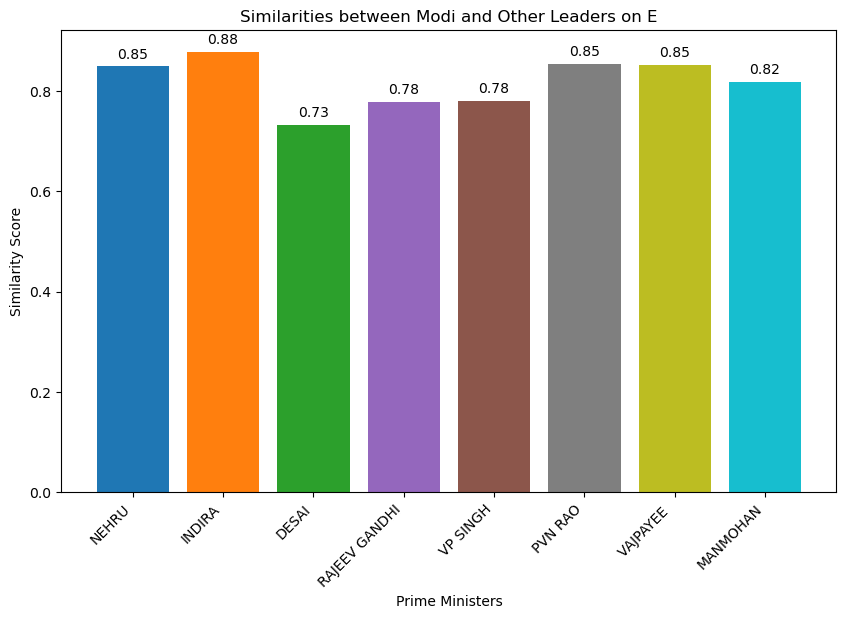

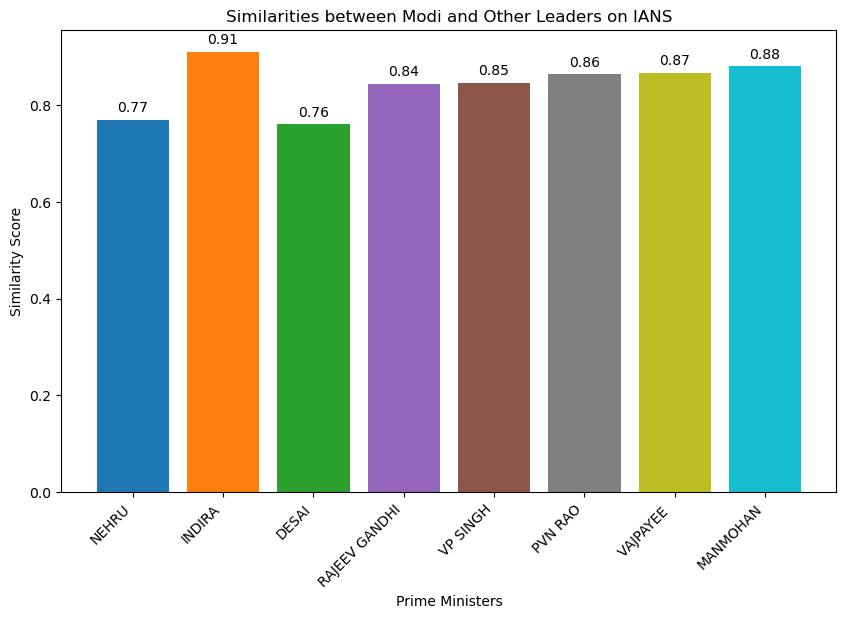

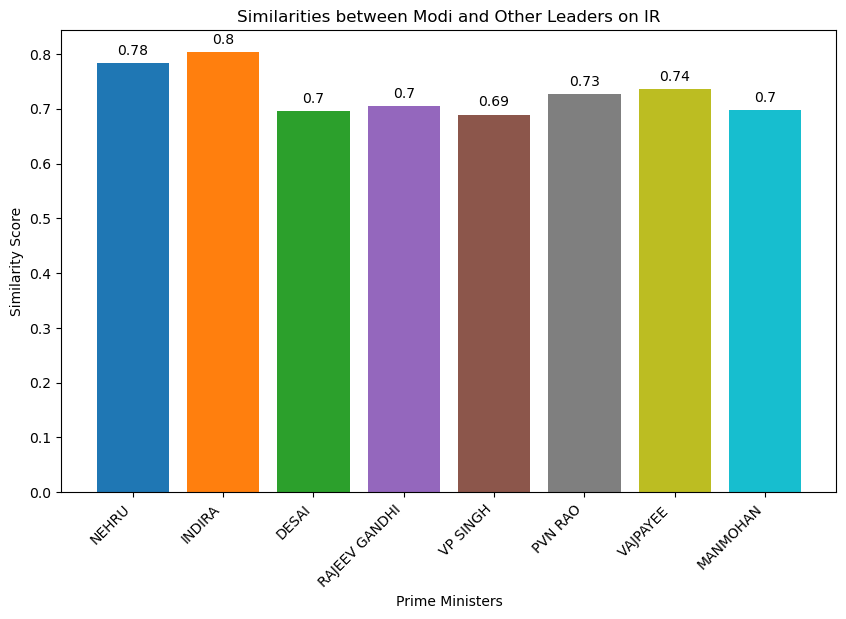

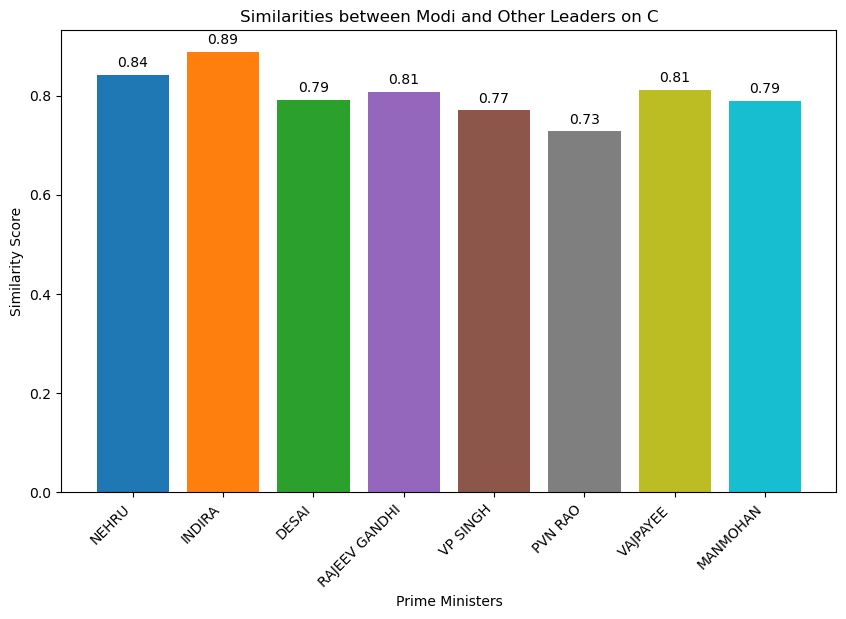

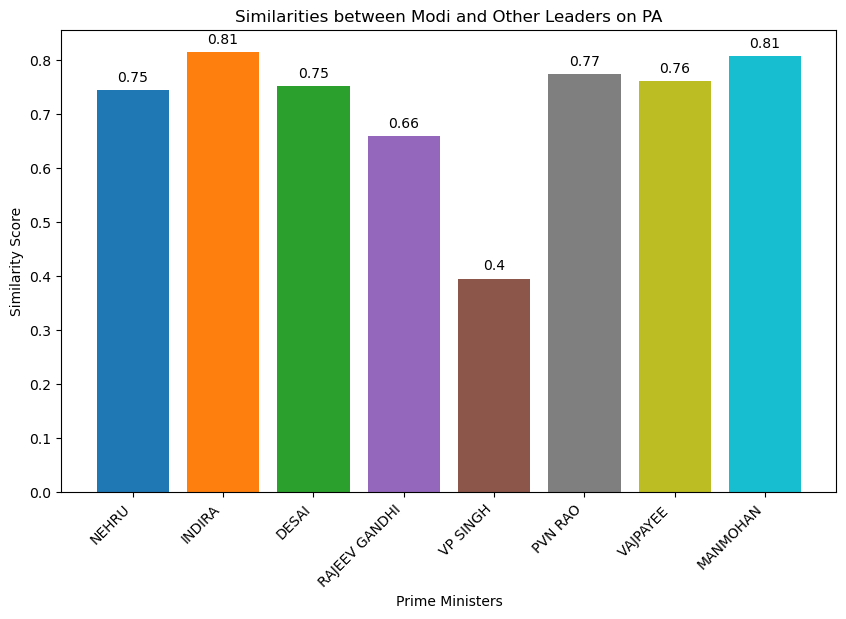

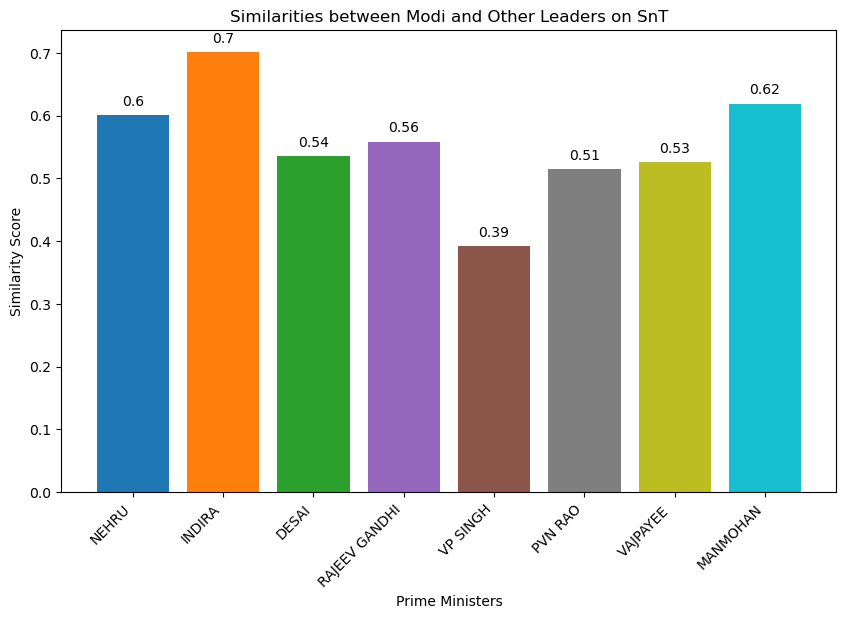

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

# Assuming word2vec model is loaded as 'word2vec_model'

def average_word_vector(words, model, num_features=300):
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model:
            num_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

def extract_and_preprocess(text):
    # Convert text to a list of words (implement preprocessing as needed)
    words = text.strip().replace('"', '').split(',')
    return [word.strip() for word in words]

def compute_avg_vectors(df, column, model):
    avg_vectors = {}
    for idx, row in df.iterrows():
        words = extract_and_preprocess(row[column])
        avg_vectors[row['PRIME MINISTER COMPARISON']] = average_word_vector(words, model)
    return avg_vectors

def compute_similarity(target_vector, avg_vectors):
    similarities = {}
    for pm, vector in avg_vectors.items():
        if np.linalg.norm(target_vector) != 0 and np.linalg.norm(vector) != 0:  # Avoid zero vectors
            similarity = cosine_similarity([target_vector], [vector])[0][0]
            similarities[pm] = similarity
    return similarities

def plot_similarity(similarities, title):
    pms = list(similarities.keys())
    scores = list(similarities.values())
    
    # Generate a color map for each Prime Minister
    colors = plt.cm.tab10(np.linspace(0, 1, len(pms)))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pms, scores, color=colors)

    # Add similarity scores on top of each bar
    for bar, score in zip(bars, scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(score, 2), ha='center', va='bottom', fontsize=10)
    
    plt.ylabel('Similarity Score')
    plt.xlabel('Prime Ministers')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()

# Paths to the document
file_path = r"C:/Users/HP/Downloads/pmcomp.xlsx"
df2 = pd.read_excel(file_path)

# Compute average word vectors for each topic column
modis_vectors = {}
columns = ['E', 'IANS', 'IR', 'C', 'PA', 'SnT']

for column in columns:
    avg_vectors = compute_avg_vectors(df2, column, word2vec_model)
    modis_vector = avg_vectors.pop('MODI', None)  # Get Modi's vector and remove it from avg_vectors
    if modis_vector is not None:
        modis_vectors[column] = modis_vector
        similarities = compute_similarity(modis_vector, avg_vectors)
        
        # Plot the similarities for each column
        plot_similarity(similarities, f'Similarities between Modi and Other Leaders on {column}')
    else:
        print(f"Modi's vector is missing for column {column}.")
